In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as cls
import seaborn as sns
import numpy as np
from pathlib import Path
from urllib.parse import urlparse
import glob
from collections import Counter
import re
import warnings
import requests
import json
import random
import time
import math
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

# Definitions

In [62]:
"""=== NATURE FORMAT CONFIGURATION ==="""
# Set these once at the beginning for all plots in the notebook

# Font settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']  # Fallback fonts
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 9
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['legend.title_fontsize'] = 7
plt.rcParams['figure.titlesize'] = 9

# Line and spine settings
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['patch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5

# Grid settings
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.3

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.05

# Remove top and right spines by default
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Nature figure widths (in inches) - these stay the same
SINGLE_COL = 3.5   # 89 mm
ONE_HALF_COL = 4.7  # 120 mm
DOUBLE_COL = 7.2   # 183 mm

print("✓ Nature format configuration loaded")
print(f"  Single column width: {SINGLE_COL}\"")
print(f"  1.5 column width: {ONE_HALF_COL}\"")
print(f"  Double column width: {DOUBLE_COL}\"")

✓ Nature format configuration loaded
  Single column width: 3.5"
  1.5 column width: 4.7"
  Double column width: 7.2"


# Load CSVs

In [63]:
"""Load all CSV files from the final dataset"""
print("Loading data from final dataset...")

# Load forum posts
posts_df = pd.read_csv("../data/nodes_forum_posts.csv")
print(f"Loaded {len(posts_df)} forum posts")

# Clean and prepare data
posts_df['posted_at'] = pd.to_datetime(posts_df['posted_at'], errors='coerce')
posts_df['base_score'] = pd.to_numeric(posts_df['base_score'], errors='coerce').fillna(0)
posts_df['comment_count'] = pd.to_numeric(posts_df['comment_count'], errors='coerce').fillna(0)
posts_df['vote_count'] = pd.to_numeric(posts_df['vote_count'], errors='coerce').fillna(0)

# Extract year and month from posted_at
posts_df['year'] = posts_df['posted_at'].dt.year
posts_df['month'] = posts_df['posted_at'].dt.month

# Separate by platform if needed
lesswrong_df = posts_df[posts_df['source'] == 'lesswrong'].copy()
alignment_forum_df = posts_df[posts_df['source'] == 'alignment_forum'].copy()

print(f"  - LessWrong: {len(lesswrong_df)} posts")
print(f"  - Alignment Forum: {len(alignment_forum_df)} posts")
print(f"  - Crossposts: {posts_df['is_crosspost'].sum()} posts")

# Load other tables if needed
authors_df = pd.read_csv("../data/nodes_forum_authors.csv")
openalex_works_df = pd.read_csv("../data/nodes_openalex_works.csv")
openalex_authors_df = pd.read_csv("../data/nodes_openalex_authors.csv")

print(f"\nLoaded additional tables:")
print(f"  - Forum authors: {len(authors_df)}")
print(f"  - OpenAlex works: {len(openalex_works_df)}")
print(f"  - OpenAlex authors: {len(openalex_authors_df)}")

# Load edge tables
edges_post_to_post = pd.read_csv("../data/edges_post_to_post.csv")
edges_post_to_openalex = pd.read_csv("../data/edges_post_to_openalex.csv")
edges_openalex_to_openalex = pd.read_csv("../data/edges_openalex_to_openalex.csv")
edges_openalex_authorship = pd.read_csv("../data/edges_openalex_authorship.csv")

print(f"\nLoaded edge tables:")
print(f"  - Post → Post citations: {len(edges_post_to_post)}")
print(f"  - Post → OpenAlex citations: {len(edges_post_to_openalex)}")
print(f"  - OpenAlex → OpenAlex citations: {len(edges_openalex_to_openalex)}")
print(f"  - OpenAlex authorship: {len(edges_openalex_authorship)}")

# Optional: Create a combined_df with 'platform' column for backwards compatibility
combined_df = posts_df.copy()
combined_df['platform'] = combined_df['source'].map({
    'lesswrong': 'LessWrong',
    'alignment_forum': 'Alignment Forum'
})

print(f"\nReady for analysis!")

Loading data from final dataset...
Loaded 47666 forum posts
  - LessWrong: 43451 posts
  - Alignment Forum: 4215 posts
  - Crossposts: 8492 posts

Loaded additional tables:
  - Forum authors: 6198
  - OpenAlex works: 200060
  - OpenAlex authors: 365946

Loaded edge tables:
  - Post → Post citations: 9415
  - Post → OpenAlex citations: 406
  - OpenAlex → OpenAlex citations: 581852
  - OpenAlex authorship: 640486

Ready for analysis!


---
# Forum Nodes
---

In [4]:
def truncate_colormap(cmap, min_val=0.0, max_val=1.0, n=256):
    """Helper function to truncate colormap."""
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{min_val:.2f},{max_val:.2f})',
        cmap(np.linspace(min_val, max_val, n))
    )
    return new_cmap

## Topic Analysis


--- Analyzing LessWrong ---


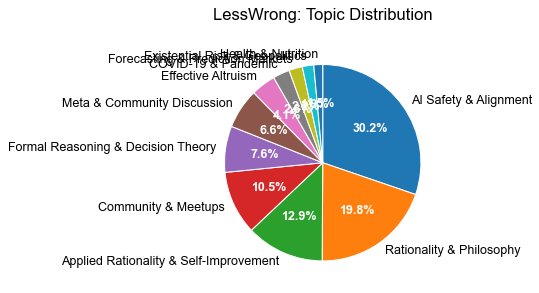

Topics found: 11
Total posts with topics: 42463
Posts without topics: 988

--- Analyzing Alignment Forum ---


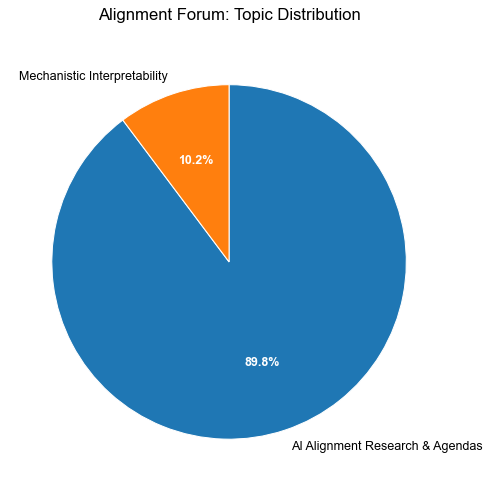

Topics found: 2
Total posts with topics: 4135
Posts without topics: 80

--- Creating combined comparison ---


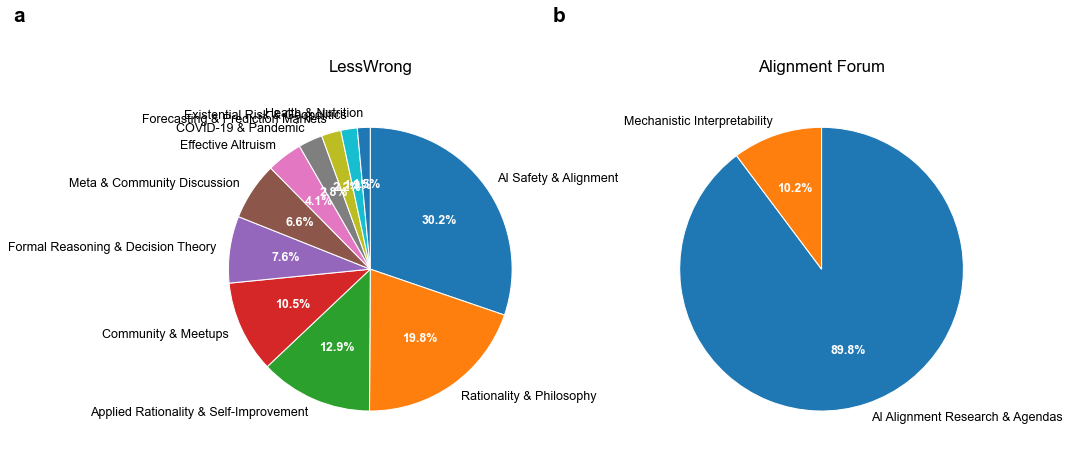


--- Summary Statistics ---
Total posts analyzed: 47666
LessWrong posts: 43451
Alignment Forum posts: 4215
Crossposts: 8492
Posts with topic assignments: 46598
Posts without topics (outliers): 1068


In [5]:
"""=== TOPIC ANALYSIS ==="""

# Use the already loaded data with new column names
lesswrong_df = posts_df[posts_df['source'] == 'lesswrong'].copy()
alignment_forum_df = posts_df[posts_df['source'] == 'alignment_forum'].copy()

# Plot for both platforms
for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df)]:
    
    print(f"\n--- Analyzing {platform_name} ---")
    
    # Filter out posts without topics (topic_id == -1 or topic_label is NaN)
    filtered_df = platform_df[platform_df['topic_label'].notna()].copy()
    
    if len(filtered_df) == 0:
        print(f"No topics found for {platform_name}")
        continue
    
    # Get topic counts
    topic_counts = filtered_df["topic_label"].value_counts()
    
    # --- Figure: Topic distribution pie chart (Nature format) ---
    fig, ax = plt.subplots(figsize=(3.5, 3.5))  # Single column width (89mm)
    
    wedges, texts, autotexts = ax.pie(
        topic_counts.values,
        labels=topic_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False,
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        textprops={'fontsize': 6}  # Small font for labels
    )
    
    # Format percentage text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(6)
        autotext.set_weight('bold')
    
    # Format labels
    for text in texts:
        text.set_fontsize(6)
    
    ax.set_title(f"{platform_name}: Topic Distribution", fontsize=8, pad=10)
    
    plt.tight_layout()
    
    plt.show()
    
    print(f"Topics found: {len(topic_counts)}")
    print(f"Total posts with topics: {len(filtered_df)}")
    print(f"Posts without topics: {len(platform_df) - len(filtered_df)}")

# --- Combined plot for both platforms (Nature double-column format) ---
print("\n--- Creating combined comparison ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.2, 3.5))  # Double column width

for ax, (platform_name, platform_df) in zip([ax1, ax2], [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df)]):
    filtered_df = platform_df[platform_df['topic_label'].notna()].copy()
    
    if len(filtered_df) == 0:
        ax.text(0.5, 0.5, f'No topics for {platform_name}', 
                ha='center', va='center', fontsize=7)
        ax.set_title(f"{platform_name}", fontsize=8)
        continue
    
    topic_counts = filtered_df["topic_label"].value_counts()
    
    wedges, texts, autotexts = ax.pie(
        topic_counts.values,
        labels=topic_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False,
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        textprops={'fontsize': 6}
    )
    
    # Format percentage text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(6)
        autotext.set_weight('bold')
    
    # Format labels
    for text in texts:
        text.set_fontsize(6)
    
    ax.set_title(f"{platform_name}", fontsize=8, pad=10)

# Add figure labels (a, b) as Nature requires
fig.text(0.02, 0.98, 'a', fontsize=10, fontweight='bold', va='top')
fig.text(0.52, 0.98, 'b', fontsize=10, fontweight='bold', va='top')

plt.tight_layout()

plt.show()

print("\n--- Summary Statistics ---")
print(f"Total posts analyzed: {len(posts_df)}")
print(f"LessWrong posts: {len(lesswrong_df)}")
print(f"Alignment Forum posts: {len(alignment_forum_df)}")
print(f"Crossposts: {posts_df['is_crosspost'].sum()}")
print(f"Posts with topic assignments: {posts_df['topic_label'].notna().sum()}")
print(f"Posts without topics (outliers): {posts_df['topic_label'].isna().sum()}")

### Validation

In [6]:
from scipy import stats
from math import ceil, sqrt

# Configuration
TOTAL_VALIDATION_SAMPLES = 382  # Adjust based on how many you want to validate
RANDOM_SEED = 42  # For reproducibility
EXPECTED_ACCURACY = 0.95  # Expected accuracy of topic classification
CONFIDENCE_LEVEL = 0.95  # 95% confidence interval
MARGIN_OF_ERROR = 0.05  # ±5%

In [7]:
def calculate_sample_size(population_size, confidence=0.95, margin_error=0.05, expected_prop=0.5):
    """
    Calculate required sample size for proportion estimation.
    
    Args:
        population_size: Total population size
        confidence: Confidence level (e.g., 0.95 for 95%)
        margin_error: Desired margin of error (e.g., 0.05 for ±5%)
        expected_prop: Expected proportion (use 0.5 for maximum sample size)
    
    Returns:
        Required sample size
    """
    # Z-score for confidence level
    z_scores = {0.90: 1.645, 0.95: 1.96, 0.99: 2.576}
    z = z_scores.get(confidence, 1.96)
    
    # Sample size formula for infinite population
    n_infinite = (z**2 * expected_prop * (1 - expected_prop)) / (margin_error**2)
    
    # Finite population correction
    n_finite = n_infinite / (1 + ((n_infinite - 1) / population_size))
    
    return ceil(n_finite)

In [8]:
def calculate_confidence_interval(sample_size, observed_accuracy, confidence=0.95):
    """
    Calculate confidence interval for observed accuracy.
    
    Args:
        sample_size: Number of samples validated
        observed_accuracy: Proportion of correct classifications (0-1)
        confidence: Confidence level
    
    Returns:
        (lower_bound, upper_bound)
    """
    z_scores = {0.90: 1.645, 0.95: 1.96, 0.99: 2.576}
    z = z_scores.get(confidence, 1.96)
    
    # Standard error for proportion
    se = sqrt((observed_accuracy * (1 - observed_accuracy)) / sample_size)
    
    # Confidence interval
    margin = z * se
    lower = max(0, observed_accuracy - margin)
    upper = min(1, observed_accuracy + margin)
    
    return lower, upper

In [9]:
def print_sample_size_analysis(population_size, sample_size, confidence=0.95, margin_error=0.05):
    """Print detailed sample size justification."""
    print("\n" + "="*80)
    print("STATISTICAL POWER ANALYSIS")
    print("="*80)
    
    # Calculate required sample size for different scenarios
    required_conservative = calculate_sample_size(population_size, confidence, margin_error, 0.5)
    required_optimistic = calculate_sample_size(population_size, confidence, margin_error, 0.85)
    
    print(f"\nPopulation size: {population_size:,}")
    print(f"Actual sample size: {sample_size}")
    print(f"Confidence level: {confidence*100}%")
    print(f"Target margin of error: ±{margin_error*100}%")
    
    print(f"\n--- Required Sample Sizes ---")
    print(f"Conservative estimate (p=0.5): {required_conservative}")
    print(f"Optimistic estimate (p=0.85): {required_optimistic}")
    
    if sample_size >= required_conservative:
        print(f"\n✓ Sample size is ADEQUATE (exceeds conservative requirement)")
    elif sample_size >= required_optimistic:
        print(f"\n⚠ Sample size is ACCEPTABLE (meets optimistic requirement)")
    else:
        print(f"\n✗ Sample size may be INSUFFICIENT")
        print(f"  Recommend at least {required_conservative} samples")
    
    # Show what margin of error we can actually achieve
    actual_margin = 1.96 * sqrt((0.5 * 0.5) / sample_size)
    print(f"\nWith {sample_size} samples, you can estimate accuracy within:")
    print(f"  ±{actual_margin*100:.2f}% at 95% confidence (conservative)")
    
    # Power analysis for different accuracy levels
    print(f"\n--- Expected Confidence Intervals ---")
    print(f"If observed accuracy is:")
    for accuracy in [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]:
        lower, upper = calculate_confidence_interval(sample_size, accuracy, confidence)
        print(f"  {accuracy*100}%: 95% CI = [{lower*100:.1f}%, {upper*100:.1f}%]")
    
    print("\n" + "="*80)

In [10]:
# Use data already loaded from nodes_forum_posts.csv
lesswrong_df = posts_df[posts_df['source'] == 'lesswrong'].copy()
alignment_forum_df = posts_df[posts_df['source'] == 'alignment_forum'].copy()

# Combine both platforms
combined_df = pd.concat([
    lesswrong_df.assign(platform='LessWrong'),
    alignment_forum_df.assign(platform='Alignment Forum')
], ignore_index=True)

# Filter to posts with topics only (exclude outliers with topic_id == -1)
validation_df = combined_df[combined_df['topic_label'].notna()].copy()

print(f"Total posts for validation: {len(validation_df):,}")

# Print statistical analysis
print_sample_size_analysis(
    population_size=len(validation_df),
    sample_size=TOTAL_VALIDATION_SAMPLES,
    confidence=CONFIDENCE_LEVEL,
    margin_error=MARGIN_OF_ERROR
)

print(f"\n{'='*80}")
print("TOPIC DISTRIBUTION")
print(f"{'='*80}")

# Get topic counts and proportions
topic_counts = validation_df["topic_label"].value_counts()
topic_proportions = topic_counts / len(validation_df)

print(f"\n{'Topic':<40} {'Count':>8} {'%':>7} {'Samples':>8}")
print("-" * 80)

for topic, count in topic_counts.items():
    proportion = count / len(validation_df)
    n_samples = round(TOTAL_VALIDATION_SAMPLES * proportion)
    print(f"{topic:<40} {count:>8,} {proportion*100:>6.1f}% {n_samples:>8}")

print("-" * 80)
print(f"{'TOTAL':<40} {len(validation_df):>8,} {100.0:>6.1f}% {TOTAL_VALIDATION_SAMPLES:>8}")
print(f"\nNote: Final allocation will be adjusted to ensure exactly {TOTAL_VALIDATION_SAMPLES} samples")

# Stratified sampling
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Calculate proportional samples for each topic with remainder allocation
sample_allocation = {}
allocated_so_far = 0

for i, (topic, count) in enumerate(topic_counts.items()):
    if i == len(topic_counts) - 1:
        # Last category gets the remainder to ensure we hit exactly TOTAL_VALIDATION_SAMPLES
        n_samples = TOTAL_VALIDATION_SAMPLES - allocated_so_far
    else:
        # Proportional allocation with rounding
        n_samples = round(TOTAL_VALIDATION_SAMPLES * count / len(validation_df))
        allocated_so_far += n_samples
    
    sample_allocation[topic] = max(1, n_samples)  # Ensure at least 1 sample per topic

print(f"\n{'='*80}")
print("SAMPLE ALLOCATION (after adjusting for rounding)")
print(f"{'='*80}")
print(f"{'Topic':<40} {'Allocated Samples':>20}")
print("-" * 80)
total_allocated = 0
for topic in topic_counts.index:
    n = sample_allocation[topic]
    print(f"{topic:<40} {n:>20}")
    total_allocated += n
print("-" * 80)
print(f"{'TOTAL':<40} {total_allocated:>20}")
print(f"{'='*80}")

validation_samples = []

for topic in topic_counts.index:
    topic_df = validation_df[validation_df["topic_label"] == topic]
    n_samples = sample_allocation[topic]
    
    # Sample randomly
    if len(topic_df) >= n_samples:
        sampled = topic_df.sample(n=n_samples, random_state=RANDOM_SEED)
    else:
        sampled = topic_df  # If topic has fewer posts than needed samples
    
    validation_samples.append(sampled)

validation_set = pd.concat(validation_samples, ignore_index=True)

# Shuffle the validation set
validation_set = validation_set.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Drop columns that don't exist in final dataset or aren't needed
columns_to_drop = ['html_body', 'slug', 'page_url', 'posted_at', 'base_score',
                   'vote_count', 'comment_count', 'is_question', 'author_username',
                   'author_slug', 'author_display_name', 'extracted_links',
                   'author_gender_inferred', 'extracted_dois', 'topic_id', 
                   'year', 'month', 'doi', 'openalex_id', 'is_crosspost']
validation_set = validation_set.drop(columns=columns_to_drop, errors='ignore')

# Truncate text column to 500 chars if it exists
if 'text' in validation_set.columns:
    validation_set['text_preview'] = validation_set['text'].astype(str).apply(
        lambda x: x[:500] + "..." if len(x) > 500 else x
    )
    validation_set = validation_set.drop(columns=['text'])  # Keep only preview

print(f"\n{'='*80}")
print("VALIDATION SET CREATED")
print(f"{'='*80}")
print(f"Total validation samples: {len(validation_set)}")
print(f"\nActual samples per topic:")
print(validation_set["topic_label"].value_counts().sort_index())

# Add columns for manual validation
validation_set['validation_correct'] = ''  # To be filled: 'yes', 'no', 'unsure'
validation_set['validation_notes'] = ''
validation_set['validation_alternative_topic'] = ''  # If incorrect, what should it be?

# Save to CSV for validation
output_file = 'topic_validation_set.csv'
validation_set.to_csv(output_file, index=False)
print(f"\n✓ Saved validation set to: {output_file}")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("1. Open 'topic_validation_set.csv' in Excel/Google Sheets")
print("2. For each row, fill in:")
print("   - validation_correct: 'yes', 'no', or 'unsure'")
print("   - validation_notes: Any comments")
print("   - validation_alternative_topic: If 'no', what should the topic be?")
print("3. Save the file and run the analysis script to calculate:")
print("   - Overall accuracy with confidence intervals")
print("   - Per-topic accuracy")
print("   - Confusion matrix")
print("   - Inter-rater reliability (if multiple raters)")
print("\nOptional: Share the CSV with another rater for inter-rater reliability!")
print("="*80)

Total posts for validation: 46,598

STATISTICAL POWER ANALYSIS

Population size: 46,598
Actual sample size: 382
Confidence level: 95.0%
Target margin of error: ±5.0%

--- Required Sample Sizes ---
Conservative estimate (p=0.5): 382
Optimistic estimate (p=0.85): 196

✓ Sample size is ADEQUATE (exceeds conservative requirement)

With 382 samples, you can estimate accuracy within:
  ±5.01% at 95% confidence (conservative)

--- Expected Confidence Intervals ---
If observed accuracy is:
  70.0%: 95% CI = [65.4%, 74.6%]
  75.0%: 95% CI = [70.7%, 79.3%]
  80.0%: 95% CI = [76.0%, 84.0%]
  85.0%: 95% CI = [81.4%, 88.6%]
  90.0%: 95% CI = [87.0%, 93.0%]
  95.0%: 95% CI = [92.8%, 97.2%]


TOPIC DISTRIBUTION

Topic                                       Count       %  Samples
--------------------------------------------------------------------------------
AI Safety & Alignment                      12,844   27.6%      105
Rationality & Philosophy                    8,425   18.1%       69
Applied Rat

In [11]:
# Load the annotated validation set
validation_df = pd.read_csv('topic_validation_set_annotated.csv')

In [12]:
# ============================================================================
# 1. OVERALL ACCURACY
# ============================================================================
print("\n" + "="*80)
print("1. OVERALL ACCURACY")
print("="*80)

# Count validation responses
validation_counts = validation_df['validation_correct'].value_counts()
total_validated = len(validation_df[validation_df['validation_correct'].isin(['yes', 'no', 'unsure'])])

if total_validated == 0:
    print("⚠️  No validation responses found. Please check the CSV file.")
else:
    accuracy = (validation_counts.get('yes', 0) / total_validated) * 100
    error_rate = (validation_counts.get('no', 0) / total_validated) * 100
    unsure_rate = (validation_counts.get('unsure', 0) / total_validated) * 100
    
    print(f"\nTotal Validated Samples: {total_validated}")
    print(f"\n✓ Correct (yes):  {validation_counts.get('yes', 0):3d} ({accuracy:.1f}%)")
    print(f"✗ Incorrect (no): {validation_counts.get('no', 0):3d} ({error_rate:.1f}%)")
    print(f"? Unsure:         {validation_counts.get('unsure', 0):3d} ({unsure_rate:.1f}%)")
    
    print(f"\n{'='*50}")
    print(f"OVERALL ACCURACY: {accuracy:.1f}%")
    print(f"{'='*50}")


1. OVERALL ACCURACY

Total Validated Samples: 382

✓ Correct (yes):  360 (94.2%)
✗ Incorrect (no):  15 (3.9%)
? Unsure:           7 (1.8%)

OVERALL ACCURACY: 94.2%


In [13]:
# ============================================================================
# 2. ACCURACY BY TOPIC
# ============================================================================
print("\n" + "="*80)
print("2. ACCURACY BY TOPIC")
print("="*80)

topic_accuracy = []

for topic in validation_df['topic_label'].unique():
    topic_df = validation_df[validation_df['topic_label'] == topic]
    topic_validated = topic_df[topic_df['validation_correct'].isin(['yes', 'no', 'unsure'])]
    
    if len(topic_validated) > 0:
        correct = len(topic_validated[topic_validated['validation_correct'] == 'yes'])
        incorrect = len(topic_validated[topic_validated['validation_correct'] == 'no'])
        unsure = len(topic_validated[topic_validated['validation_correct'] == 'unsure'])
        total = len(topic_validated)
        accuracy = (correct / total) * 100
        
        topic_accuracy.append({
            'topic': topic,
            'correct': correct,
            'incorrect': incorrect,
            'unsure': unsure,
            'total': total,
            'accuracy': accuracy
        })

topic_accuracy_df = pd.DataFrame(topic_accuracy).sort_values('accuracy', ascending=False)

print("\nAccuracy by Topic (sorted by accuracy):\n")
print(f"{'Topic':<40} {'Correct':<10} {'Incorrect':<10} {'Unsure':<10} {'Total':<10} {'Accuracy'}")
print("-" * 95)

for _, row in topic_accuracy_df.iterrows():
    print(f"{row['topic']:<40} {row['correct']:<10} {row['incorrect']:<10} {row['unsure']:<10} {row['total']:<10} {row['accuracy']:.1f}%")



2. ACCURACY BY TOPIC

Accuracy by Topic (sorted by accuracy):

Topic                                    Correct    Incorrect  Unsure     Total      Accuracy
-----------------------------------------------------------------------------------------------
Mechanistic Interpretability             3          0          0          3          100.0%
Harry Potter and the Methods of Rationality 3          0          0          3          100.0%
Nuclear & Climate (Existential) Risks    5          0          0          5          100.0%
COVID 19                                 9          0          0          9          100.0%
Solstices                                3          0          0          3          100.0%
Open Threads                             2          0          0          2          100.0%
Meetups                                  34         0          0          34         100.0%
Cryonics                                 2          0          0          2          100.0%
Housing

In [14]:
# ============================================================================
# 3. CONFUSION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("3. CONFUSION ANALYSIS (Misclassified Topics)")
print("="*80)

# Get misclassified samples
misclassified = validation_df[validation_df['validation_correct'] == 'no'].copy()

if len(misclassified) > 0:
    print(f"\nTotal Misclassifications: {len(misclassified)}\n")
    
    # Count confusion patterns
    confusion_patterns = misclassified.groupby(['topic_label', 'validation_alternative_topic']).size().reset_index(name='count')
    confusion_patterns = confusion_patterns.sort_values('count', ascending=False)
    
    print("Top Confusion Patterns (Assigned → Should Be):\n")
    print(f"{'Assigned Topic':<40} {'Should Be':<40} {'Count'}")
    print("-" * 90)
    
    for _, row in confusion_patterns.head(20).iterrows():
        print(f"{row['topic_label']:<40} {row['validation_alternative_topic']:<40} {row['count']}")
    
    # Topics most often misclassified
    print("\n" + "-" * 90)
    print("Topics Most Often Misclassified:\n")
    
    misclass_by_topic = misclassified['topic_label'].value_counts()
    for topic, count in misclass_by_topic.head(10).items():
        total_samples = len(validation_df[validation_df['topic_label'] == topic])
        error_rate = (count / total_samples) * 100
        print(f"{topic:<40} {count:3d} errors ({error_rate:.1f}% of {total_samples} samples)")

else:
    print("\n✓ No misclassifications found!")


3. CONFUSION ANALYSIS (Misclassified Topics)

Total Misclassifications: 15

Top Confusion Patterns (Assigned → Should Be):

Assigned Topic                           Should Be                                Count
------------------------------------------------------------------------------------------
LessWrong Meta & Moderation              Schooling & Education                    2
Philantropy & Effective Altruism         Reasoning & Belief Systems               2
AI Alignment Research, Agendas, and Funding Mechanistic Interpretability             1
Genetics & Health Studies                Reasoning & Belief Systems               1
LessWrong Meta & Moderation              AI Safety                                1
LessWrong Meta & Moderation              Life Improvement & Productivity          1
Life Improvement & Productivity          AI Safety                                1
Philantropy & Effective Altruism         Life Improvement & Productivity          1
Predicition Markets a

In [15]:
# ============================================================================
# 4. UNSURE/AMBIGUOUS CASES
# ============================================================================
print("\n" + "="*80)
print("4. UNSURE/AMBIGUOUS CASES")
print("="*80)

unsure_cases = validation_df[validation_df['validation_correct'] == 'unsure']

if len(unsure_cases) > 0:
    print(f"\nTotal Unsure Cases: {len(unsure_cases)}\n")
    
    unsure_by_topic = unsure_cases['topic_label'].value_counts()
    print("Unsure Cases by Topic:\n")
    
    for topic, count in unsure_by_topic.items():
        total_samples = len(validation_df[validation_df['topic_label'] == topic])
        unsure_rate = (count / total_samples) * 100
        print(f"{topic:<40} {count:3d} unsure ({unsure_rate:.1f}% of {total_samples} samples)")
else:
    print("\n✓ No unsure cases!")


4. UNSURE/AMBIGUOUS CASES

Total Unsure Cases: 7

Unsure Cases by Topic:

Life Improvement & Productivity            2 unsure (6.5% of 31 samples)
Reasoning & Belief Systems                 2 unsure (2.5% of 79 samples)
AI Safety                                  1 unsure (1.1% of 95 samples)
Predicition Markets and Forecasting        1 unsure (6.2% of 16 samples)
LessWrong Meta & Moderation                1 unsure (4.0% of 25 samples)


In [16]:
# ============================================================================
# 5. PLATFORM COMPARISON
# ============================================================================
print("\n" + "="*80)
print("5. PLATFORM COMPARISON")
print("="*80)

if 'platform' in validation_df.columns:
    print("\nAccuracy by Platform:\n")
    
    for platform in validation_df['platform'].unique():
        platform_df = validation_df[validation_df['platform'] == platform]
        platform_validated = platform_df[platform_df['validation_correct'].isin(['yes', 'no', 'unsure'])]
        
        if len(platform_validated) > 0:
            correct = len(platform_validated[platform_validated['validation_correct'] == 'yes'])
            accuracy = (correct / len(platform_validated)) * 100
            print(f"{platform:<20} {correct}/{len(platform_validated)} correct ({accuracy:.1f}%)")



5. PLATFORM COMPARISON

Accuracy by Platform:

LessWrong            330/351 correct (94.0%)
Alignment Forum      30/31 correct (96.8%)


In [17]:
# ============================================================================
# 7. PERFORMANCE METRICS
# ============================================================================
print("\n" + "="*80)
print("7. DETAILED PERFORMANCE METRICS")
print("="*80)

if len(misclassified) > 0:
    print("\nPer-Topic Precision, Recall, and F1-Score:\n")
    print(f"{'Topic':<40} {'Precision':<12} {'Recall':<12} {'F1-Score'}")
    print("-" * 75)
    
    performance_metrics = []
    
    for topic in validation_df['topic_label'].unique():
        # True Positives: correctly predicted as this topic
        tp = len(validation_df[(validation_df['topic_label'] == topic) & 
                              (validation_df['validation_correct'] == 'yes')])
        
        # False Positives: incorrectly predicted as this topic
        fp = len(misclassified[(misclassified['topic_label'] == topic)])
        
        # False Negatives: actually this topic but predicted as something else
        fn = len(misclassified[misclassified['validation_alternative_topic'] == topic])
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        performance_metrics.append({
            'topic': topic,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn
        })
        
        print(f"{topic:<40} {precision:<12.3f} {recall:<12.3f} {f1:.3f}")
    
    # Save performance metrics
    performance_df = pd.DataFrame(performance_metrics)
    performance_df = performance_df.sort_values('f1_score', ascending=False)
else:
    print("\n✓ No misclassifications - all topics perfectly classified!")
    performance_df = None


7. DETAILED PERFORMANCE METRICS

Per-Topic Precision, Recall, and F1-Score:

Topic                                    Precision    Recall       F1-Score
---------------------------------------------------------------------------
LessWrong Meta & Moderation              0.833        1.000        0.909
AI Alignment Research, Agendas, and Funding 0.964        1.000        0.982
Life Improvement & Productivity          0.966        0.933        0.949
Schooling & Education                    0.800        0.800        0.800
AI Safety                                1.000        0.959        0.979
Housing                                  1.000        1.000        1.000
Reasoning & Belief Systems               0.987        0.950        0.968
Harry Potter and the Methods of Rationality 1.000        1.000        1.000
Meetups                                  1.000        0.971        0.986
Mechanistic Interpretability             1.000        0.750        0.857
Open Threads                      


7. CREATING VISUALIZATIONS

✓ Saved visualization to: validation_analysis.png


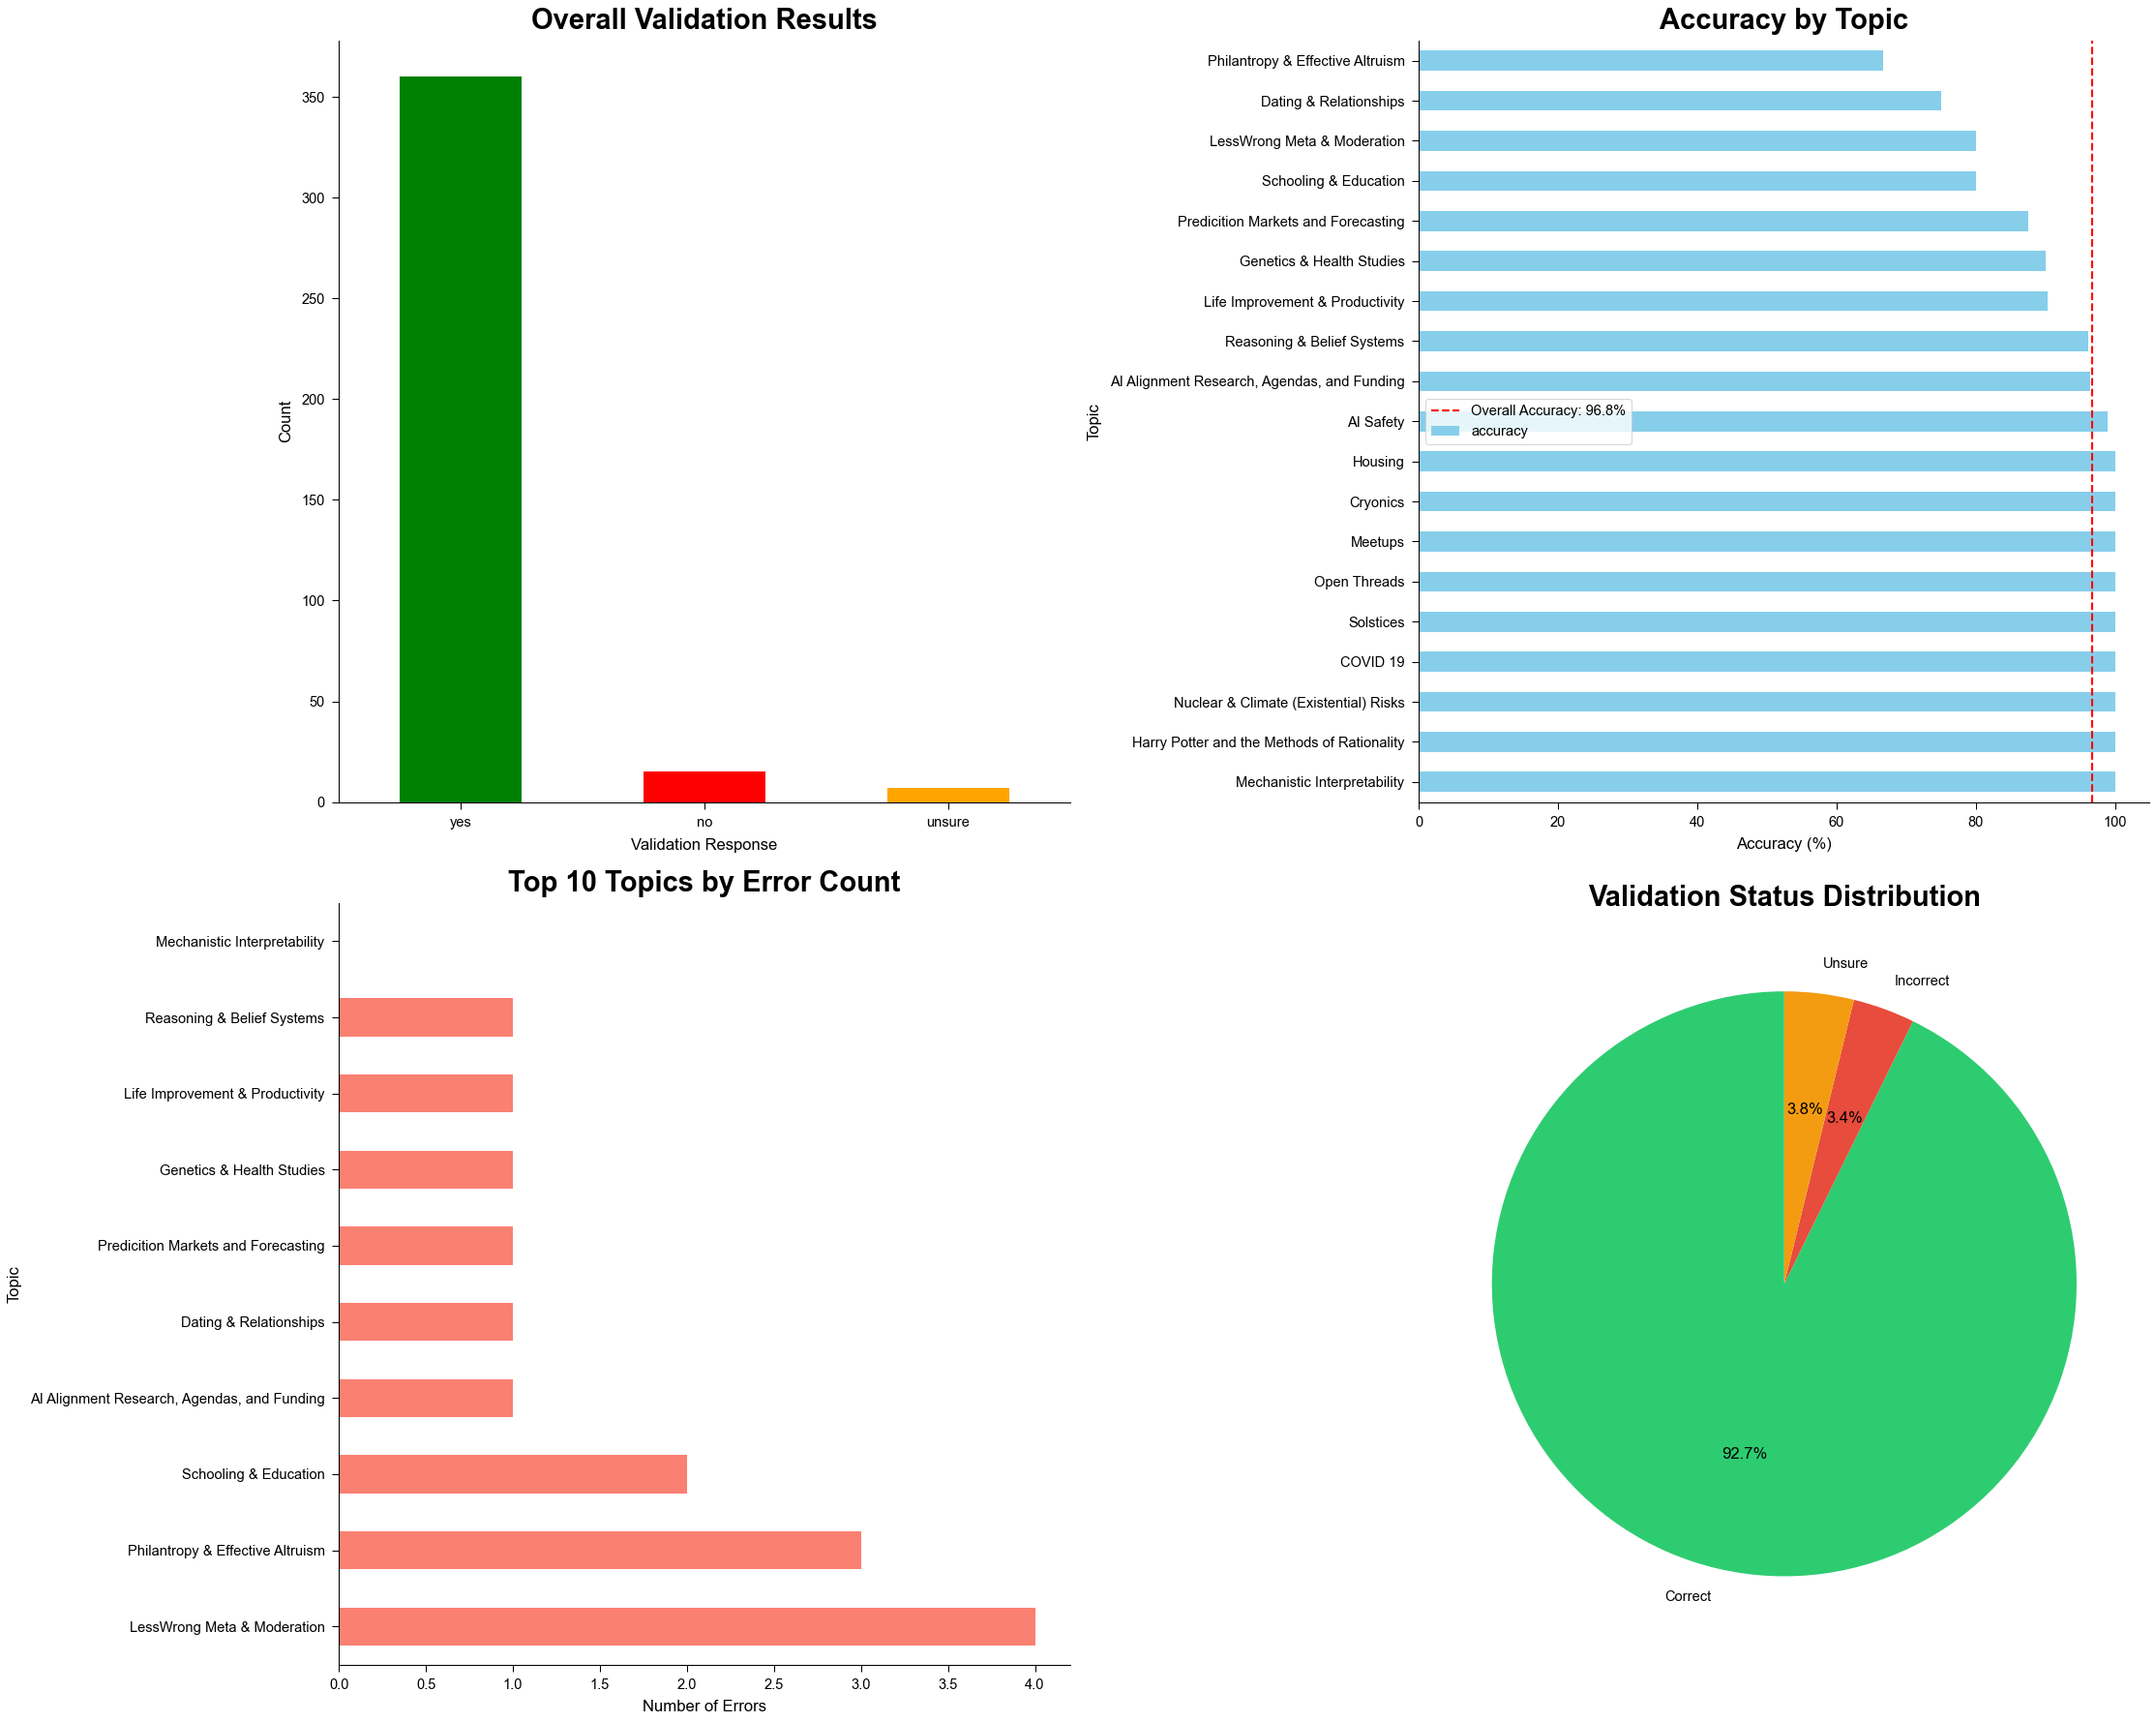

In [18]:
# ============================================================================
# 7. VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("7. CREATING VISUALIZATIONS")
print("="*80)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall validation distribution
ax1 = axes[0, 0]
validation_counts.plot(kind='bar', ax=ax1, color=['green', 'red', 'orange'])
ax1.set_title('Overall Validation Results', fontsize=14, fontweight='bold')
ax1.set_xlabel('Validation Response')
ax1.set_ylabel('Count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# 2. Accuracy by topic
ax2 = axes[0, 1]
topic_accuracy_df.plot(x='topic', y='accuracy', kind='barh', ax=ax2, legend=False, color='skyblue')
ax2.set_title('Accuracy by Topic', fontsize=14, fontweight='bold')
ax2.set_xlabel('Accuracy (%)')
ax2.set_ylabel('Topic')
ax2.axvline(x=accuracy, color='red', linestyle='--', label=f'Overall Accuracy: {accuracy:.1f}%')
ax2.legend()

# 3. Error distribution by topic
ax3 = axes[1, 0]
error_by_topic = topic_accuracy_df.sort_values('incorrect', ascending=False).head(10)
error_by_topic.plot(x='topic', y='incorrect', kind='barh', ax=ax3, legend=False, color='salmon')
ax3.set_title('Top 10 Topics by Error Count', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Errors')
ax3.set_ylabel('Topic')

# 4. Validation status distribution
ax4 = axes[1, 1]
status_df = pd.DataFrame({
    'Status': ['Correct', 'Incorrect', 'Unsure'],
    'Percentage': [accuracy, error_rate, unsure_rate]
})
colors_pie = ['#2ecc71', '#e74c3c', '#f39c12']
ax4.pie(status_df['Percentage'], labels=status_df['Status'], autopct='%1.1f%%', 
        colors=colors_pie, startangle=90)
ax4.set_title('Validation Status Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
print("\n✓ Saved visualization to: validation_analysis.png")

## Topic Analysis with Engagement Metrics


--- LessWrong: Topic Engagement Analysis ---

Topic Engagement Metrics:
                                        base_score_sum  base_score_mean  \
topic_label                                                               
AI Safety & Alignment                           466845             36.3   
Rationality & Philosophy                        272120             32.3   
Applied Rationality & Self-Improvement          196182             35.9   
Formal Reasoning & Decision Theory               79675             24.7   
Meta & Community Discussion                      63216             22.6   
Effective Altruism                               53344             30.9   
COVID-19 & Pandemic                              42146             36.0   
Forecasting & Prediction Markets                 27363             29.0   
Community & Meetups                              24645              5.5   
Existential Risk & Geopolitics                   20443             25.7   
Health & Nutrition         

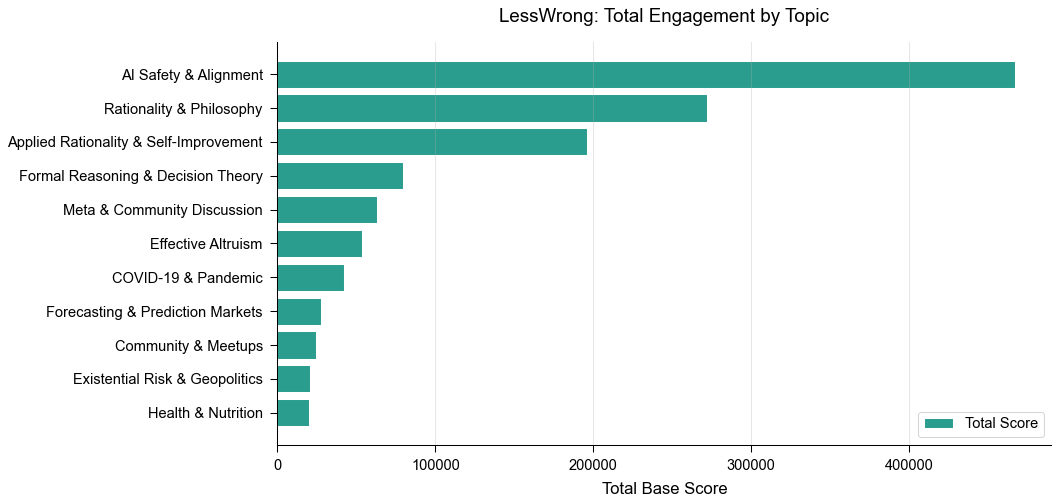

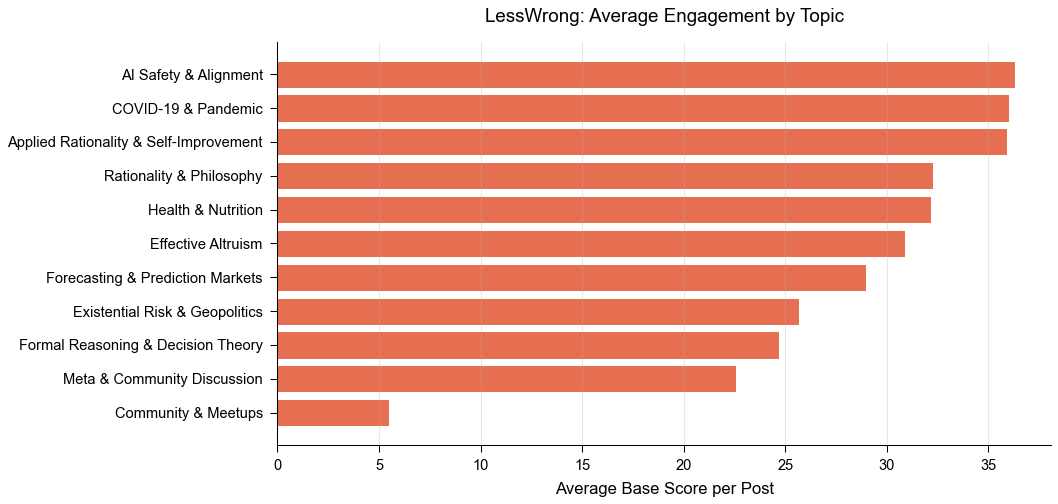

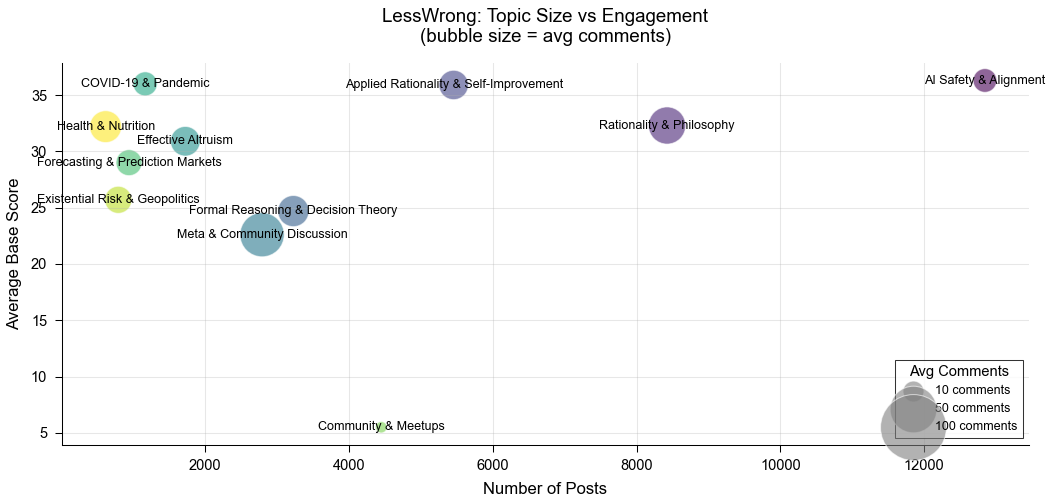

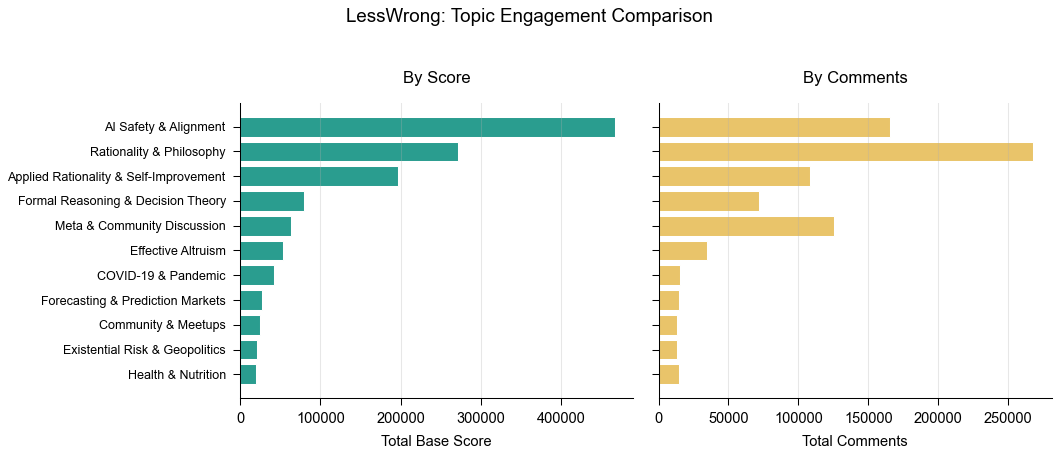


--- Alignment Forum: Topic Engagement Analysis ---

Topic Engagement Metrics:
                                 base_score_sum  base_score_mean  \
topic_label                                                        
AI Alignment Research & Agendas          204257             55.0   
Mechanistic Interpretability              27988             66.2   

                                 base_score_median  comment_count_sum  \
topic_label                                                             
AI Alignment Research & Agendas               34.0              50188   
Mechanistic Interpretability                  49.0               3793   

                                 comment_count_mean  comment_count_median  \
topic_label                                                                 
AI Alignment Research & Agendas                13.5                   6.0   
Mechanistic Interpretability                    9.0                   5.0   

                                 post_count  


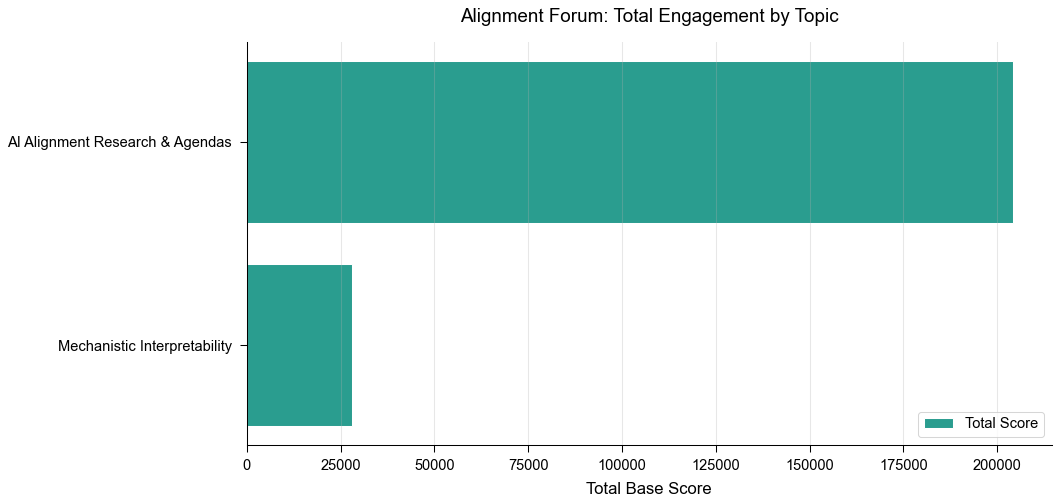

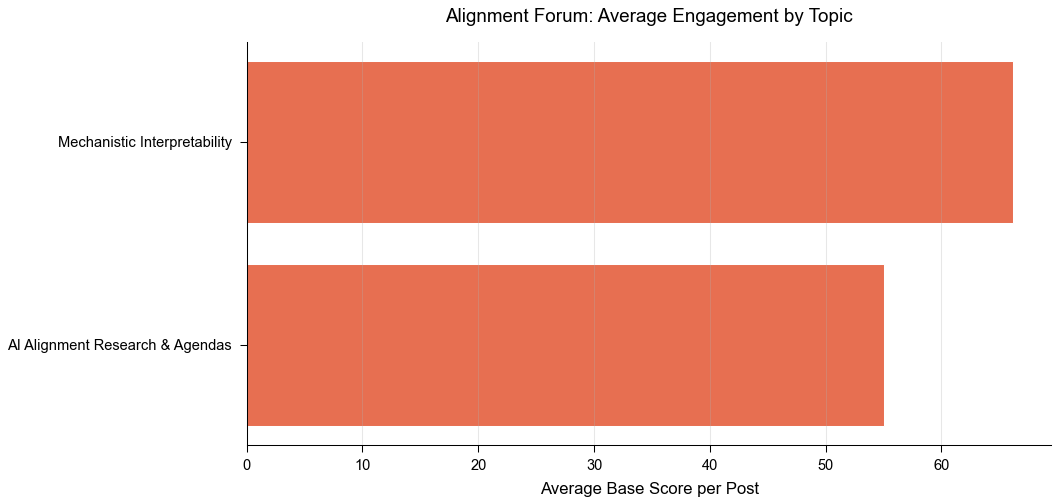

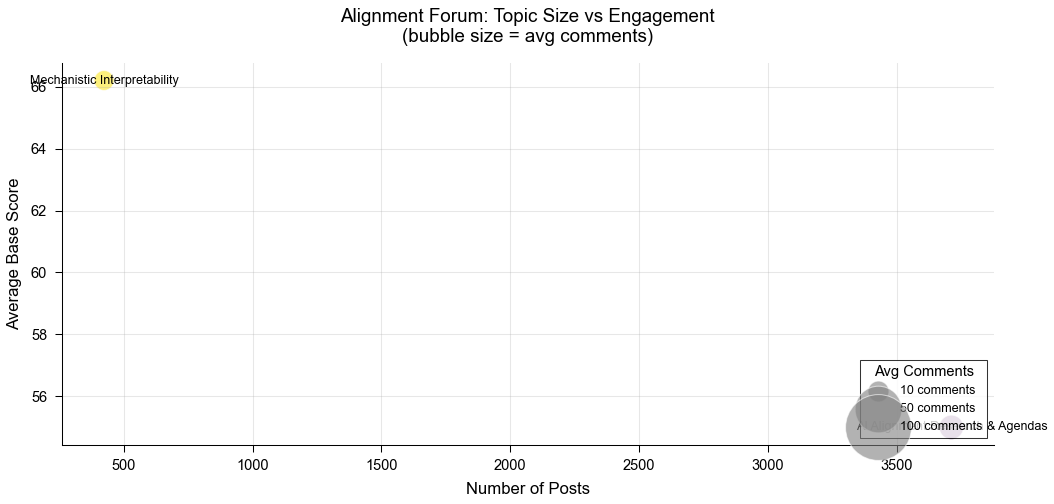

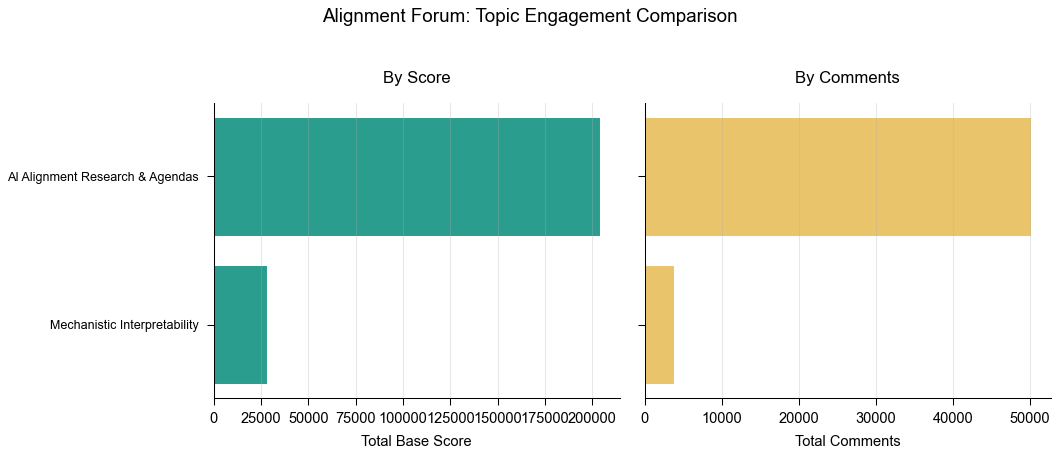


=== Topic engagement analysis complete ===


In [19]:
"""=== TOPIC ANALYSIS WITH ENGAGEMENT METRICS ==="""

# Use data already loaded from nodes_forum_posts.csv
lesswrong_df = posts_df[posts_df['source'] == 'lesswrong'].copy()
alignment_forum_df = posts_df[posts_df['source'] == 'alignment_forum'].copy()

# Analyze both platforms
for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df)]:
    
    print(f"\n--- {platform_name}: Topic Engagement Analysis ---")
    
    safe_name = platform_name.lower().replace(" ", "_")
    
    # Filter to posts with topics only
    filtered_df = platform_df[platform_df['topic_label'].notna()].copy()
        
    if len(filtered_df) == 0:
        print(f"No topics found for {platform_name}")
        continue
    
    # Calculate engagement metrics by topic
    topic_engagement = filtered_df.groupby('topic_label').agg({
        'base_score': ['sum', 'mean', 'median'],
        'comment_count': ['sum', 'mean', 'median'],
        'post_id': 'count'  # Number of posts
    }).round(1)
    
    # Flatten column names
    topic_engagement.columns = ['_'.join(col).strip() for col in topic_engagement.columns.values]
    topic_engagement = topic_engagement.rename(columns={'post_id_count': 'post_count'})
    
    # Sort by total score
    topic_engagement = topic_engagement.sort_values('base_score_sum', ascending=False)
    
    print("\nTopic Engagement Metrics:")
    print(topic_engagement)
    
    # 1. Total engagement by topic (stacked bar: score + comments)
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
    
    x_pos = np.arange(len(topic_engagement))
    
    # Normalize to make comparable (score and comments on different scales)
    # Use score as primary metric
    ax.barh(x_pos, topic_engagement['base_score_sum'], 
            color='#2a9d8f', edgecolor='white', linewidth=0.5,
            label='Total Score')
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels(topic_engagement.index, fontsize=7)
    ax.set_xlabel('Total Base Score', fontsize=8)
    ax.set_title(f'{platform_name}: Total Engagement by Topic', pad=10, fontsize=9)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    ax.legend(loc='lower right', fontsize=7)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 2. Average engagement per post by topic
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
    
    sorted_by_mean = topic_engagement.sort_values('base_score_mean', ascending=False)
    x_pos = np.arange(len(sorted_by_mean))
    
    ax.barh(x_pos, sorted_by_mean['base_score_mean'], 
            color='#e76f51', edgecolor='white', linewidth=0.5)
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels(sorted_by_mean.index, fontsize=7)
    ax.set_xlabel('Average Base Score per Post', fontsize=8)
    ax.set_title(f'{platform_name}: Average Engagement by Topic', pad=10, fontsize=9)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 3. Bubble chart: Posts vs Engagement (size = comment count)
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
    
    scatter = ax.scatter(
        topic_engagement['post_count'],
        topic_engagement['base_score_mean'],
        s=topic_engagement['comment_count_mean'] * 10,  # Size by avg comments
        c=np.arange(len(topic_engagement)),  # Color by topic
        cmap='viridis',
        alpha=0.6,
        edgecolors='white',
        linewidth=0.5
    )
    
    # Add topic labels
    for idx, row in topic_engagement.iterrows():
        ax.annotate(idx, 
                   (row['post_count'], row['base_score_mean']),
                   fontsize=6,
                   ha='center',
                   va='center')
    
    ax.set_xlabel('Number of Posts', fontsize=8)
    ax.set_ylabel('Average Base Score', fontsize=8)
    ax.set_title(f'{platform_name}: Topic Size vs Engagement\n(bubble size = avg comments)', 
                 pad=10, fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add legend for bubble size
    sizes = [10, 50, 100]
    labels = ['10 comments', '50 comments', '100 comments']
    legend_elements = [plt.scatter([], [], s=s*10, c='gray', alpha=0.6, 
                                   edgecolors='white', linewidth=0.5) 
                      for s in sizes]
    ax.legend(legend_elements, labels, 
             title='Avg Comments', 
             loc='lower right',
             frameon=True,
             edgecolor='black',
             fancybox=False,
             fontsize=6,
             title_fontsize=7)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 4. Engagement comparison: Score vs Comments
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(DOUBLE_COL, 3))
    
    x_pos = np.arange(len(topic_engagement))
    
    # Left: Total scores
    ax1.barh(x_pos, topic_engagement['base_score_sum'], 
            color='#2a9d8f', edgecolor='white', linewidth=0.5)
    ax1.set_yticks(x_pos)
    ax1.set_yticklabels(topic_engagement.index, fontsize=6)
    ax1.set_xlabel('Total Base Score', fontsize=7)
    ax1.set_title('By Score', pad=10, fontsize=8)
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    
    # Right: Total comments
    ax2.barh(x_pos, topic_engagement['comment_count_sum'], 
            color='#e9c46a', edgecolor='white', linewidth=0.5)
    ax2.set_yticks(x_pos)
    ax2.set_yticklabels([])  # Hide labels on right side
    ax2.set_xlabel('Total Comments', fontsize=7)
    ax2.set_title('By Comments', pad=10, fontsize=8)
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)
    
    fig.suptitle(f'{platform_name}: Topic Engagement Comparison', 
                fontsize=9, y=1.02)
    
    plt.tight_layout()
    plt.show()
    plt.close()

print("\n=== Topic engagement analysis complete ===")

## Gender Distribution


=== GENDER ANALYSIS ===

--- LessWrong ---

Gender Distribution:
Male: 30,721 (70.7%)
Unknown: 8,944 (20.6%)
Female: 3,786 (8.7%)


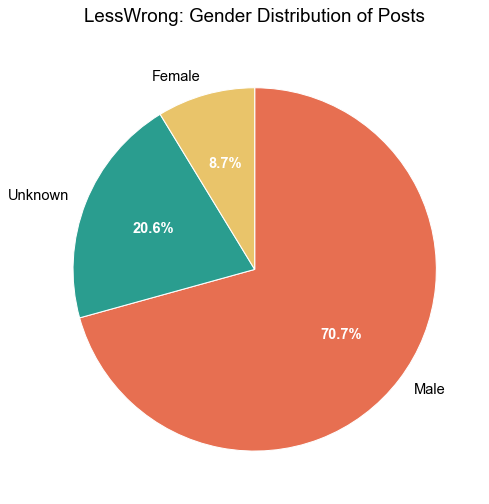


Unique Users by Gender:
Male: 3,579 (57.8%)
Unknown: 2,078 (33.5%)
Female: 540 (8.7%)


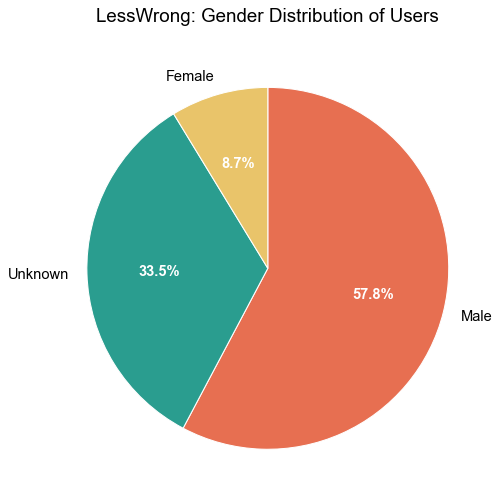

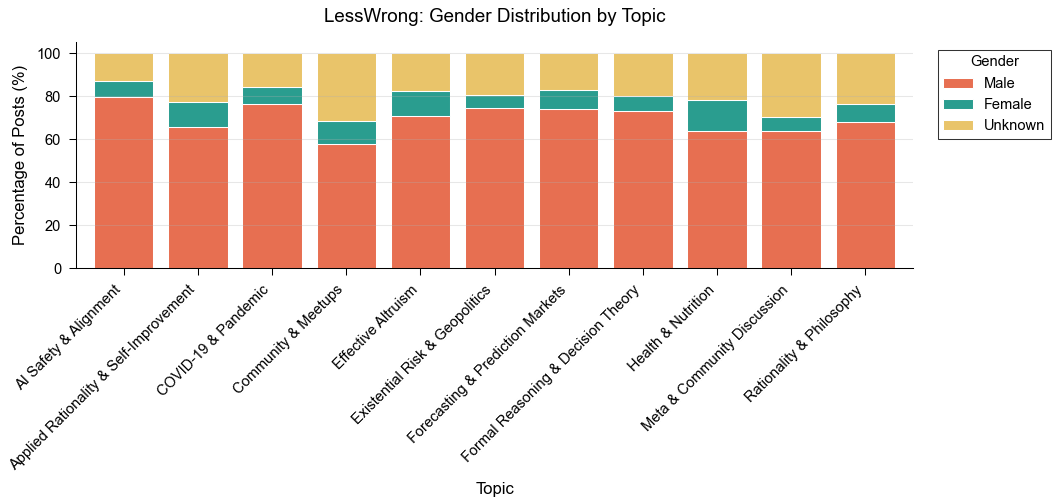


--- Alignment Forum ---

Gender Distribution:
Male: 3,735 (88.6%)
Female: 356 (8.4%)
Unknown: 124 (2.9%)


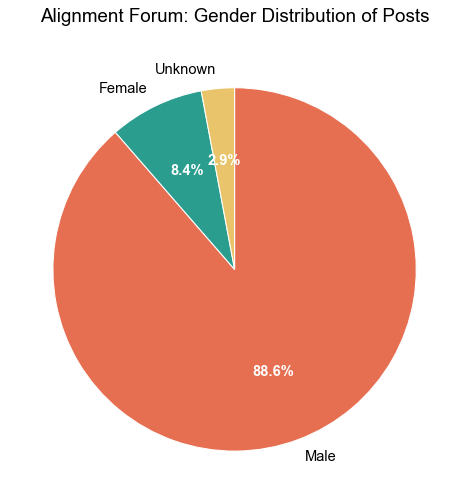


Unique Users by Gender:
Male: 496 (79.9%)
Female: 64 (10.3%)
Unknown: 61 (9.8%)


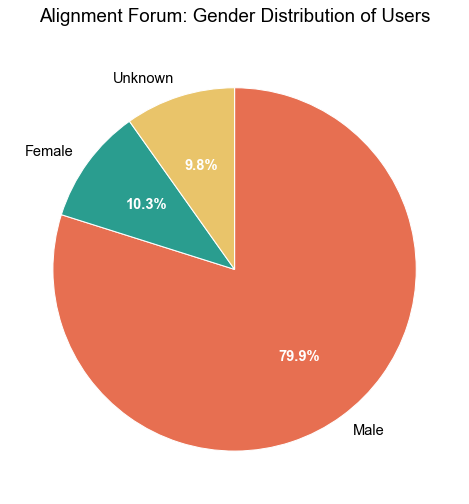

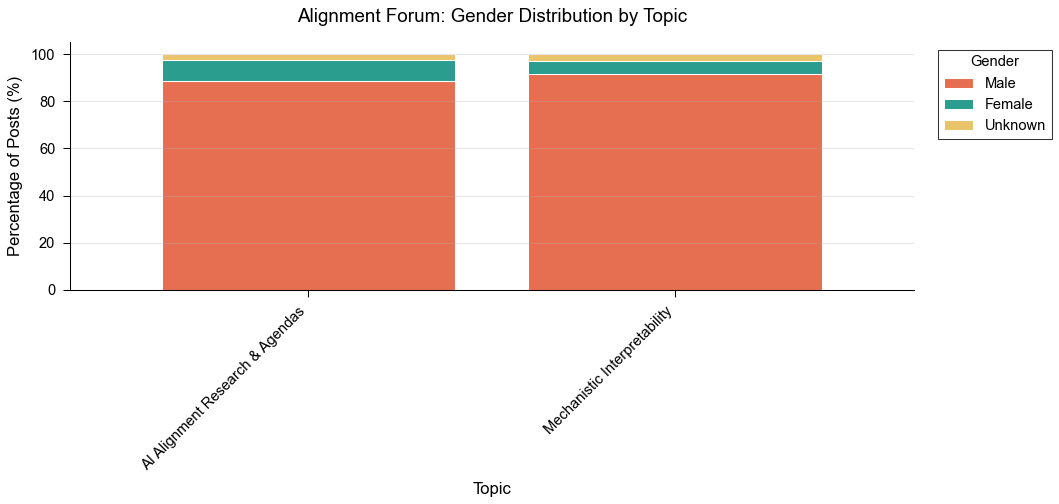


--- Combined ---

Gender Distribution:
Male: 34,456 (72.3%)
Unknown: 9,068 (19.0%)
Female: 4,142 (8.7%)


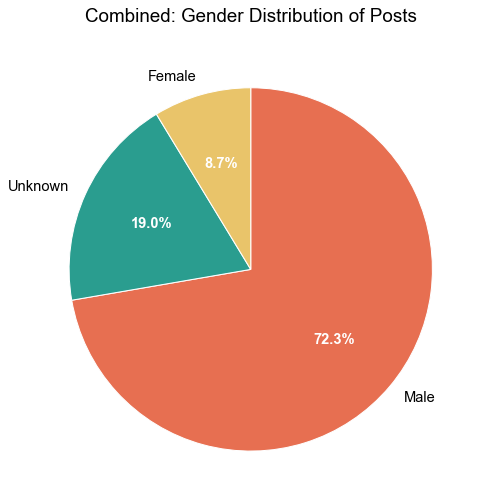


Unique Users by Gender:
Male: 3,579 (57.8%)
Unknown: 2,078 (33.5%)
Female: 540 (8.7%)


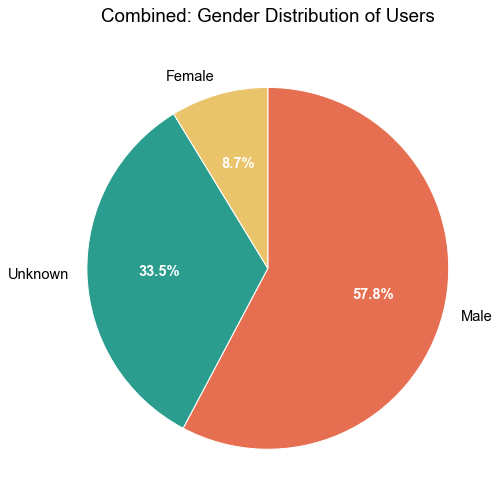

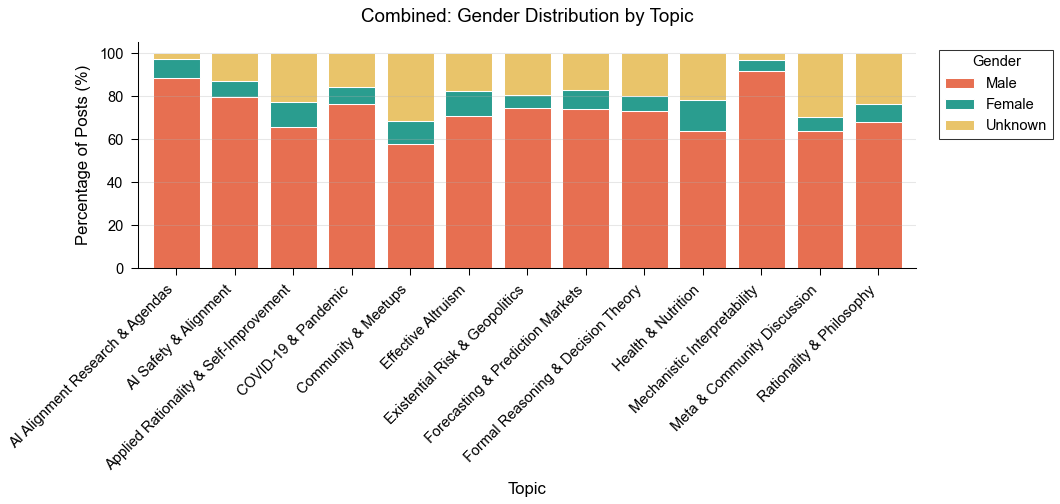


=== Gender analysis complete ===


In [20]:
"""Analyze gender distribution"""
print("\n=== GENDER ANALYSIS ===")

# Load authors table to get gender information
authors_df = pd.read_csv("../data/nodes_forum_authors.csv")

# Use data already loaded from nodes_forum_posts.csv
lesswrong_df = posts_df[posts_df['source'] == 'lesswrong'].copy()
alignment_forum_df = posts_df[posts_df['source'] == 'alignment_forum'].copy()
combined_df = posts_df.copy()

# Merge with authors to get gender
lesswrong_df = lesswrong_df.merge(
    authors_df[['author_username', 'author_gender_inferred']], 
    on='author_username', 
    how='left'
)
alignment_forum_df = alignment_forum_df.merge(
    authors_df[['author_username', 'author_gender_inferred']], 
    on='author_username', 
    how='left'
)
combined_df = combined_df.merge(
    authors_df[['author_username', 'author_gender_inferred']], 
    on='author_username', 
    how='left'
)

for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df), ("Combined", combined_df)]:
    
    print(f"\n--- {platform_name} ---")
    
    gender_counts = platform_df['author_gender_inferred'].value_counts()
    print(f"\nGender Distribution:")
    for gender, count in gender_counts.items():
        percentage = (count / len(platform_df)) * 100
        gender_label = {'gm': 'Male', 'gf': 'Female', '-': 'Unknown'}.get(gender, gender)
        print(f"{gender_label}: {count:,} ({percentage:.1f}%)")
    
    # Gender posts pie chart - use SINGLE_COL for pie charts
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    
    # Map gender codes to readable labels for display
    display_labels = [{'gm': 'Male', 'gf': 'Female', '-': 'Unknown'}.get(g, g) 
                      for g in gender_counts.index]
    
    wedges, texts, autotexts = ax.pie(
        gender_counts.values, 
        labels=display_labels, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=["#e76f51", "#2a9d8f", "#e9c46a"], 
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False,
        textprops={'fontsize': 7}
    )
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(7)
    
    ax.set_title(f'{platform_name}: Gender Distribution of Posts', pad=10, fontsize=9)
    safe_name = platform_name.lower().replace(" ", "_")
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Gender users pie chart
    unique_users = platform_df[['author_username', 'author_gender_inferred']].drop_duplicates()
    user_gender_counts = unique_users['author_gender_inferred'].value_counts()
    
    print(f"\nUnique Users by Gender:")
    for gender, count in user_gender_counts.items():
        percentage = (count / len(unique_users)) * 100
        gender_label = {'gm': 'Male', 'gf': 'Female', '-': 'Unknown'}.get(gender, gender)
        print(f"{gender_label}: {count:,} ({percentage:.1f}%)")
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    
    # Map gender codes to readable labels for display
    display_labels = [{'gm': 'Male', 'gf': 'Female', '-': 'Unknown'}.get(g, g) 
                      for g in user_gender_counts.index]
    
    wedges, texts, autotexts = ax.pie(
        user_gender_counts.values, 
        labels=display_labels,
        autopct='%1.1f%%', 
        startangle=90,
        colors=["#e76f51", "#2a9d8f", "#e9c46a"], 
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False,
        textprops={'fontsize': 7}
    )
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(7)
    
    ax.set_title(f'{platform_name}: Gender Distribution of Users', pad=10, fontsize=9)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Gender distribution by topics - use DOUBLE_COL for bar charts
    filtered_df = platform_df[platform_df['topic_label'].notna()].copy()
    
    if len(filtered_df) > 0:
        gender_topic = filtered_df.groupby(['topic_label', 'author_gender_inferred']).size().unstack(fill_value=0)
        gender_topic['total'] = gender_topic.sum(axis=1)
        
        # Build gender percentage data with proper column mapping
        gender_perc_data = {}
        if 'gm' in gender_topic.columns:
            gender_perc_data['Male'] = (gender_topic['gm'] * 100) / gender_topic['total']
        if 'gf' in gender_topic.columns:
            gender_perc_data['Female'] = (gender_topic['gf'] * 100) / gender_topic['total']
        if '-' in gender_topic.columns:
            gender_perc_data['Unknown'] = (gender_topic['-'] * 100) / gender_topic['total']
        
        gender_perc = pd.DataFrame(gender_perc_data)
        
        fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
        gender_perc.plot(kind="bar", ax=ax,
                         color=["#e76f51", "#2a9d8f", "#e9c46a"],
                         stacked=True,
                         width=0.8,
                         edgecolor='white',
                         linewidth=0.5)
        
        ax.set_title(f'{platform_name}: Gender Distribution by Topic', pad=10, fontsize=9)
        ax.set_ylabel('Percentage of Posts (%)', fontsize=8)
        ax.set_xlabel('Topic', fontsize=8)
        ax.legend(title='Gender', bbox_to_anchor=(1.02, 1), loc='upper left', 
                  frameon=True, edgecolor='black', fancybox=False,
                  fontsize=7, title_fontsize=7)
        ax.set_xticklabels(gender_perc.index, rotation=45, ha='right', fontsize=7)
        ax.tick_params(axis='y', labelsize=7)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        plt.close()

print("\n=== Gender analysis complete ===")

### Validation

In [21]:
# Load the manually curated usernames to exclude from validation
print("Loading manually curated usernames...")
with open("../src/metadata/graphql_usernames.json", "r", encoding="utf-8") as f:
    names_data = json.load(f)

manually_verified_usernames = set(names_data.get("MALE_USERNAMES", [])) | set(names_data.get("FEMALE_USERNAMES", []))
print(f"Found {len(manually_verified_usernames)} manually verified usernames to exclude")

# Load data from final dataset
posts_df = pd.read_csv("../data/nodes_forum_posts.csv")
authors_df = pd.read_csv("../data/nodes_forum_authors.csv")

# Merge posts with authors to get gender
posts_with_gender = posts_df.merge(
    authors_df[['author_username', 'author_gender_inferred']], 
    on='author_username', 
    how='left'
)

# Separate by platform and add platform label
lesswrong_df = posts_with_gender[posts_with_gender['source'] == 'lesswrong'].assign(platform='LessWrong')
alignment_forum_df = posts_with_gender[posts_with_gender['source'] == 'alignment_forum'].assign(platform='Alignment Forum')

# Combine both platforms
combined_df = pd.concat([lesswrong_df, alignment_forum_df], ignore_index=True)

print(f"\nTotal posts before filtering: {len(combined_df):,}")

# Filter out *authors* whose names were already manually curated
# We check if the username (lowercased) is in the manually verified list
combined_df['username_lower'] = combined_df['author_username'].str.lower()

# Get unique authors (from the authors table, not posts)
all_authors_df = authors_df.copy()

# Authors to exclude (already manually verified)
all_authors_df['username_lower'] = all_authors_df['author_username'].str.lower()
excluded_authors_df = all_authors_df[all_authors_df['username_lower'].isin(manually_verified_usernames)]
authors_excluded_count = len(excluded_authors_df)

# Authors remaining for validation
validation_authors_df = all_authors_df[~all_authors_df['username_lower'].isin(manually_verified_usernames)].copy()

print(f"Authors excluded (manually verified users): {authors_excluded_count:,}")
print(f"Authors remaining for validation: {len(validation_authors_df):,}")

TOTAL_VALIDATION_SAMPLES = 360

# The statistical analysis should now be based on the AUTHOR population size
print_sample_size_analysis(
    population_size=len(validation_authors_df),
    sample_size=TOTAL_VALIDATION_SAMPLES,
    confidence=CONFIDENCE_LEVEL,
    margin_error=MARGIN_OF_ERROR
)

print(f"\n{'='*80}")
print("GENDER DISTRIBUTION (based on unique authors)")
print(f"{'='*80}")

# Get gender counts and proportions for UNIQUE AUTHORS
gender_counts = validation_authors_df["author_gender_inferred"].value_counts()
gender_proportions = gender_counts / len(validation_authors_df)

print(f"\n{'Gender':<20} {'Count':>10} {'%':>7} {'Samples':>8}")
print("-" * 80)

for gender, count in gender_counts.items():
    proportion = count / len(validation_authors_df)
    n_samples = round(TOTAL_VALIDATION_SAMPLES * proportion)
    gender_label = {'gm': 'Male', 'gf': 'Female', '-': 'Unknown'}.get(gender, gender)
    print(f"{gender_label:<20} {count:>10,} {proportion*100:>6.1f}% {n_samples:>8}")

print("-" * 80)
print(f"{'TOTAL':<20} {len(validation_authors_df):>10,} {100.0:>6.1f}% {TOTAL_VALIDATION_SAMPLES:>8}")
print(f"\nNote: Final allocation will be adjusted to ensure exactly {TOTAL_VALIDATION_SAMPLES} samples")

# Stratified sampling by gender (on unique authors)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Calculate proportional samples for each gender
sample_allocation = {}
allocated_so_far = 0

for i, (gender, count) in enumerate(gender_counts.items()):
    if i == len(gender_counts) - 1:
        # Last category gets the remainder to ensure we hit exactly TOTAL_VALIDATION_SAMPLES
        n_samples = TOTAL_VALIDATION_SAMPLES - allocated_so_far
    else:
        # Proportional allocation with rounding
        n_samples = round(TOTAL_VALIDATION_SAMPLES * count / len(validation_authors_df))
        allocated_so_far += n_samples
    
    sample_allocation[gender] = max(1, n_samples)  # Ensure at least 1 sample per gender

print(f"\n{'='*80}")
print("SAMPLE ALLOCATION (after adjusting for rounding)")
print(f"{'='*80}")
print(f"{'Gender':<20} {'Allocated Samples':>20}")
print("-" * 80)
total_allocated = 0
for gender in gender_counts.index:
    n = sample_allocation[gender]
    gender_label = {'gm': 'Male', 'gf': 'Female', '-': 'Unknown'}.get(gender, gender)
    print(f"{gender_label:<20} {n:>20}")
    total_allocated += n
print("-" * 80)
print(f"{'TOTAL':<20} {total_allocated:>20}")
print(f"{'='*80}")

sampled_authors = []

for gender in gender_counts.index:
    gender_authors_df = validation_authors_df[validation_authors_df["author_gender_inferred"] == gender]
    n_samples = sample_allocation[gender]
    
    # Sample unique authors randomly
    if len(gender_authors_df) >= n_samples:
        sampled = gender_authors_df.sample(n=n_samples, random_state=RANDOM_SEED)
    else:
        sampled = gender_authors_df
    
    sampled_authors.append(sampled)

sampled_authors_df = pd.concat(sampled_authors, ignore_index=True)

# Now, select one representative post for each sampled author.
# Get the first post for each author from combined_df
validation_set = pd.merge(
    sampled_authors_df[['author_username', 'author_display_name', 'author_gender_inferred']],
    combined_df.drop_duplicates(subset=['author_username'], keep='first'),
    on='author_username',
    how='left'
)

# Keep only the author-level gender (they should match anyway)
validation_set = validation_set.rename(columns={'author_gender_inferred_x': 'author_gender_inferred'})
validation_set = validation_set.drop(columns=['author_gender_inferred_y', 'username_lower'], errors='ignore')

# Shuffle the validation set
validation_set = validation_set.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Keep only essential columns for validation
columns_to_keep = ['author_username', 'author_display_name', 'author_gender_inferred', 'platform']
validation_set = validation_set[[col for col in columns_to_keep if col in validation_set.columns]]

print(f"\n{'='*80}")
print("VALIDATION SET CREATED")
print(f"{'='*80}")
print(f"Total validation samples: {len(validation_set)}")
print(f"\nActual samples per gender:")
gender_dist = validation_set["author_gender_inferred"].value_counts().sort_index()
for gender, count in gender_dist.items():
    gender_label = {'gm': 'Male', 'gf': 'Female', '-': 'Unknown'}.get(gender, gender)
    print(f"  {gender_label}: {count}")

# Add columns for manual validation
validation_set['validation_correct'] = ''  # To be filled: 'yes', 'no', 'unsure'
validation_set['validation_notes'] = ''
validation_set['validation_alternative_gender'] = ''  # If incorrect, what should it be?

# Save to CSV for validation
output_file = 'gender_validation_set.csv'
validation_set.to_csv(output_file, index=False)
print(f"\n✓ Saved validation set to: {output_file}")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("1. Open 'gender_validation_set.csv' in Excel/Google Sheets")
print("2. For each row, check the username/display name and fill in:")
print("   - validation_correct: 'yes', 'no', or 'unsure'")
print("   - validation_notes: Any comments (e.g., profile link, pronoun usage)")
print("   - validation_alternative_gender: If 'no', what should the gender be?")
print("3. Save the file and run the analysis script to calculate:")
print("   - Overall accuracy with confidence intervals")
print("   - Per-gender precision and recall")
print("   - Confusion matrix")
print("   - Inter-rater reliability (if multiple raters)")
print("\nNote: Check user profiles at:")
print("  LessWrong: https://lesswrong.com/users/<username>")
print("  Alignment Forum: https://alignmentforum.org/users/<username>")
print("\nOptional: Share the CSV with another rater for inter-rater reliability!")
print("="*80)

Loading manually curated usernames...
Found 723 manually verified usernames to exclude

Total posts before filtering: 47,666
Authors excluded (manually verified users): 689
Authors remaining for validation: 5,509

STATISTICAL POWER ANALYSIS

Population size: 5,509
Actual sample size: 360
Confidence level: 95.0%
Target margin of error: ±5.0%

--- Required Sample Sizes ---
Conservative estimate (p=0.5): 360
Optimistic estimate (p=0.85): 190

✓ Sample size is ADEQUATE (exceeds conservative requirement)

With 360 samples, you can estimate accuracy within:
  ±5.17% at 95% confidence (conservative)

--- Expected Confidence Intervals ---
If observed accuracy is:
  70.0%: 95% CI = [65.3%, 74.7%]
  75.0%: 95% CI = [70.5%, 79.5%]
  80.0%: 95% CI = [75.9%, 84.1%]
  85.0%: 95% CI = [81.3%, 88.7%]
  90.0%: 95% CI = [86.9%, 93.1%]
  95.0%: 95% CI = [92.7%, 97.3%]


GENDER DISTRIBUTION (based on unique authors)

Gender                    Count       %  Samples
----------------------------------------

In [22]:
# Load the annotated validation set
validation_df = pd.read_csv('gender_validation_set_annotated.csv')

In [23]:
# ============================================================================
# 1. OVERALL ACCURACY
# ============================================================================
print("\n" + "="*80)
print("1. OVERALL ACCURACY")
print("="*80)

# Count validation responses
validation_counts = validation_df['validation_correct'].value_counts()
total_validated = len(validation_df[validation_df['validation_correct'].isin(['yes', 'no', 'unsure'])])

if total_validated == 0:
    print("⚠️  No validation responses found. Please check the CSV file.")
else:
    accuracy = (validation_counts.get('yes', 0) / total_validated) * 100
    error_rate = (validation_counts.get('no', 0) / total_validated) * 100
    unsure_rate = (validation_counts.get('unsure', 0) / total_validated) * 100
    
    print(f"\nTotal Validated Samples: {total_validated}")
    print(f"\n✓ Correct (yes):  {validation_counts.get('yes', 0):3d} ({accuracy:.1f}%)")
    print(f"✗ Incorrect (no): {validation_counts.get('no', 0):3d} ({error_rate:.1f}%)")
    print(f"? Unsure:         {validation_counts.get('unsure', 0):3d} ({unsure_rate:.1f}%)")
    
    print(f"\n{'='*50}")
    print(f"OVERALL ACCURACY: {accuracy:.1f}%")
    print(f"{'='*50}")


1. OVERALL ACCURACY

Total Validated Samples: 360

✓ Correct (yes):  343 (95.3%)
✗ Incorrect (no):  17 (4.7%)
? Unsure:           0 (0.0%)

OVERALL ACCURACY: 95.3%


In [24]:
# ============================================================================
# 2. ACCURACY BY GENDER
# ============================================================================
print("\n" + "="*80)
print("2. ACCURACY BY GENDER")
print("="*80)

gender_accuracy = []

for gender in validation_df['user_gender'].unique():
    gender_df = validation_df[validation_df['user_gender'] == gender]
    gender_validated = gender_df[gender_df['validation_correct'].isin(['yes', 'no', 'unsure'])]
    
    if len(gender_validated) > 0:
        correct = len(gender_validated[gender_validated['validation_correct'] == 'yes'])
        incorrect = len(gender_validated[gender_validated['validation_correct'] == 'no'])
        unsure = len(gender_validated[gender_validated['validation_correct'] == 'unsure'])
        total = len(gender_validated)
        accuracy_pct = (correct / total) * 100
        
        gender_accuracy.append({
            'gender': gender,
            'correct': correct,
            'incorrect': incorrect,
            'unsure': unsure,
            'total': total,
            'accuracy': accuracy_pct
        })

gender_accuracy_df = pd.DataFrame(gender_accuracy).sort_values('accuracy', ascending=False)

print("\nAccuracy by Gender (sorted by accuracy):\n")
print(f"{'Gender':<20} {'Correct':<10} {'Incorrect':<10} {'Unsure':<10} {'Total':<10} {'Accuracy'}")
print("-" * 75)

for _, row in gender_accuracy_df.iterrows():
    print(f"{row['gender']:<20} {row['correct']:<10} {row['incorrect']:<10} {row['unsure']:<10} {row['total']:<10} {row['accuracy']:.1f}%")



2. ACCURACY BY GENDER

Accuracy by Gender (sorted by accuracy):

Gender               Correct    Incorrect  Unsure     Total      Accuracy
---------------------------------------------------------------------------
-                    136        0          0          136        100.0%
gm                   182        13         0          195        93.3%
gf                   25         4          0          29         86.2%


In [25]:
# ============================================================================
# 3. CONFUSION MATRIX
# ============================================================================
print("\n" + "="*80)
print("3. CONFUSION MATRIX (Misclassified Genders)")
print("="*80)

# Get misclassified samples
misclassified = validation_df[validation_df['validation_correct'] == 'no'].copy()

if len(misclassified) > 0:
    print(f"\nTotal Misclassifications: {len(misclassified)}\n")
    
    # Create confusion matrix
    confusion_patterns = misclassified.groupby(['user_gender', 'validation_alternative_gender']).size().reset_index(name='count')
    confusion_patterns = confusion_patterns.sort_values('count', ascending=False)
    
    print("Confusion Patterns (Predicted → Actual):\n")
    print(f"{'Predicted Gender':<20} {'Actual Gender':<20} {'Count'}")
    print("-" * 50)
    
    for _, row in confusion_patterns.iterrows():
        print(f"{row['user_gender']:<20} {row['validation_alternative_gender']:<20} {row['count']}")
    
    # Genders most often misclassified
    print("\n" + "-" * 50)
    print("Genders Most Often Misclassified:\n")
    
    misclass_by_gender = misclassified['user_gender'].value_counts()
    for gender, count in misclass_by_gender.items():
        total_samples = len(validation_df[validation_df['user_gender'] == gender])
        error_rate = (count / total_samples) * 100
        print(f"{gender:<20} {count:3d} errors ({error_rate:.1f}% of {total_samples} samples)")
    
    # Create confusion matrix visualization
    print("\n" + "-" * 50)
    print("Detailed Confusion Matrix:\n")
    
    # Get all unique gender categories
    all_genders = sorted(set(validation_df['user_gender'].unique()) | 
                        set(misclassified['validation_alternative_gender'].dropna().unique()))
    
    # Build confusion matrix
    confusion_matrix = pd.DataFrame(0, index=all_genders, columns=all_genders)
    
    # Fill in correct classifications
    for gender in validation_df['user_gender'].unique():
        correct_count = len(validation_df[(validation_df['user_gender'] == gender) & 
                                         (validation_df['validation_correct'] == 'yes')])
        confusion_matrix.loc[gender, gender] = correct_count
    
    # Fill in misclassifications
    for _, row in misclassified.iterrows():
        if pd.notna(row['validation_alternative_gender']):
            predicted = row['user_gender']
            actual = row['validation_alternative_gender']
            if predicted in confusion_matrix.index and actual in confusion_matrix.columns:
                confusion_matrix.loc[predicted, actual] += 1
    
    print(confusion_matrix)
    
else:
    print("\n✓ No misclassifications found!")
    confusion_matrix = None


3. CONFUSION MATRIX (Misclassified Genders)

Total Misclassifications: 17

Confusion Patterns (Predicted → Actual):

Predicted Gender     Actual Gender        Count
--------------------------------------------------
gm                   -                    13
gf                   -                    4

--------------------------------------------------
Genders Most Often Misclassified:

gm                    13 errors (6.7% of 195 samples)
gf                     4 errors (13.8% of 29 samples)

--------------------------------------------------
Detailed Confusion Matrix:

      -  gf   gm
-   136   0    0
gf    4  25    0
gm   13   0  182


In [26]:
# ============================================================================
# 4. UNSURE/AMBIGUOUS CASES
# ============================================================================
print("\n" + "="*80)
print("4. UNSURE/AMBIGUOUS CASES")
print("="*80)

unsure_cases = validation_df[validation_df['validation_correct'] == 'unsure']

if len(unsure_cases) > 0:
    print(f"\nTotal Unsure Cases: {len(unsure_cases)}\n")
    
    unsure_by_gender = unsure_cases['user_gender'].value_counts()
    print("Unsure Cases by Gender:\n")
    
    for gender, count in unsure_by_gender.items():
        total_samples = len(validation_df[validation_df['user_gender'] == gender])
        unsure_rate = (count / total_samples) * 100
        print(f"{gender:<20} {count:3d} unsure ({unsure_rate:.1f}% of {total_samples} samples)")
    
    # Show some examples of unsure cases
    print("\n" + "-" * 50)
    print("Sample Unsure Cases (with usernames):\n")
    
    for _, row in unsure_cases.head(10).iterrows():
        print(f"• Username: {row.get('user.username', 'N/A')}")
        print(f"  Predicted: {row['user_gender']}")
        if pd.notna(row['validation_notes']) and row['validation_notes'] != '':
            print(f"  Note: {row['validation_notes']}")
        print()
else:
    print("\n✓ No unsure cases!")


4. UNSURE/AMBIGUOUS CASES

✓ No unsure cases!


In [27]:
# ============================================================================
# 7. PERFORMANCE METRICS
# ============================================================================
print("\n" + "="*80)
print("7. DETAILED PERFORMANCE METRICS")
print("="*80)

if len(misclassified) > 0:
    print("\nPer-Gender Precision, Recall, and F1-Score:\n")
    print(f"{'Gender':<20} {'Precision':<12} {'Recall':<12} {'F1-Score'}")
    print("-" * 60)
    
    for gender in validation_df['user_gender'].unique():
        # True Positives: correctly predicted as this gender
        tp = len(validation_df[(validation_df['user_gender'] == gender) & 
                              (validation_df['validation_correct'] == 'yes')])
        
        # False Positives: incorrectly predicted as this gender
        fp = len(misclassified[(misclassified['user_gender'] == gender)])
        
        # False Negatives: actually this gender but predicted as something else
        fn = len(misclassified[misclassified['validation_alternative_gender'] == gender])
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"{gender:<20} {precision:<12.3f} {recall:<12.3f} {f1:.3f}")



7. DETAILED PERFORMANCE METRICS

Per-Gender Precision, Recall, and F1-Score:

Gender               Precision    Recall       F1-Score
------------------------------------------------------------
-                    1.000        0.889        0.941
gm                   0.933        1.000        0.966
gf                   0.862        1.000        0.926



8. CREATING VISUALIZATIONS

✓ Saved visualization to: gender_validation_analysis.png


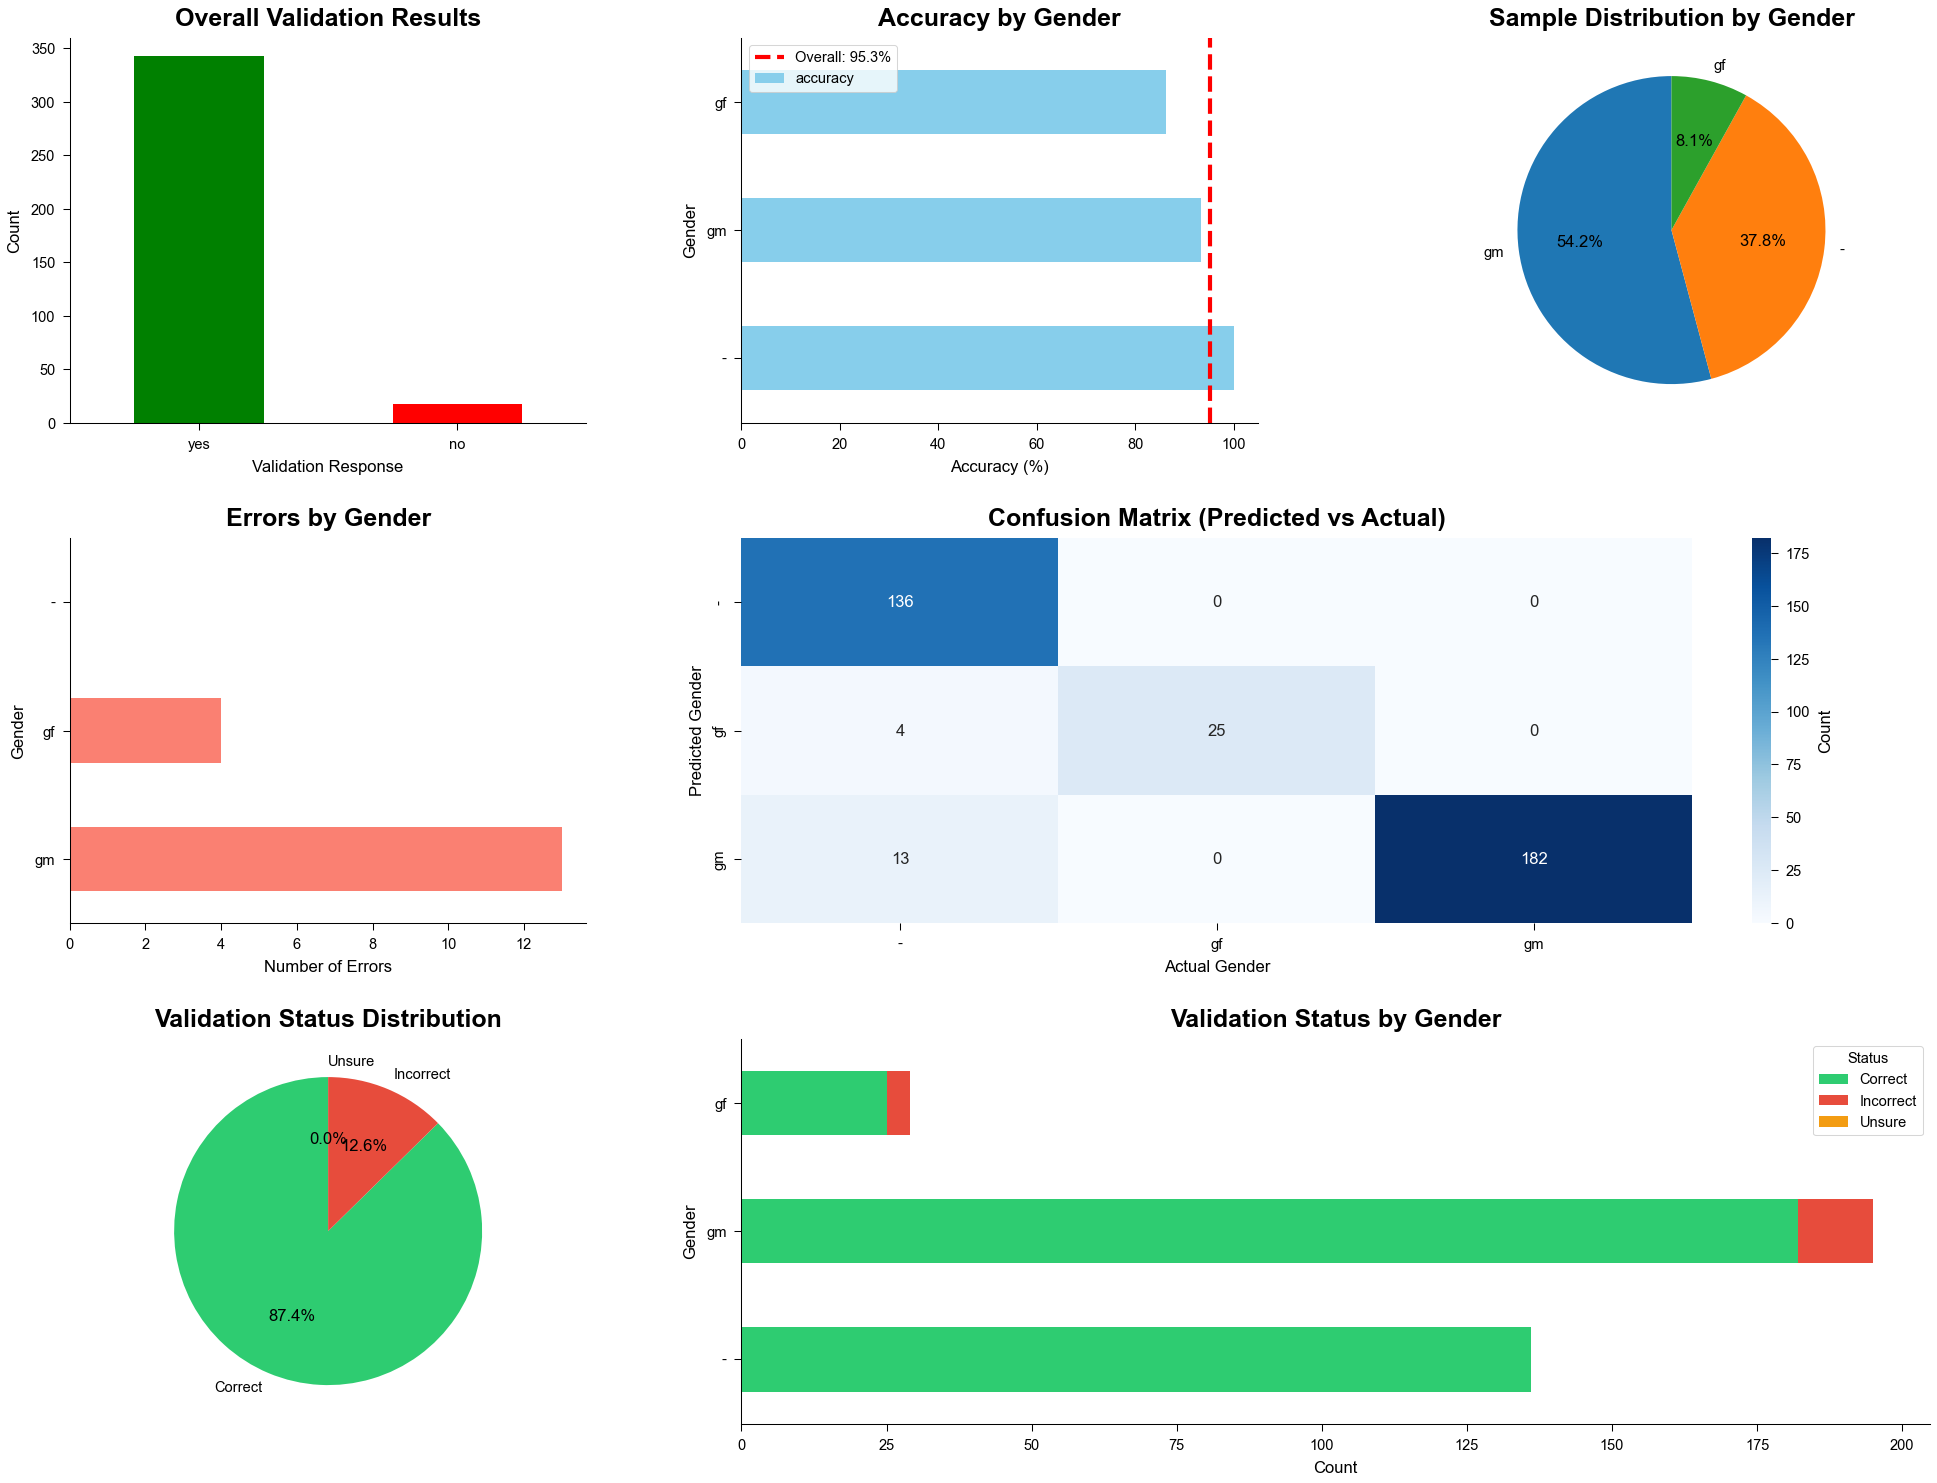

In [28]:
# ============================================================================
# 8. VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("8. CREATING VISUALIZATIONS")
print("="*80)

# Create visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Overall validation distribution
ax1 = fig.add_subplot(gs[0, 0])
validation_counts.plot(kind='bar', ax=ax1, color=['green', 'red', 'orange'])
ax1.set_title('Overall Validation Results', fontsize=12, fontweight='bold')
ax1.set_xlabel('Validation Response')
ax1.set_ylabel('Count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# 2. Accuracy by gender
ax2 = fig.add_subplot(gs[0, 1])
gender_accuracy_df.plot(x='gender', y='accuracy', kind='barh', ax=ax2, legend=False, color='skyblue')
ax2.set_title('Accuracy by Gender', fontsize=12, fontweight='bold')
ax2.set_xlabel('Accuracy (%)')
ax2.set_ylabel('Gender')
ax2.axvline(x=accuracy, color='red', linestyle='--', linewidth=2, label=f'Overall: {accuracy:.1f}%')
ax2.legend()

# 3. Sample distribution by gender
ax3 = fig.add_subplot(gs[0, 2])
gender_sample_dist = validation_df['user_gender'].value_counts()
ax3.pie(gender_sample_dist.values, labels=gender_sample_dist.index, autopct='%1.1f%%', startangle=90)
ax3.set_title('Sample Distribution by Gender', fontsize=12, fontweight='bold')

# 4. Error distribution by gender
ax4 = fig.add_subplot(gs[1, 0])
if len(misclassified) > 0:
    error_by_gender = gender_accuracy_df.sort_values('incorrect', ascending=False)
    error_by_gender.plot(x='gender', y='incorrect', kind='barh', ax=ax4, legend=False, color='salmon')
    ax4.set_title('Errors by Gender', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Number of Errors')
    ax4.set_ylabel('Gender')
else:
    ax4.text(0.5, 0.5, 'No Errors!', ha='center', va='center', fontsize=16, transform=ax4.transAxes)
    ax4.axis('off')

# 5. Confusion matrix heatmap
ax5 = fig.add_subplot(gs[1, 1:])
if confusion_matrix is not None and len(misclassified) > 0:
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', ax=ax5, cbar_kws={'label': 'Count'})
    ax5.set_title('Confusion Matrix (Predicted vs Actual)', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Actual Gender')
    ax5.set_ylabel('Predicted Gender')
else:
    ax5.text(0.5, 0.5, 'No Misclassifications!', ha='center', va='center', fontsize=16, transform=ax5.transAxes)
    ax5.axis('off')

# 6. Validation status pie chart
ax6 = fig.add_subplot(gs[2, 0])
status_df = pd.DataFrame({
    'Status': ['Correct', 'Incorrect', 'Unsure'],
    'Percentage': [accuracy, error_rate, unsure_rate]
})
colors_pie = ['#2ecc71', '#e74c3c', '#f39c12']
ax6.pie(status_df['Percentage'], labels=status_df['Status'], autopct='%1.1f%%', 
        colors=colors_pie, startangle=90)
ax6.set_title('Validation Status Distribution', fontsize=12, fontweight='bold')

# 7. Stacked bar chart: correct/incorrect/unsure by gender
ax7 = fig.add_subplot(gs[2, 1:])
gender_status = gender_accuracy_df.set_index('gender')[['correct', 'incorrect', 'unsure']]
gender_status.plot(kind='barh', stacked=True, ax=ax7, color=['#2ecc71', '#e74c3c', '#f39c12'])
ax7.set_title('Validation Status by Gender', fontsize=12, fontweight='bold')
ax7.set_xlabel('Count')
ax7.set_ylabel('Gender')
ax7.legend(title='Status', labels=['Correct', 'Incorrect', 'Unsure'])

print("\n✓ Saved visualization to: gender_validation_analysis.png")

## Author Analysis


=== AUTHOR ANALYSIS ===

--- LessWrong ---

Total unique authors: 6,197
Authors with only 1 post: 2,995 (48.3%)
Authors with 10+ posts: 752
Authors with 50+ posts: 138

Top 10 Most Active Authors:
  Eliezer_Yudkowsky: 1050 posts
  jkaufman: 1018 posts
  Zvi: 936 posts
  Stuart_Armstrong: 800 posts
  KatjaGrace: 621 posts
  MinibearRex: 498 posts
  Raemon: 440 posts
  lukeprog: 415 posts
  johnswentworth: 356 posts
  Kaj_Sotala: 306 posts


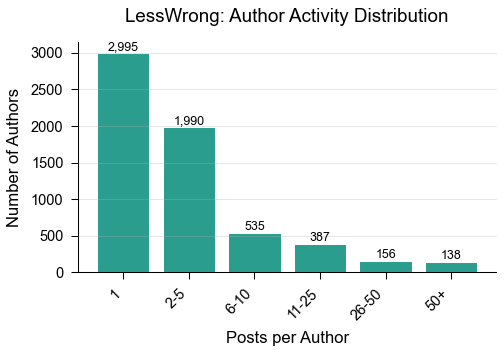

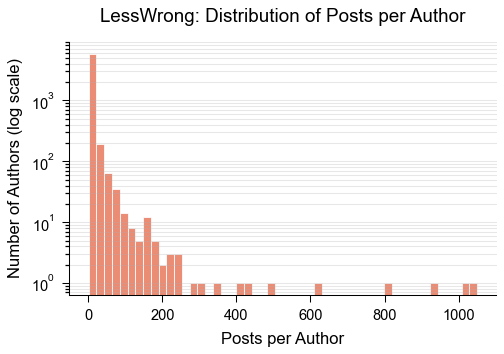


--- Alignment Forum ---

Total unique authors: 621
Authors with only 1 post: 307 (49.4%)
Authors with 10+ posts: 85
Authors with 50+ posts: 16

Top 10 Most Active Authors:
  Stuart_Armstrong: 367 posts
  rohinmshah: 206 posts
  johnswentworth: 144 posts
  abramdemski: 119 posts
  Scott Garrabrant: 101 posts
  paulfchristiano: 80 posts
  TurnTrout: 79 posts
  steve2152: 76 posts
  evhub: 70 posts
  jessica.liu.taylor: 64 posts


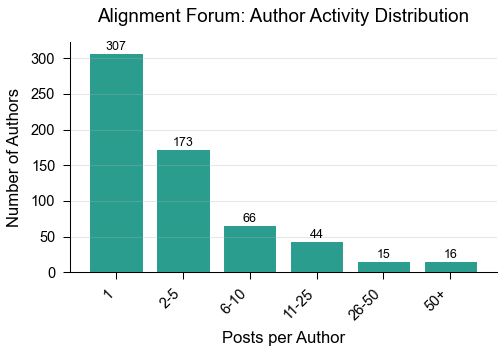

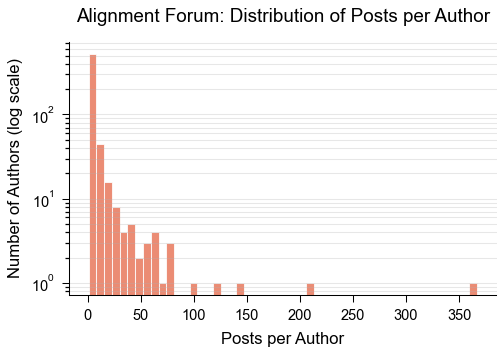


--- Combined ---

Total unique authors: 6,197
Authors with only 1 post: 2,867 (46.3%)
Authors with 10+ posts: 808
Authors with 50+ posts: 152

Top 10 Most Active Authors:
  Stuart_Armstrong: 1167 posts
  Eliezer_Yudkowsky: 1067 posts
  jkaufman: 1018 posts
  Zvi: 938 posts
  KatjaGrace: 626 posts
  johnswentworth: 500 posts
  MinibearRex: 498 posts
  Raemon: 443 posts
  lukeprog: 415 posts
  rohinmshah: 414 posts


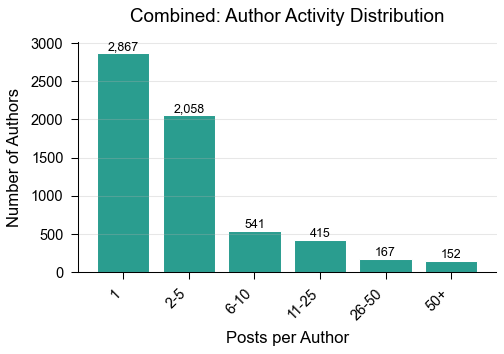

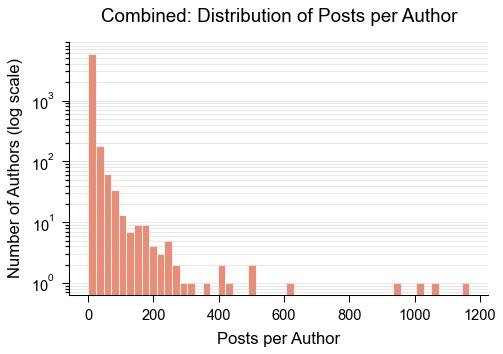


=== Author analysis complete ===


In [29]:
"""Analyze author activity patterns"""
print("\n=== AUTHOR ANALYSIS ===")

# Load data and merge with authors for complete info
posts_df = pd.read_csv("../data/nodes_forum_posts.csv")
authors_df = pd.read_csv("../data/nodes_forum_authors.csv")

# Merge posts with authors to get gender
posts_with_gender = posts_df.merge(
    authors_df[['author_username', 'author_gender_inferred']], 
    on='author_username', 
    how='left'
)

# Separate by platform
lesswrong_df = posts_with_gender[posts_with_gender['source'] == 'lesswrong'].copy()
alignment_forum_df = posts_with_gender[posts_with_gender['source'] == 'alignment_forum'].copy()
combined_df = posts_with_gender.copy()

# Analyze both platforms separately and combined
for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df), ("Combined", combined_df)]:
    
    print(f"\n--- {platform_name} ---")
    
    author_counts = platform_df['author_username'].value_counts()
    print(f"\nTotal unique authors: {len(author_counts):,}")
    print(f"Authors with only 1 post: {(author_counts == 1).sum():,} ({((author_counts == 1).sum() / len(author_counts) * 100):.1f}%)")
    print(f"Authors with 10+ posts: {(author_counts >= 10).sum():,}")
    print(f"Authors with 50+ posts: {(author_counts >= 50).sum():,}")
    
    print(f"\nTop 10 Most Active Authors:")
    for author, count in author_counts.head(10).items():
        print(f"  {author}: {count} posts")
    
    safe_name = platform_name.lower().replace(" ", "_")
    
    # Author activity distribution (bar chart)
    post_ranges = ['1', '2-5', '6-10', '11-25', '26-50', '50+']
    counts = [
        (author_counts == 1).sum(),
        ((author_counts >= 2) & (author_counts <= 5)).sum(),
        ((author_counts >= 6) & (author_counts <= 10)).sum(),
        ((author_counts >= 11) & (author_counts <= 25)).sum(),
        ((author_counts >= 26) & (author_counts <= 50)).sum(),
        (author_counts >= 50).sum()
    ]
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, 2.5))
    bars = ax.bar(post_ranges, counts, color='#2a9d8f', edgecolor='white', linewidth=0.5)
    ax.set_title(f'{platform_name}: Author Activity Distribution', pad=10, fontsize=9)
    ax.set_ylabel('Number of Authors', fontsize=8)
    ax.set_xlabel('Posts per Author', fontsize=8)
    ax.set_xticklabels(post_ranges, rotation=45, ha='right', fontsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=6)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Posts per author histogram (log scale)
    fig, ax = plt.subplots(figsize=(SINGLE_COL, 2.5))
    ax.hist(author_counts.values, bins=50, color='#e76f51', 
            edgecolor='white', alpha=0.8, linewidth=0.5)
    ax.set_xlabel('Posts per Author', fontsize=8)
    ax.set_ylabel('Number of Authors (log scale)', fontsize=8)
    ax.set_title(f'{platform_name}: Distribution of Posts per Author', pad=10, fontsize=9)
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=7)
    ax.grid(axis='y', which='both', alpha=0.3)  # Show grid for both major and minor ticks on log scale
    
    plt.tight_layout()
    plt.show()
    plt.close()

print("\n=== Author analysis complete ===")

## Temporal Trends


=== TEMPORAL TRENDS ===

--- LessWrong ---

Posts by Year:
  2006: 7 posts
  2007: 215 posts
  2008: 402 posts
  2009: 830 posts
  2010: 1,092 posts
  2011: 2,799 posts
  2012: 2,297 posts
  2013: 1,782 posts
  2014: 1,605 posts
  2015: 1,732 posts
  2016: 1,078 posts
  2017: 1,450 posts
  2018: 1,759 posts
  2019: 2,254 posts
  2020: 3,029 posts
  2021: 3,422 posts
  2022: 4,661 posts
  2023: 5,513 posts
  2024: 4,570 posts
  2025: 2,954 posts


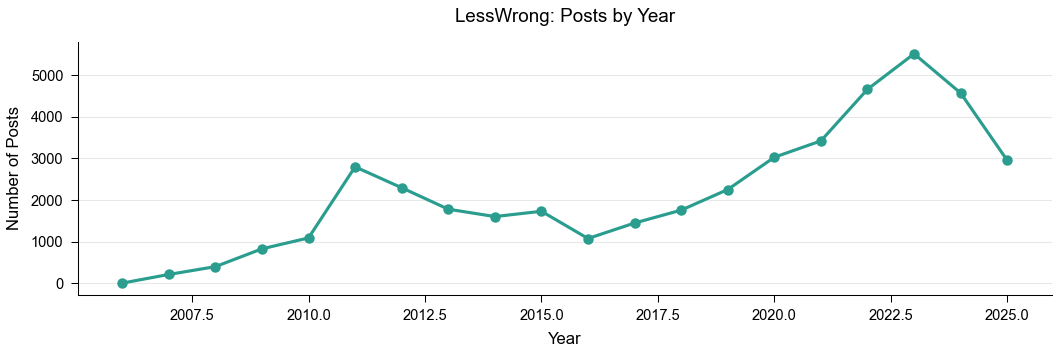

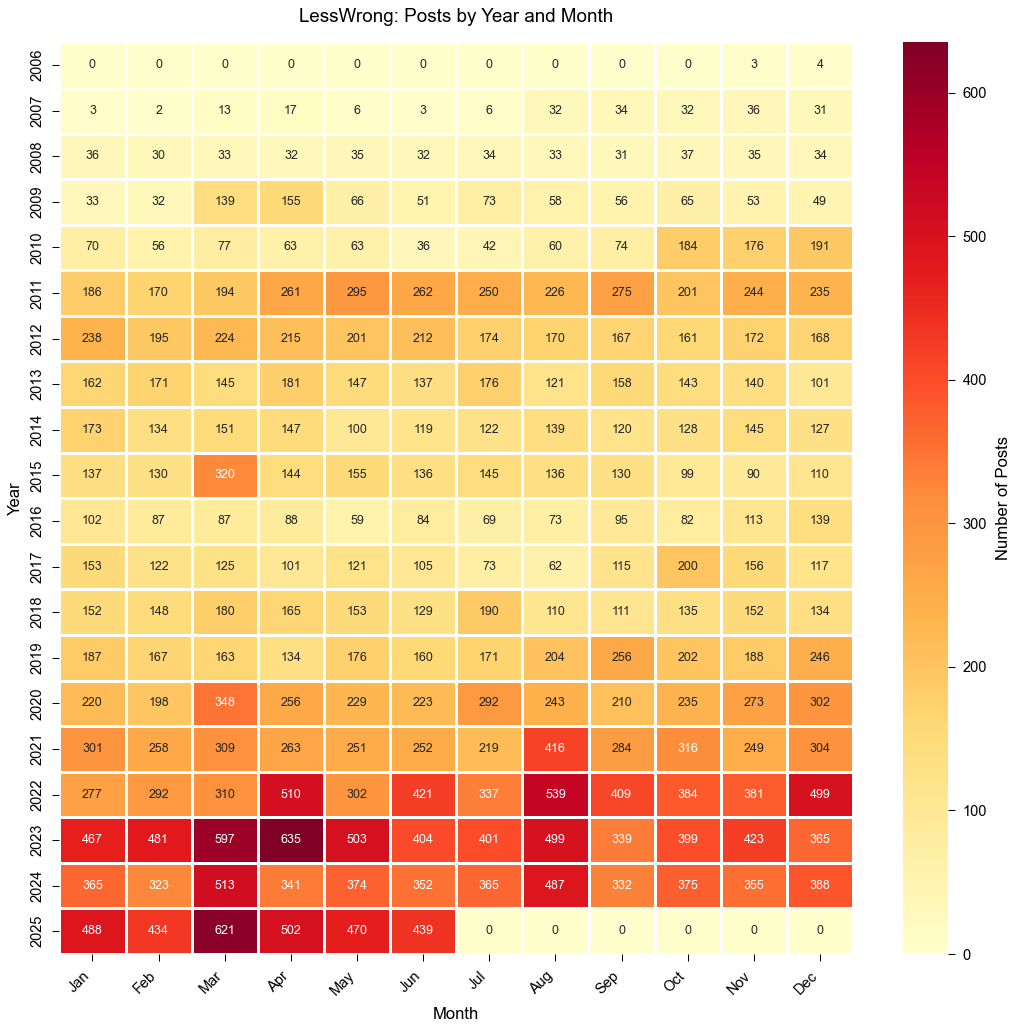

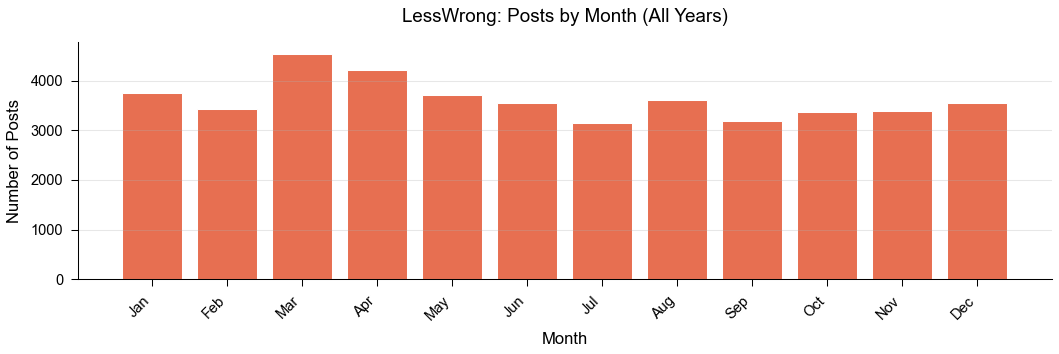


--- Alignment Forum ---

Posts by Year:
  2015: 161 posts
  2016: 121 posts
  2017: 167 posts
  2018: 257 posts
  2019: 372 posts
  2020: 442 posts
  2021: 522 posts
  2022: 705 posts
  2023: 732 posts
  2024: 426 posts
  2025: 310 posts


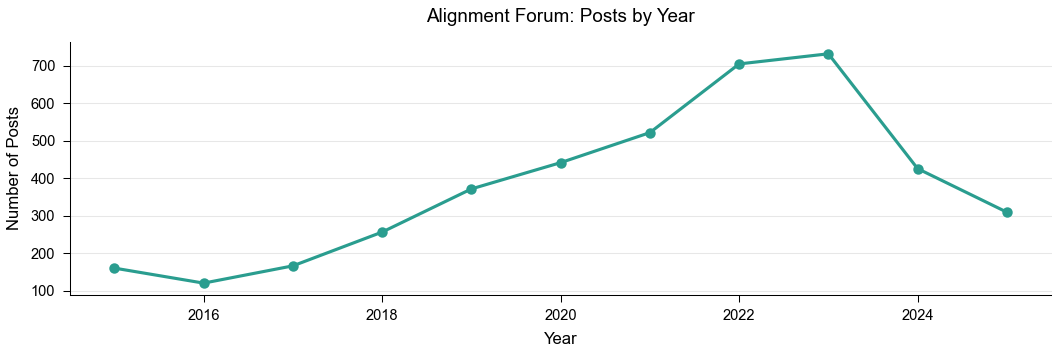

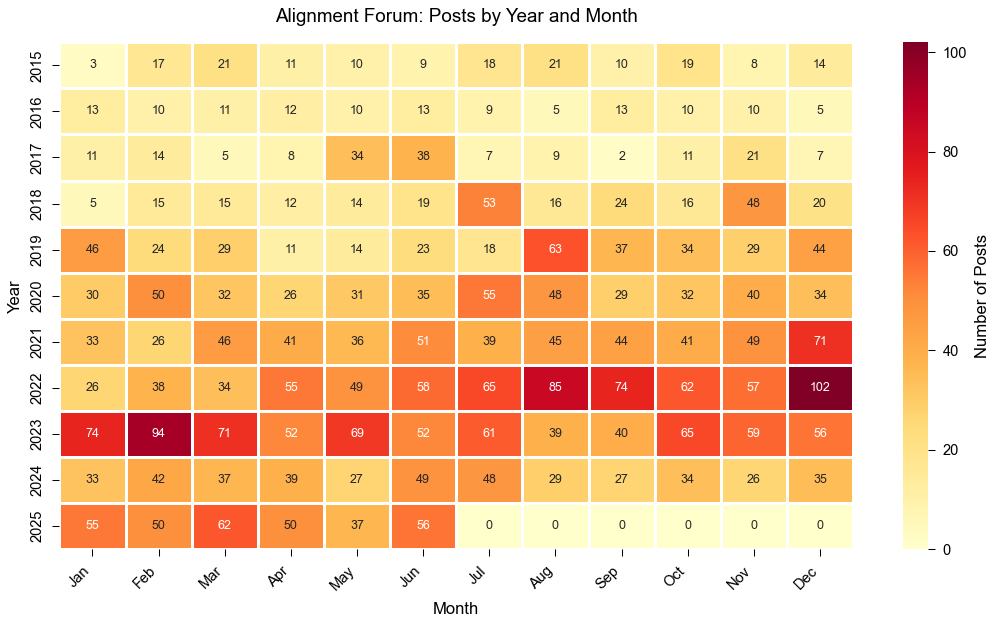

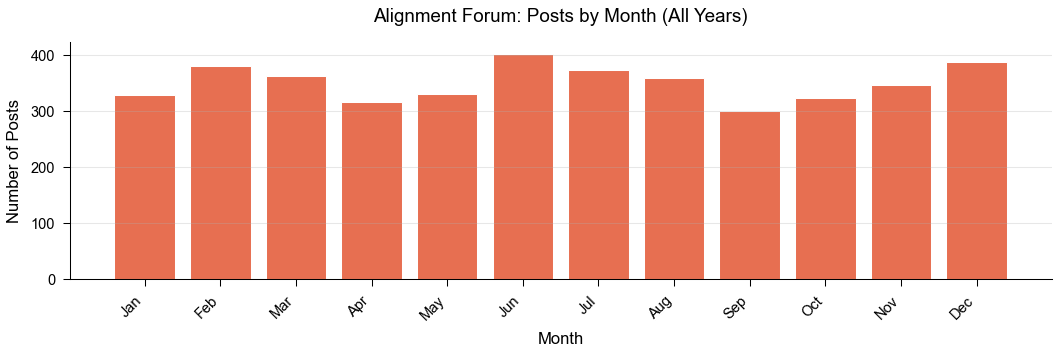


--- Combined ---

Posts by Year:
  2006: 7 posts
  2007: 215 posts
  2008: 402 posts
  2009: 830 posts
  2010: 1,092 posts
  2011: 2,799 posts
  2012: 2,297 posts
  2013: 1,782 posts
  2014: 1,605 posts
  2015: 1,893 posts
  2016: 1,199 posts
  2017: 1,617 posts
  2018: 2,016 posts
  2019: 2,626 posts
  2020: 3,471 posts
  2021: 3,944 posts
  2022: 5,366 posts
  2023: 6,245 posts
  2024: 4,996 posts
  2025: 3,264 posts


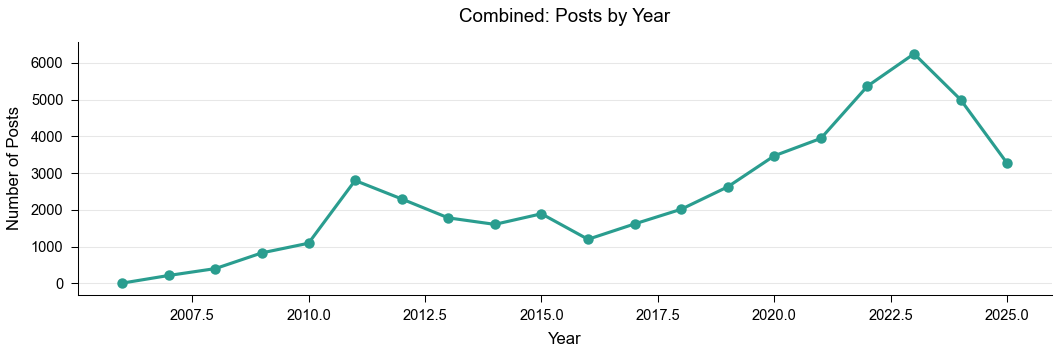

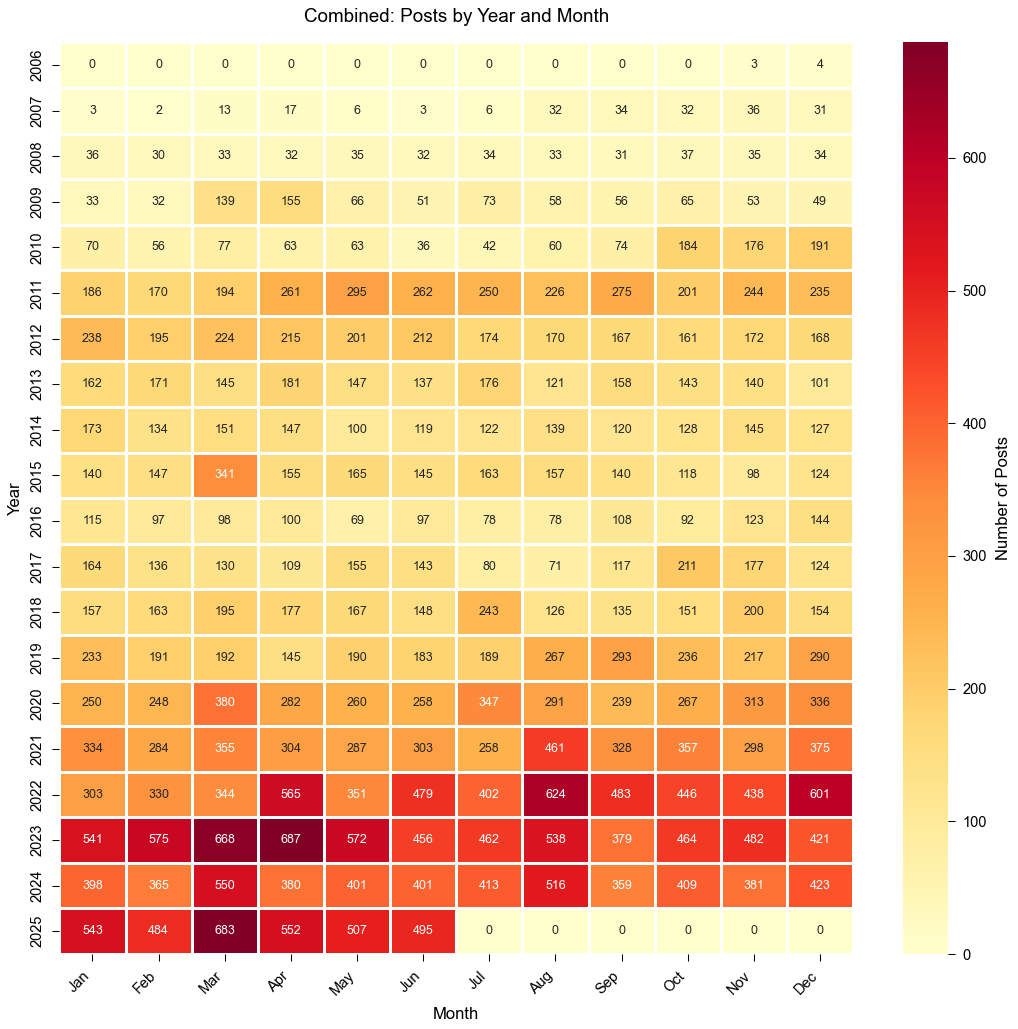

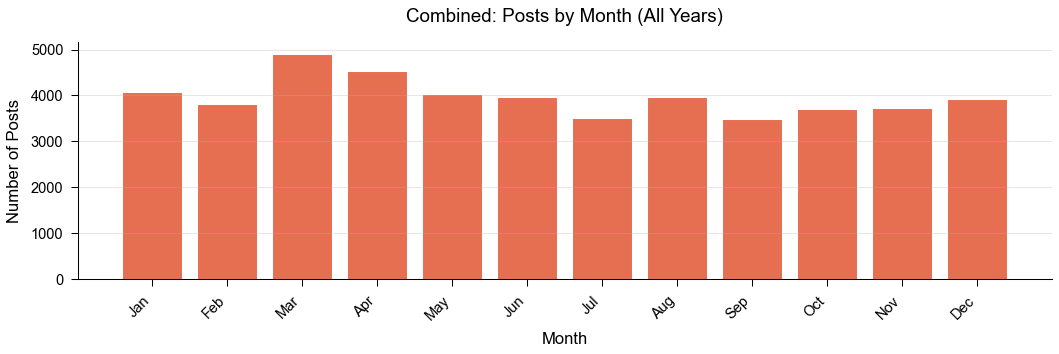


=== Temporal trends analysis complete ===


In [30]:
"""Analyze temporal trends"""
print("\n=== TEMPORAL TRENDS ===")

import seaborn as sns

# Load data and add temporal fields
posts_df = pd.read_csv("../data/nodes_forum_posts.csv")
posts_df['posted_at'] = pd.to_datetime(posts_df['posted_at'], errors='coerce')
posts_df['year'] = posts_df['posted_at'].dt.year
posts_df['month'] = posts_df['posted_at'].dt.month

# Separate by platform
lesswrong_df = posts_df[posts_df['source'] == 'lesswrong'].copy()
alignment_forum_df = posts_df[posts_df['source'] == 'alignment_forum'].copy()
combined_df = posts_df.copy()

# Analyze both platforms separately and combined
for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df), ("Combined", combined_df)]:
    
    print(f"\n--- {platform_name} ---")
    
    # Posts by year
    yearly_posts = platform_df.groupby('year').size()
    print(f"\nPosts by Year:")
    for year, count in yearly_posts.items():
        print(f"  {year}: {count:,} posts")
    
    safe_name = platform_name.lower().replace(" ", "_")
    
    # Line plot of posts over time
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 2.5))
    ax.plot(yearly_posts.index, yearly_posts.values, 
            marker='o', linewidth=1.5, markersize=4, 
            color='#2a9d8f')
    ax.set_title(f'{platform_name}: Posts by Year', pad=10, fontsize=9)
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Number of Posts', fontsize=8)
    ax.tick_params(axis='both', labelsize=7)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Heatmap of posts by year and month
    heatmap_data = platform_df.groupby(['year', 'month']).size().unstack(fill_value=0)
    
    # Ensure all months 1-12 are present
    for month in range(1, 13):
        if month not in heatmap_data.columns:
            heatmap_data[month] = 0
    heatmap_data = heatmap_data[sorted(heatmap_data.columns)]
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, len(heatmap_data) * 0.3 + 1))
    
    # Use Nature-appropriate colormap
    sns.heatmap(heatmap_data, annot=True, fmt='d', 
                cmap='YlOrRd', 
                ax=ax,
                cbar_kws={'label': 'Number of Posts'},
                linewidths=0.5,
                linecolor='white',
                annot_kws={'fontsize': 6})
    
    ax.set_title(f'{platform_name}: Posts by Year and Month', pad=10, fontsize=9)
    ax.set_xlabel('Month', fontsize=8)
    ax.set_ylabel('Year', fontsize=8)
    ax.tick_params(axis='both', labelsize=7)
    
    # Set month labels
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticklabels(month_labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Monthly activity (aggregated across all years)
    monthly_posts = platform_df.groupby('month').size()
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 2.5))
    bars = ax.bar(monthly_posts.index, monthly_posts.values, 
                  color='#e76f51', edgecolor='white', linewidth=0.5)
    ax.set_title(f'{platform_name}: Posts by Month (All Years)', pad=10, fontsize=9)
    ax.set_xlabel('Month', fontsize=8)
    ax.set_ylabel('Number of Posts', fontsize=8)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                      rotation=45, ha='right', fontsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.close()

print("\n=== Temporal trends analysis complete ===")

## Links


=== LINK ANALYSIS ===
'extracted_links' not in final dataset. Loading from intermediate data...
Found 224 LW files and 126 AF files

--- LessWrong ---
Total links extracted: 410,168
Posts with links: 44,792

=== LINK CATEGORIES ===
DOI/Academic: 5,603 (1.4%)
ArXiv: 18,614 (4.5%)
LessWrong: 95,512 (23.3%)
YouTube: 7,709 (1.9%)
Wikipedia: 30,793 (7.5%)
GitHub: 5,143 (1.3%)

=== TOP 15 DOMAINS ===
  lesswrong.com: 83,853 (20.4%)
  en.wikipedia.org: 30,133 (7.3%)
  arxiv.org: 18,551 (4.5%)
  twitter.com: 17,434 (4.3%)
  wiki.lesswrong.com: 10,170 (2.5%)
  x.com: 9,779 (2.4%)
  alignmentforum.org: 8,853 (2.2%)
  substackcdn.com: 6,547 (1.6%)
  youtube.com: 6,425 (1.6%)
  forum.effectivealtruism.org: 6,314 (1.5%)
  thezvi.substack.com: 4,782 (1.2%)
  docs.google.com: 4,518 (1.1%)
  jefftk.com: 4,050 (1.0%)
  amazon.com: 3,396 (0.8%)
  intelligence.org: 3,165 (0.8%)


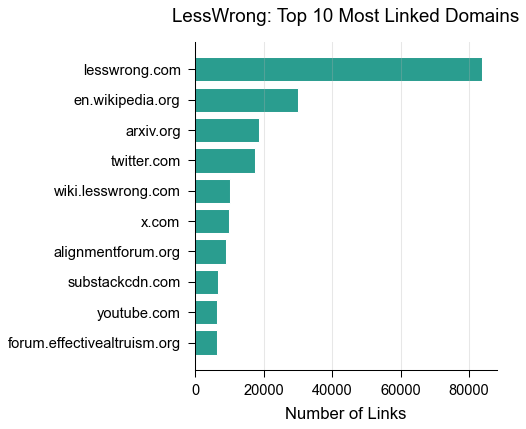

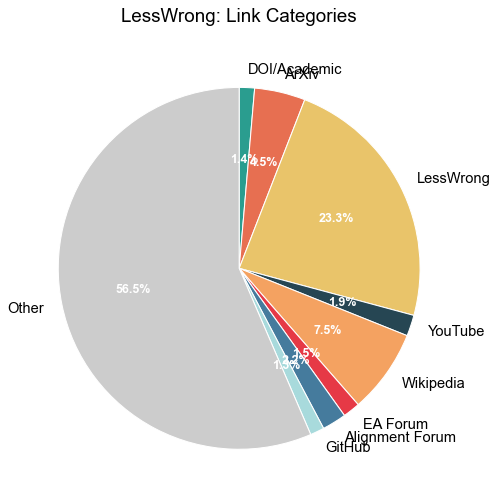

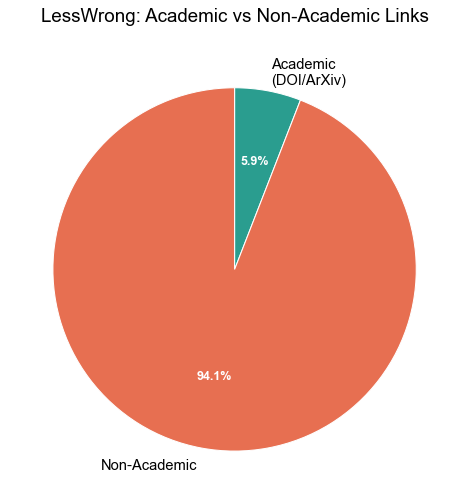


=== SAMPLE LINKS ===
Sample DOI links: ['http://link.springer.com/article/10.1007/s11238-006-9004-4', 'http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476620']
Sample ArXiv links: ['http://arxiv.org/pdf/math/0503081.pdf', 'http://arxiv.org/pdf/hep-ph/9910333.pdf']
Sample LessWrong links: ['https://lesswrong.com/meetups/rp', 'https://lesswrong.com/meetups/rp']

--- Alignment Forum ---
Total links extracted: 68,228
Posts with links: 4,224

=== LINK CATEGORIES ===
DOI/Academic: 763 (1.1%)
ArXiv: 10,523 (15.4%)
LessWrong: 15,542 (22.8%)
YouTube: 880 (1.3%)
Wikipedia: 3,901 (5.7%)
GitHub: 1,635 (2.4%)

=== TOP 15 DOMAINS ===
  lesswrong.com: 15,404 (22.6%)
  arxiv.org: 10,511 (15.4%)
  alignmentforum.org: 7,377 (10.8%)
  en.wikipedia.org: 3,873 (5.7%)
  docs.google.com: 1,340 (2.0%)
  github.com: 967 (1.4%)
  intelligence.org: 949 (1.4%)
  agentfoundations.org: 933 (1.4%)
  mailchi.mp: 889 (1.3%)
  transformer-circuits.pub: 767 (1.1%)
  ai-alignment.com: 749 (1.1%)
  youtube.com

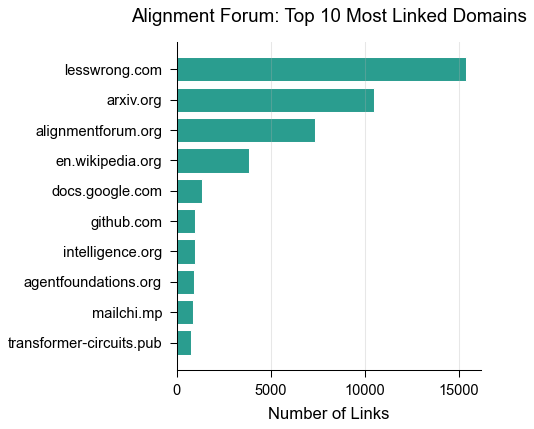

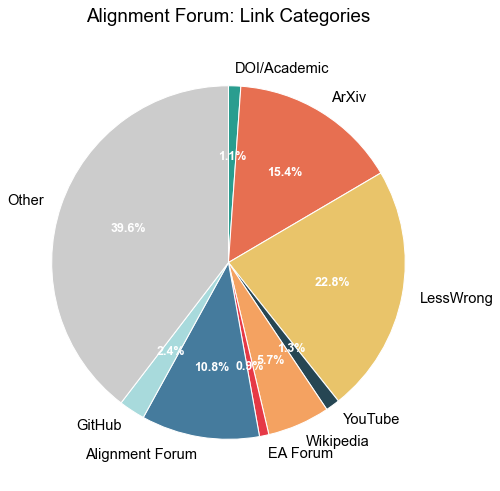

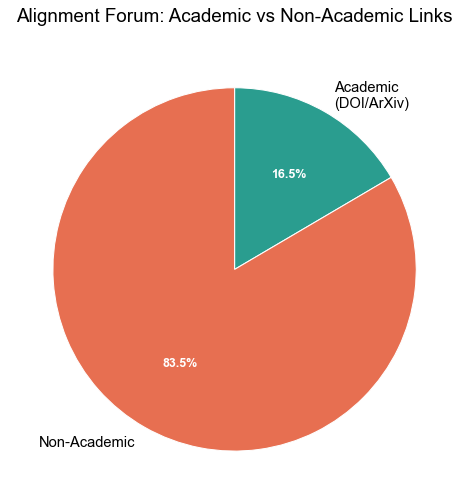


=== SAMPLE LINKS ===
Sample DOI links: ['https://doi.org/10.1038/s42256-019-0048-x', 'https://link.springer.com/article/10.1007/s12685-013-0088-9']
Sample ArXiv links: ['https://arxiv.org/abs/2201.08239', 'https://arxiv.org/abs/2206.14858']
Sample LessWrong links: ['https://www.lesswrong.com/tag/functional-decision-theory', 'https://www.lesswrong.com/s/n945eovrA3oDueqtq']

--- Combined ---
Total links extracted: 478,396
Posts with links: 49,016

=== LINK CATEGORIES ===
DOI/Academic: 6,366 (1.3%)
ArXiv: 29,137 (6.1%)
LessWrong: 111,054 (23.2%)
YouTube: 8,589 (1.8%)
Wikipedia: 34,694 (7.3%)
GitHub: 6,778 (1.4%)

=== TOP 15 DOMAINS ===
  lesswrong.com: 99,257 (20.7%)
  en.wikipedia.org: 34,006 (7.1%)
  arxiv.org: 29,062 (6.1%)
  twitter.com: 17,869 (3.7%)
  alignmentforum.org: 16,230 (3.4%)
  wiki.lesswrong.com: 10,292 (2.2%)
  x.com: 9,965 (2.1%)
  youtube.com: 7,126 (1.5%)
  forum.effectivealtruism.org: 6,900 (1.4%)
  substackcdn.com: 6,582 (1.4%)
  docs.google.com: 5,858 (1.2%)
  thez

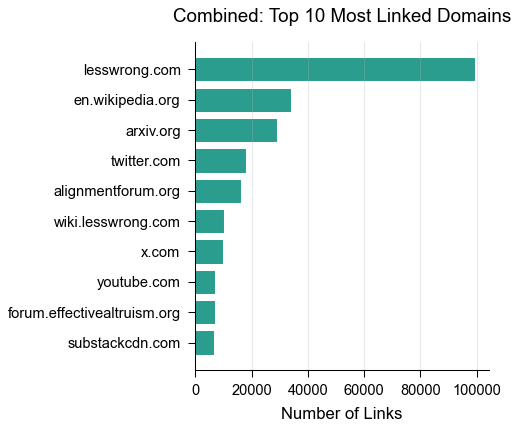

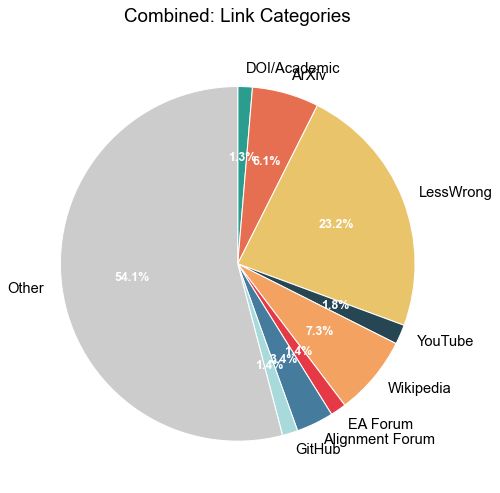

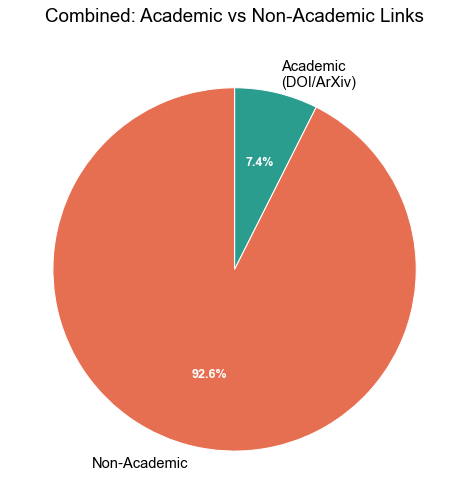


=== SAMPLE LINKS ===
Sample DOI links: ['http://link.springer.com/article/10.1007/s11238-006-9004-4', 'http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476620']
Sample ArXiv links: ['http://arxiv.org/pdf/math/0503081.pdf', 'http://arxiv.org/pdf/hep-ph/9910333.pdf']
Sample LessWrong links: ['https://lesswrong.com/meetups/rp', 'https://lesswrong.com/meetups/rp']

=== Link analysis complete ===


In [31]:
"""Analyze extracted links"""
print("\n=== LINK ANALYSIS ===")

import re
from urllib.parse import urlparse
import glob

def extract_domain(url):
    """Extract domain from URL."""
    try:
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url
        parsed = urlparse(url)
        domain = parsed.netloc.lower()
        # Remove www. prefix for cleaner grouping
        if domain.startswith('www.'):
            domain = domain[4:]
        return domain
    except:
        return 'invalid_url'

def analyze_links(platform_df, platform_name):
    """Analyze links for a given platform."""
    print(f"\n--- {platform_name} ---")
    
    safe_name = platform_name.lower().replace(" ", "_")
    
    # Extract all links
    all_links = []
    for entry in platform_df['extracted_links'].dropna():
        if isinstance(entry, str):
            # Handle JSON-style lists
            if entry.startswith('['):
                try:
                    links = json.loads(entry)
                except:
                    links = [link.strip() for link in entry.split(';') if link.strip()]
            else:
                links = [link.strip() for link in entry.split(';') if link.strip()]
            all_links.extend(links)
        elif isinstance(entry, list):
            all_links.extend(entry)
        else:
            links = [link.strip() for link in str(entry).split(';') if link.strip()]
            all_links.extend(links)
    
    # Final cleaning
    clean_links = [l for l in all_links if l]
    
    if not clean_links:
        print(f"No links found for {platform_name}")
        return
    
    print(f"Total links extracted: {len(clean_links):,}")
    print(f"Posts with links: {platform_df['extracted_links'].notna().sum():,}")
    
    # Pattern analysis
    doi_pattern = r'10\.\d{4,9}/[^\s;<>"]+'
    arxiv_pattern = r'(arxiv\.org/)'
    
    doi_links = [link for link in clean_links if re.search(doi_pattern, link, re.IGNORECASE)]
    arxiv_links = [link for link in clean_links if re.search(arxiv_pattern, link, re.IGNORECASE)]
    lesswrong_links = [link for link in clean_links if 'lesswrong' in link.lower()]
    
    # Extract domains
    domains = [extract_domain(link) for link in clean_links]
    domain_counts = pd.Series(domains).value_counts()
    
    # Category counts
    youtube_count = len([d for d in domains if 'youtube' in d or 'youtu.be' in d])
    wikipedia_count = len([d for d in domains if 'wikipedia' in d])
    github_count = len([d for d in domains if 'github' in d])
    ea_forum_count = len([d for d in domains if 'forum.effectivealtruism' in d])
    alignment_forum_count = len([d for d in domains if 'alignmentforum' in d])
    
    print(f"\n=== LINK CATEGORIES ===")
    print(f"DOI/Academic: {len(doi_links):,} ({len(doi_links)/len(clean_links)*100:.1f}%)")
    print(f"ArXiv: {len(arxiv_links):,} ({len(arxiv_links)/len(clean_links)*100:.1f}%)")
    print(f"LessWrong: {len(lesswrong_links):,} ({len(lesswrong_links)/len(clean_links)*100:.1f}%)")
    print(f"YouTube: {youtube_count:,} ({youtube_count/len(clean_links)*100:.1f}%)")
    print(f"Wikipedia: {wikipedia_count:,} ({wikipedia_count/len(clean_links)*100:.1f}%)")
    print(f"GitHub: {github_count:,} ({github_count/len(clean_links)*100:.1f}%)")
    
    print(f"\n=== TOP 15 DOMAINS ===")
    for domain, count in domain_counts.head(15).items():
        percentage = count/len(clean_links)*100
        print(f"  {domain}: {count:,} ({percentage:.1f}%)")
    
    # Visualizations
    
    # 1. Top domains bar chart
    fig, ax = plt.subplots(figsize=(SINGLE_COL, 3))
    top_domains = domain_counts.head(10)
    bars = ax.barh(range(len(top_domains)), top_domains.values, 
                   color='#2a9d8f', edgecolor='white', linewidth=0.5)
    ax.set_yticks(range(len(top_domains)))
    ax.set_yticklabels(top_domains.index, fontsize=7)
    ax.set_xlabel('Number of Links', fontsize=8)
    ax.set_title(f'{platform_name}: Top 10 Most Linked Domains', pad=10, fontsize=9)
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelsize=7)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 2. Link categories pie chart
    categories = {
        'DOI/Academic': len(doi_links),
        'ArXiv': len(arxiv_links),
        'LessWrong': len(lesswrong_links),
        'YouTube': youtube_count,
        'Wikipedia': wikipedia_count,
        'EA Forum': ea_forum_count,
        'Alignment Forum': alignment_forum_count,
        'GitHub': github_count,
    }
    
    # Calculate "Other" category
    other_count = len(clean_links) - sum(categories.values())
    if other_count > 0:
        categories['Other'] = other_count
    
    # Filter out zero-count categories
    categories = {k: v for k, v in categories.items() if v > 0}
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    wedges, texts, autotexts = ax.pie(
        categories.values(), 
        labels=categories.keys(), 
        autopct='%1.1f%%', 
        startangle=90,
        colors=['#2a9d8f', '#e76f51', '#e9c46a', '#264653', '#f4a261', 
                '#e63946', '#457b9d', '#a8dadc', '#cccccc'],
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False,
        textprops={'fontsize': 7}
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(6)
    
    ax.set_title(f'{platform_name}: Link Categories', pad=10, fontsize=9)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 3. Academic vs Non-Academic
    academic_count = len(doi_links) + len(arxiv_links)
    non_academic_count = len(clean_links) - academic_count
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    wedges, texts, autotexts = ax.pie(
        [academic_count, non_academic_count],
        labels=['Academic\n(DOI/ArXiv)', 'Non-Academic'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#2a9d8f', '#e76f51'],
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False,
        textprops={'fontsize': 7}
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(6)
    
    ax.set_title(f'{platform_name}: Academic vs Non-Academic Links', pad=10, fontsize=9)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Sample links for verification
    print(f"\n=== SAMPLE LINKS ===")
    if doi_links:
        print(f"Sample DOI links: {doi_links[:2]}")
    if arxiv_links:
        print(f"Sample ArXiv links: {arxiv_links[:2]}")
    if lesswrong_links:
        print(f"Sample LessWrong links: {lesswrong_links[:2]}")

# Try loading from final dataset first
posts_df = pd.read_csv("../data/nodes_forum_posts.csv")

if 'extracted_links' not in posts_df.columns:
    print("'extracted_links' not in final dataset. Loading from intermediate data...")
    
    # Load from intermediate processed data
    lw_files = glob.glob("../src/processed_data/lesswrong/02_with_links_and_gender/**/*.csv", recursive=True)
    af_files = glob.glob("../src/processed_data/alignment_forum/02_with_links_and_gender/**/*.csv", recursive=True)
    
    if lw_files or af_files:
        print(f"Found {len(lw_files)} LW files and {len(af_files)} AF files")
        
        all_data = []
        for file in lw_files + af_files:
            try:
                df = pd.read_csv(file)
                df['source'] = 'lesswrong' if 'lesswrong' in str(file) else 'alignment_forum'
                all_data.append(df)
            except Exception as e:
                print(f"Error loading {file}: {e}")
        
        if all_data:
            posts_df = pd.concat(all_data, ignore_index=True)
            # Standardize column names if needed
            if 'user.username' in posts_df.columns:
                posts_df = posts_df.rename(columns={'user.username': 'author_username'})
    else:
        print("ERROR: Could not find intermediate data files with extracted_links")
        posts_df = None

if posts_df is not None and 'extracted_links' in posts_df.columns:
    # Separate by platform
    lesswrong_df = posts_df[posts_df['source'] == 'lesswrong'].copy()
    alignment_forum_df = posts_df[posts_df['source'] == 'alignment_forum'].copy()
    combined_df = posts_df.copy()
    
    # Run analysis for each platform
    for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df), ("Combined", combined_df)]:
        analyze_links(platform_df, platform_name)
else:
    print("\nERROR: Cannot perform link analysis - 'extracted_links' column not available")

print("\n=== Link analysis complete ===")

### Validation

In [32]:
def extract_domain(url):
    """Extract domain from URL."""
    try:
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url
        parsed = urlparse(url)
        domain = parsed.netloc.lower()
        # Remove www. prefix
        if domain.startswith('www.'):
            domain = domain[4:]
        return domain
    except:
        return 'invalid_url'

def categorize_links(links_str):
    """Categorize links for stratification."""
    if pd.isna(links_str) or not links_str or links_str == '[]':
        return 'no_links'
    
    try:
        # Try parsing as JSON list first
        if links_str.startswith('['):
            links = json.loads(links_str)
        else:
            # Fallback to semicolon-separated
            links = [l.strip() for l in links_str.split(';') if l.strip()]
    except:
        links = []
    
    if not links:
        return 'no_links'
    
    num_links = len(links)
    
    # Categorize by number of links
    if num_links == 1:
        return '1_link'
    elif num_links <= 3:
        return '2-3_links'
    elif num_links <= 10:
        return '4-10_links'
    else:
        return '10+_links'

In [33]:
# Add link category for stratification
combined_df['link_category'] = combined_df['extracted_links'].apply(categorize_links)

# Filter to only posts WITH links (we're validating extraction quality)
validation_df = combined_df[combined_df['link_category'] != 'no_links'].copy()

print(f"Total posts with links: {len(validation_df):,}")

Total posts with links: 39,317


In [34]:
# Print statistical analysis
print_sample_size_analysis(
    population_size=len(validation_df),
    sample_size=TOTAL_VALIDATION_SAMPLES,
    confidence=CONFIDENCE_LEVEL,
    margin_error=MARGIN_OF_ERROR
)


STATISTICAL POWER ANALYSIS

Population size: 39,317
Actual sample size: 360
Confidence level: 95.0%
Target margin of error: ±5.0%

--- Required Sample Sizes ---
Conservative estimate (p=0.5): 381
Optimistic estimate (p=0.85): 195

⚠ Sample size is ACCEPTABLE (meets optimistic requirement)

With 360 samples, you can estimate accuracy within:
  ±5.17% at 95% confidence (conservative)

--- Expected Confidence Intervals ---
If observed accuracy is:
  70.0%: 95% CI = [65.3%, 74.7%]
  75.0%: 95% CI = [70.5%, 79.5%]
  80.0%: 95% CI = [75.9%, 84.1%]
  85.0%: 95% CI = [81.3%, 88.7%]
  90.0%: 95% CI = [86.9%, 93.1%]
  95.0%: 95% CI = [92.7%, 97.3%]



In [35]:
print(f"\n{'='*80}")
print("LINK CATEGORY DISTRIBUTION")
print(f"{'='*80}")

# Get category counts and proportions
category_counts = validation_df["link_category"].value_counts()
category_proportions = category_counts / len(validation_df)

print(f"\n{'Category':<20} {'Count':>10} {'%':>7} {'Samples':>8}")
print("-" * 80)

for category, count in category_counts.items():
    proportion = count / len(validation_df)
    n_samples = round(TOTAL_VALIDATION_SAMPLES * proportion)
    print(f"{category:<20} {count:>10,} {proportion*100:>6.1f}% {n_samples:>8}")

print("-" * 80)
print(f"{'TOTAL':<20} {len(validation_df):>10,} {100.0:>6.1f}% {TOTAL_VALIDATION_SAMPLES:>8}")
print(f"\nNote: Final allocation will be adjusted to ensure exactly {TOTAL_VALIDATION_SAMPLES} samples")

# Stratified sampling by link category
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Calculate proportional samples for each category with remainder allocation
sample_allocation = {}
allocated_so_far = 0

for i, (category, count) in enumerate(category_counts.items()):
    if i == len(category_counts) - 1:
        # Last category gets the remainder
        n_samples = TOTAL_VALIDATION_SAMPLES - allocated_so_far
    else:
        # Proportional allocation with rounding
        n_samples = round(TOTAL_VALIDATION_SAMPLES * count / len(validation_df))
        allocated_so_far += n_samples
    
    sample_allocation[category] = max(1, n_samples)

print(f"\n{'='*80}")
print("SAMPLE ALLOCATION (after adjusting for rounding)")
print(f"{'='*80}")
print(f"{'Category':<20} {'Allocated Samples':>20}")
print("-" * 80)
total_allocated = 0
for category in category_counts.index:
    n = sample_allocation[category]
    print(f"{category:<20} {n:>20}")
    total_allocated += n
print("-" * 80)
print(f"{'TOTAL':<20} {total_allocated:>20}")
print(f"{'='*80}")

validation_samples = []

for category in category_counts.index:
    category_df = validation_df[validation_df["link_category"] == category]
    n_samples = sample_allocation[category]
    
    # Sample randomly
    if len(category_df) >= n_samples:
        sampled = category_df.sample(n=n_samples, random_state=RANDOM_SEED)
    else:
        sampled = category_df
    
    validation_samples.append(sampled)

validation_set = pd.concat(validation_samples, ignore_index=True)

# Shuffle the validation set
validation_set = validation_set.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Keep only essential columns for validation
columns_to_keep = ['platform', 'title', 'pageUrl', 'extracted_links', 'link_category']
validation_set = validation_set[[col for col in columns_to_keep if col in validation_set.columns]]

# Add a column showing extracted link count
def count_links(links_str):
    if pd.isna(links_str) or not links_str or links_str == '[]':
        return 0
    try:
        if links_str.startswith('['):
            links = json.loads(links_str)
        else:
            links = [l.strip() for l in links_str.split(';') if l.strip()]
        return len(links)
    except:
        return 0

validation_set['num_extracted_links'] = validation_set['extracted_links'].apply(count_links)

print(f"\n{'='*80}")
print("VALIDATION SET CREATED")
print(f"{'='*80}")
print(f"Total validation samples: {len(validation_set)}")
print(f"\nActual samples per category:")
print(validation_set["link_category"].value_counts().sort_index())

# Add columns for manual validation
validation_set['validation_correct'] = ''  # 'yes', 'no', 'partial'
validation_set['validation_notes'] = ''  # Any issues found
validation_set['validation_missing_links'] = ''  # Links that should have been extracted but weren't
validation_set['validation_extra_links'] = ''  # Links that were extracted but shouldn't be
validation_set['validation_num_correct_links'] = ''  # How many links are correct

# Save to CSV for validation
output_file = 'link_extraction_validation_set.csv'
validation_set.to_csv(output_file, index=False)
print(f"\n✓ Saved validation set to: {output_file}")


LINK CATEGORY DISTRIBUTION

Category                  Count       %  Samples
--------------------------------------------------------------------------------
4-10_links               12,503   31.8%      114
10+_links                11,141   28.3%      102
2-3_links                 9,060   23.0%       83
1_link                    6,613   16.8%       61
--------------------------------------------------------------------------------
TOTAL                    39,317  100.0%      360

Note: Final allocation will be adjusted to ensure exactly 360 samples

SAMPLE ALLOCATION (after adjusting for rounding)
Category                Allocated Samples
--------------------------------------------------------------------------------
4-10_links                            114
10+_links                             102
2-3_links                              83
1_link                                 61
--------------------------------------------------------------------------------
TOTAL                 

In [36]:
print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("1. Open 'link_extraction_validation_set.csv' in Excel/Google Sheets")
print("2. For each row, examine the htmlBody and fill in:")
print("   - validation_correct: 'yes' (all links correct), 'no' (missed links), 'partial' (some correct)")
print("   - validation_notes: Any comments about extraction quality")
print("   - validation_missing_links: URLs that should have been extracted (semicolon-separated)")
print("   - validation_extra_links: URLs that shouldn't have been extracted (semicolon-separated)")
print("   - validation_num_correct_links: Count of correctly extracted links")
print("3. Save the file and run the analysis script to calculate:")
print("   - Overall extraction accuracy with confidence intervals")
print("   - Precision (% of extracted links that are correct)")
print("   - Recall (% of actual links that were extracted)")
print("   - Per-category accuracy")
print("\nValidation Tips:")
print("  - Check if relative URLs are properly converted to absolute URLs")
print("  - Verify anchor links (#) and javascript: links are excluded")
print("  - Check if internal forum links are handled correctly")
print("  - Look for edge cases: URLs in text vs HTML, malformed URLs, etc.")
print("\nOptional: Share the CSV with another rater for inter-rater reliability!")
print("="*80)


NEXT STEPS
1. Open 'link_extraction_validation_set.csv' in Excel/Google Sheets
2. For each row, examine the htmlBody and fill in:
   - validation_correct: 'yes' (all links correct), 'no' (missed links), 'partial' (some correct)
   - validation_notes: Any comments about extraction quality
   - validation_missing_links: URLs that should have been extracted (semicolon-separated)
   - validation_extra_links: URLs that shouldn't have been extracted (semicolon-separated)
   - validation_num_correct_links: Count of correctly extracted links
3. Save the file and run the analysis script to calculate:
   - Overall extraction accuracy with confidence intervals
   - Precision (% of extracted links that are correct)
   - Recall (% of actual links that were extracted)
   - Per-category accuracy

Validation Tips:
  - Check if relative URLs are properly converted to absolute URLs
  - Verify anchor links (#) and javascript: links are excluded
  - Check if internal forum links are handled correctly
  -

In [37]:
# Create a simple results analysis function for after validation
print("\n" + "="*80)
print("AFTER VALIDATION - USE THIS CODE TO ANALYZE RESULTS")
print("="*80)
print("""
# Load validated results
validated_df = pd.read_csv('link_extraction_validation_set.csv')

# Calculate accuracy metrics
perfect = (validated_df['validation_correct'] == 'yes').sum()
partial = (validated_df['validation_correct'] == 'partial').sum()
incorrect = (validated_df['validation_correct'] == 'no').sum()
total = len(validated_df)

accuracy = perfect / total
print(f"Perfect Extraction: {perfect}/{total} ({accuracy*100:.1f}%)")
print(f"Partial Extraction: {partial}/{total} ({partial/total*100:.1f}%)")
print(f"Missed Links: {incorrect}/{total} ({incorrect/total*100:.1f}%)")

# Calculate confidence interval
lower, upper = calculate_confidence_interval(total, accuracy, 0.95)
print(f"95% Confidence Interval: [{lower*100:.1f}%, {upper*100:.1f}%]")

# Calculate precision and recall
total_correct = validated_df['validation_num_correct_links'].astype(float).sum()
total_extracted = validated_df['num_extracted_links'].sum()
# You'll need to count actual links in HTML - this is an approximation
precision = total_correct / total_extracted if total_extracted > 0 else 0
print(f"\\nPrecision (correct/extracted): {precision*100:.1f}%")

# Per-category accuracy
category_accuracy = validated_df.groupby('link_category').apply(
    lambda x: (x['validation_correct'] == 'yes').sum() / len(x)
)
print("\\nPer-Category Accuracy:")
print(category_accuracy.sort_values(ascending=False))
""")
print("="*80)


AFTER VALIDATION - USE THIS CODE TO ANALYZE RESULTS

# Load validated results
validated_df = pd.read_csv('link_extraction_validation_set.csv')

# Calculate accuracy metrics
perfect = (validated_df['validation_correct'] == 'yes').sum()
partial = (validated_df['validation_correct'] == 'partial').sum()
incorrect = (validated_df['validation_correct'] == 'no').sum()
total = len(validated_df)

accuracy = perfect / total
print(f"Perfect Extraction: {perfect}/{total} ({accuracy*100:.1f}%)")
print(f"Partial Extraction: {partial}/{total} ({partial/total*100:.1f}%)")
print(f"Missed Links: {incorrect}/{total} ({incorrect/total*100:.1f}%)")

# Calculate confidence interval
lower, upper = calculate_confidence_interval(total, accuracy, 0.95)
print(f"95% Confidence Interval: [{lower*100:.1f}%, {upper*100:.1f}%]")

# Calculate precision and recall
total_correct = validated_df['validation_num_correct_links'].astype(float).sum()
total_extracted = validated_df['num_extracted_links'].sum()
# You'll need t

## Summary

In [38]:
"""Generate comprehensive summary reports"""

def generate_summary_report(platform_df, platform_name):
    """Generate a detailed summary report for a platform."""
    
    print("\n" + "="*70)
    print(f"          {platform_name.upper()} DATA SUMMARY REPORT")
    print("="*70)
    
    # Overall Statistics
    print(f"\n📊 OVERALL STATISTICS:")
    print(f"   Total Posts: {len(platform_df):,}")
    if 'year' in platform_df.columns:
        print(f"   Date Range: {platform_df['year'].min()}-{platform_df['year'].max()}")
    print(f"   Unique Authors: {platform_df['author_username'].nunique():,}")
    if 'topic_label' in platform_df.columns:
        unique_topics = platform_df['topic_label'].dropna().nunique()
        print(f"   Unique Topics: {unique_topics}")
    
    # Crossposts (if this is the combined dataset)
    if 'is_crosspost' in platform_df.columns:
        crosspost_count = platform_df['is_crosspost'].sum()
        if crosspost_count > 0:
            print(f"   Crossposts: {crosspost_count:,} ({crosspost_count/len(platform_df)*100:.1f}%)")
    
    # Author Insights
    print(f"\n👥 AUTHOR INSIGHTS:")
    author_counts = platform_df['author_username'].value_counts()
    print(f"   One-time contributors: {(author_counts == 1).sum():,} ({((author_counts == 1).sum() / len(author_counts) * 100):.1f}%)")
    print(f"   Regular authors (2-9 posts): {((author_counts >= 2) & (author_counts < 10)).sum():,}")
    print(f"   Prolific authors (10-49 posts): {((author_counts >= 10) & (author_counts < 50)).sum():,}")
    print(f"   Super authors (50+ posts): {(author_counts >= 50).sum():,}")
    print(f"   Most prolific: {author_counts.index[0]} with {author_counts.iloc[0]:,} posts")
    
    # Show top 5 authors
    print(f"   Top 5 authors:")
    for i, (author, count) in enumerate(author_counts.head(5).items(), 1):
        print(f"      {i}. {author}: {count:,} posts")
    
    # Topic Insights
    if 'topic_label' in platform_df.columns:
        print(f"\n🏷️  TOPIC INSIGHTS:")
        topic_df = platform_df[platform_df['topic_label'].notna()]
        if len(topic_df) > 0:
            topic_counts = topic_df['topic_label'].value_counts()
            print(f"   Posts with topics: {len(topic_df):,} ({len(topic_df)/len(platform_df)*100:.1f}%)")
            print(f"   Posts without topics (outliers): {(platform_df['topic_label'].isna().sum()):,}")
            print(f"   Most popular topic: {topic_counts.index[0]} ({topic_counts.iloc[0]:,} posts, {topic_counts.iloc[0]/len(topic_df)*100:.1f}%)")
            print(f"   Topics with 100+ posts: {(topic_counts >= 100).sum()}")
            print(f"   Topics with 1000+ posts: {(topic_counts >= 1000).sum()}")
            print(f"   Topic distribution:")
            for topic, count in topic_counts.items():
                percentage = (count / len(topic_df)) * 100
                print(f"      {topic}: {count:,} ({percentage:.1f}%)")
    
    # Gender Distribution (need to merge with authors)
    print(f"\n🚻 GENDER DISTRIBUTION:")
    if 'author_gender_inferred' in platform_df.columns:
        gender_counts = platform_df['author_gender_inferred'].value_counts()
        for gender, count in gender_counts.items():
            percentage = (count / len(platform_df)) * 100
            gender_label = {'gm': 'Male', 'gf': 'Female', '-': 'Unknown'}.get(gender, gender)
            print(f"   {gender_label}: {count:,} ({percentage:.1f}%)")
        
        # Unique users by gender
        unique_users = platform_df[['author_username', 'author_gender_inferred']].drop_duplicates()
        user_gender_counts = unique_users['author_gender_inferred'].value_counts()
        print(f"   Unique users by gender:")
        for gender, count in user_gender_counts.items():
            percentage = (count / len(unique_users)) * 100
            gender_label = {'gm': 'Male', 'gf': 'Female', '-': 'Unknown'}.get(gender, gender)
            print(f"      {gender_label}: {count:,} ({percentage:.1f}%)")
    
    # Engagement Metrics
    print(f"\n📈 ENGAGEMENT METRICS:")
    print(f"   Average score: {platform_df['base_score'].mean():.1f}")
    print(f"   Median score: {platform_df['base_score'].median():.1f}")
    print(f"   Average comments: {platform_df['comment_count'].mean():.1f}")
    print(f"   Median comments: {platform_df['comment_count'].median():.1f}")
    print(f"   Total comments: {platform_df['comment_count'].sum():,}")
    
    # Top posts
    top_score_idx = platform_df['base_score'].idxmax()
    top_comments_idx = platform_df['comment_count'].idxmax()
    print(f"   Highest scoring post ({platform_df.loc[top_score_idx, 'base_score']:.0f} points):")
    print(f"      '{platform_df.loc[top_score_idx, 'title'][:60]}...'")
    print(f"      by {platform_df.loc[top_score_idx, 'author_username']}")
    print(f"   Most commented post ({platform_df.loc[top_comments_idx, 'comment_count']:.0f} comments):")
    print(f"      '{platform_df.loc[top_comments_idx, 'title'][:60]}...'")
    print(f"      by {platform_df.loc[top_comments_idx, 'author_username']}")
    
    # Score and comment distribution
    high_score = (platform_df['base_score'] >= 100).sum()
    very_high_score = (platform_df['base_score'] >= 500).sum()
    print(f"   Posts with 100+ score: {high_score:,} ({high_score/len(platform_df)*100:.1f}%)")
    print(f"   Posts with 500+ score: {very_high_score:,} ({very_high_score/len(platform_df)*100:.1f}%)")
    
    # Temporal Trends
    if 'year' in platform_df.columns:
        print(f"\n📅 TEMPORAL TRENDS:")
        yearly_posts = platform_df.groupby('year').size()
        peak_year = yearly_posts.idxmax()
        print(f"   Peak posting year: {peak_year} with {yearly_posts[peak_year]:,} posts")
        if len(yearly_posts) > 1:
            growth = ((yearly_posts.iloc[-1] / yearly_posts.iloc[0] - 1) * 100)
            print(f"   Growth from {yearly_posts.index[0]} to {yearly_posts.index[-1]}: {growth:+.1f}%")
        
        # Year-by-year breakdown
        print(f"   Posts by year:")
        for year, count in yearly_posts.items():
            print(f"      {year}: {count:,} posts")
    
    # Monthly patterns (if available)
    if 'month' in platform_df.columns:
        monthly_posts = platform_df.groupby('month').size()
        peak_month = monthly_posts.idxmax()
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        print(f"   Most active month: {month_names[peak_month-1]} ({monthly_posts[peak_month]:,} posts total)")
    
    # Questions (if available)
    if 'is_question' in platform_df.columns:
        print(f"\n❓ QUESTION POSTS:")
        questions = platform_df['is_question'].sum()
        print(f"   Question posts: {questions:,} ({questions/len(platform_df)*100:.1f}%)")
    
    # Content length (if text column is available)
    if 'text' in platform_df.columns:
        print(f"\n📝 CONTENT METRICS:")
        platform_df['word_count'] = platform_df['text'].fillna('').str.split().str.len()
        print(f"   Average word count: {platform_df['word_count'].mean():.0f}")
        print(f"   Median word count: {platform_df['word_count'].median():.0f}")
        short_posts = (platform_df['word_count'] < 500).sum()
        medium_posts = ((platform_df['word_count'] >= 500) & (platform_df['word_count'] < 2000)).sum()
        long_posts = (platform_df['word_count'] >= 2000).sum()
        print(f"   Short posts (<500 words): {short_posts:,} ({short_posts/len(platform_df)*100:.1f}%)")
        print(f"   Medium posts (500-2000 words): {medium_posts:,} ({medium_posts/len(platform_df)*100:.1f}%)")
        print(f"   Long posts (2000+ words): {long_posts:,} ({long_posts/len(platform_df)*100:.1f}%)")
    
    print("\n" + "="*70)

# Load data and merge with authors for gender info
posts_df = pd.read_csv("../data/nodes_forum_posts.csv")
authors_df = pd.read_csv("../data/nodes_forum_authors.csv")

# Merge posts with authors to get gender
posts_with_gender = posts_df.merge(
    authors_df[['author_username', 'author_gender_inferred']], 
    on='author_username', 
    how='left'
)

# Extract year and month from posted_at
posts_with_gender['posted_at'] = pd.to_datetime(posts_with_gender['posted_at'], errors='coerce')
posts_with_gender['year'] = posts_with_gender['posted_at'].dt.year
posts_with_gender['month'] = posts_with_gender['posted_at'].dt.month

# Separate by platform
lesswrong_df = posts_with_gender[posts_with_gender['source'] == 'lesswrong'].copy()
alignment_forum_df = posts_with_gender[posts_with_gender['source'] == 'alignment_forum'].copy()
combined_df = posts_with_gender.copy()

# Generate reports for each platform
for platform_name, platform_df in [("LessWrong", lesswrong_df), ("Alignment Forum", alignment_forum_df), ("Combined", combined_df)]:
    generate_summary_report(platform_df, platform_name)

# Comparative summary
print("\n" + "="*70)
print("                    COMPARATIVE SUMMARY")
print("="*70)
print(f"\n📊 PLATFORM COMPARISON:")
print(f"   LessWrong posts: {len(lesswrong_df):,}")
print(f"   Alignment Forum posts: {len(alignment_forum_df):,}")
print(f"   Total (including crossposts): {len(combined_df):,}")
print(f"   Unique posts (excluding crosspost duplicates): {len(combined_df[~combined_df['is_crosspost']]):,}")

print(f"\n👥 AUTHOR OVERLAP:")
lw_authors = set(lesswrong_df['author_username'].unique())
af_authors = set(alignment_forum_df['author_username'].unique())
overlap = lw_authors & af_authors
print(f"   LessWrong only: {len(lw_authors - af_authors):,}")
print(f"   Alignment Forum only: {len(af_authors - lw_authors):,}")
print(f"   Both platforms: {len(overlap):,}")

print(f"\n📈 ENGAGEMENT COMPARISON:")
print(f"   LessWrong avg score: {lesswrong_df['base_score'].mean():.1f}")
print(f"   Alignment Forum avg score: {alignment_forum_df['base_score'].mean():.1f}")
print(f"   LessWrong avg comments: {lesswrong_df['comment_count'].mean():.1f}")
print(f"   Alignment Forum avg comments: {alignment_forum_df['comment_count'].mean():.1f}")

print("\n" + "="*70)
print("                  SUMMARY REPORT COMPLETE")
print("="*70)


          LESSWRONG DATA SUMMARY REPORT

📊 OVERALL STATISTICS:
   Total Posts: 43,451
   Date Range: 2006-2025
   Unique Authors: 6,197
   Unique Topics: 11
   Crossposts: 4,278 (9.8%)

👥 AUTHOR INSIGHTS:
   One-time contributors: 2,995 (48.3%)
   Regular authors (2-9 posts): 2,450
   Prolific authors (10-49 posts): 614
   Super authors (50+ posts): 138
   Most prolific: Eliezer_Yudkowsky with 1,050 posts
   Top 5 authors:
      1. Eliezer_Yudkowsky: 1,050 posts
      2. jkaufman: 1,018 posts
      3. Zvi: 936 posts
      4. Stuart_Armstrong: 800 posts
      5. KatjaGrace: 621 posts

🏷️  TOPIC INSIGHTS:
   Posts with topics: 42,463 (97.7%)
   Posts without topics (outliers): 988
   Most popular topic: AI Safety & Alignment (12,844 posts, 30.2%)
   Topics with 100+ posts: 11
   Topics with 1000+ posts: 8
   Topic distribution:
      AI Safety & Alignment: 12,844 (30.2%)
      Rationality & Philosophy: 8,425 (19.8%)
      Applied Rationality & Self-Improvement: 5,458 (12.9%)
      Commu

---
# OpenAlex Nodes
---

## Topics

In [39]:
print("\n=== Parsing OpenAlex Topics ===")

# Load OpenAlex data from final dataset
openalex_df = pd.read_csv("../data/nodes_openalex_works.csv")

print(f"Loaded {len(openalex_df):,} OpenAlex works")

# Parse topics column (semicolon-separated string)
def parse_topics(topic_str):
    """Parse topics from semicolon-separated string."""
    if pd.isna(topic_str):
        return []
    # Split by semicolon and clean whitespace
    topics = [t.strip() for t in str(topic_str).split(';') if t.strip()]
    return topics

# Check if topics column exists in the final dataset
if 'topics' in openalex_df.columns:
    # Extract all topics
    print("Parsing topic data...")
    openalex_df['parsed_topics'] = openalex_df['topics'].apply(parse_topics)
    openalex_df['num_topics'] = openalex_df['parsed_topics'].apply(len)
    
    print(f"Papers with topics: {(openalex_df['num_topics'] > 0).sum():,}")
    print(f"Average topics per paper: {openalex_df['num_topics'].mean():.1f}")
    
    # Get all unique topics
    all_topics = []
    for topics_list in openalex_df['parsed_topics']:
        all_topics.extend(topics_list)
    
    unique_topics = set(all_topics)
    print(f"Total unique topics: {len(unique_topics):,}")
    
    # Most common topics
    from collections import Counter
    topic_counts = Counter(all_topics)
    print(f"\nTop 10 most common topics:")
    for topic, count in topic_counts.most_common(10):
        print(f"  {topic}: {count:,} papers ({count/len(openalex_df)*100:.1f}%)")
else:
    print("Warning: 'topics' column not found in nodes_openalex_works.csv")
    print("Available columns:", openalex_df.columns.tolist())

# Basic statistics
print(f"\n=== OpenAlex Dataset Overview ===")
print(f"Total works: {len(openalex_df):,}")
print(f"Works with DOI: {openalex_df['openalex_doi'].notna().sum():,}")
print(f"Date range: {openalex_df['publication_year'].min()}-{openalex_df['publication_year'].max()}")
print(f"Average citations: {openalex_df['cited_by_count'].mean():.1f}")
print(f"Median citations: {openalex_df['cited_by_count'].median():.1f}")

# Publication types
if 'type' in openalex_df.columns:
    print(f"\nPublication types:")
    type_counts = openalex_df['type'].value_counts()
    for pub_type, count in type_counts.items():
        print(f"  {pub_type}: {count:,} ({count/len(openalex_df)*100:.1f}%)")

# Most cited works
print(f"\nTop 5 most cited works:")
top_cited = openalex_df.nlargest(5, 'cited_by_count')
for idx, row in top_cited.iterrows():
    print(f"  {row['cited_by_count']:>5} citations: {row['title'][:60]}... ({row['publication_year']})")


=== Parsing OpenAlex Topics ===
Loaded 200,060 OpenAlex works
Available columns: ['openalex_id', 'openalex_doi', 'title', 'publication_year', 'type', 'cited_by_count']

=== OpenAlex Dataset Overview ===
Total works: 200,060
Works with DOI: 171,031
Date range: 2000-2025
Average citations: 17.5
Median citations: 3.0

Publication types:
  article: 200,060 (100.0%)

Top 5 most cited works:
  29537 citations: Rethinking the Inception Architecture for Computer Vision... (2016)
  18980 citations: Grad-CAM: Visual Explanations from Deep Networks via Gradien... (2017)
  18140 citations: Delving Deep into Rectifiers: Surpassing Human-Level Perform... (2015)
  17606 citations: Xception: Deep Learning with Depthwise Separable Convolution... (2017)
  13263 citations: "Why Should I Trust You?"... (2016)


Loading OpenAlex data with topics from intermediate files...
Loaded 2,864 OpenAlex works from 10 files
Parsing topic data...
Papers with topics: 2,856
Average topics per paper: 2.7
Extracted 7699 topic associations from 2864 papers
Unique topics: 1064

Top 20 Topic Distribution:
  Hate Speech and Cyberbullying Detection: 1,414 (18.4%)
  Ethics and Social Impacts of AI: 344 (4.5%)
  Social Media and Politics: 244 (3.2%)
  Adversarial Robustness in Machine Learning: 181 (2.4%)
  Freedom of Expression and Defamation: 170 (2.2%)
  Reinforcement Learning in Robotics: 152 (2.0%)
  Privacy, Security, and Data Protection: 141 (1.8%)
  Law, Rights, and Freedoms: 105 (1.4%)
  Explainable Artificial Intelligence (XAI): 96 (1.2%)
  Bullying, Victimization, and Aggression: 85 (1.1%)
  Law in Society and Culture: 76 (1.0%)
  Deception detection and forensic psychology: 75 (1.0%)
  Cybercrime and Law Enforcement Studies: 70 (0.9%)
  Neuroethics, Human Enhancement, Biomedical Innovations: 68 (0.9%)
  

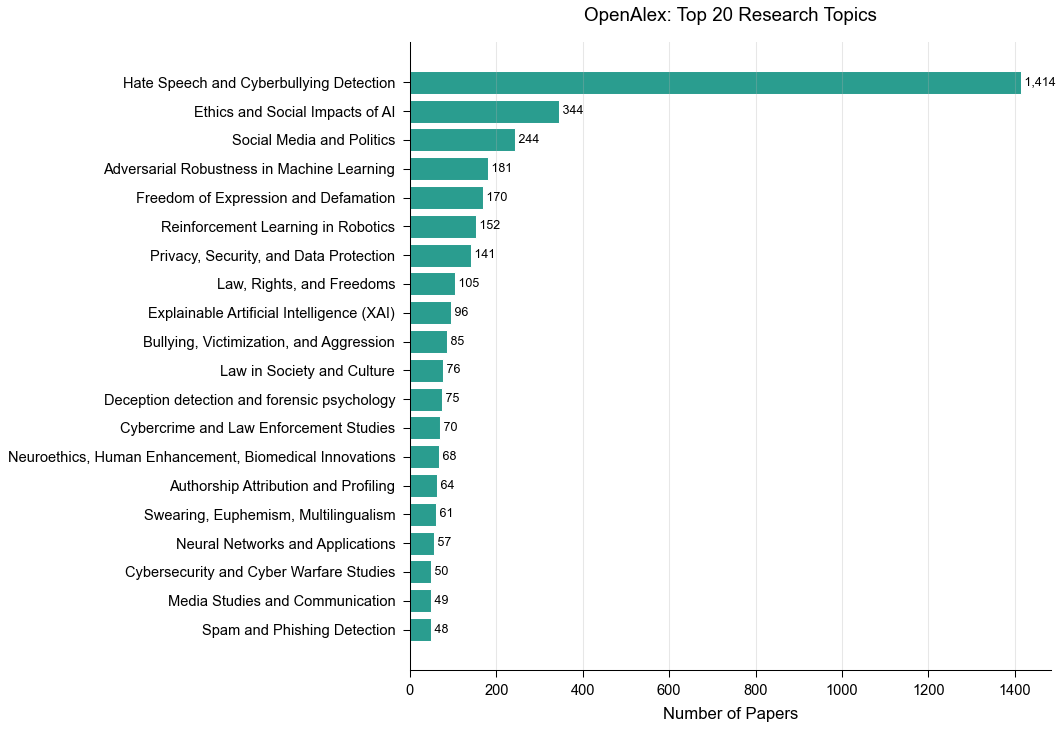

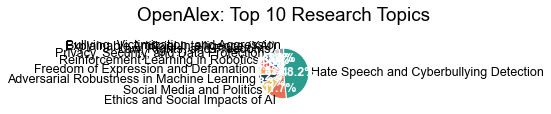


Top 20 Topics by Citation Metrics:
                                                  total_citations  avg_citations  median_citations  paper_count
topic_name                                                                                                     
Hate Speech and Cyberbullying Detection                     23546           16.7               1.0         1414
Ethics and Social Impacts of AI                              7364           21.4               1.0          344
Adversarial Robustness in Machine Learning                   6960           38.5               5.0          181
Social Media and Politics                                    6490           26.6               2.0          244
Explainable Artificial Intelligence (XAI)                    6184           64.4               4.5           96
Reinforcement Learning in Robotics                           6046           39.8               5.0          152
Misinformation and Its Impacts                               3585   

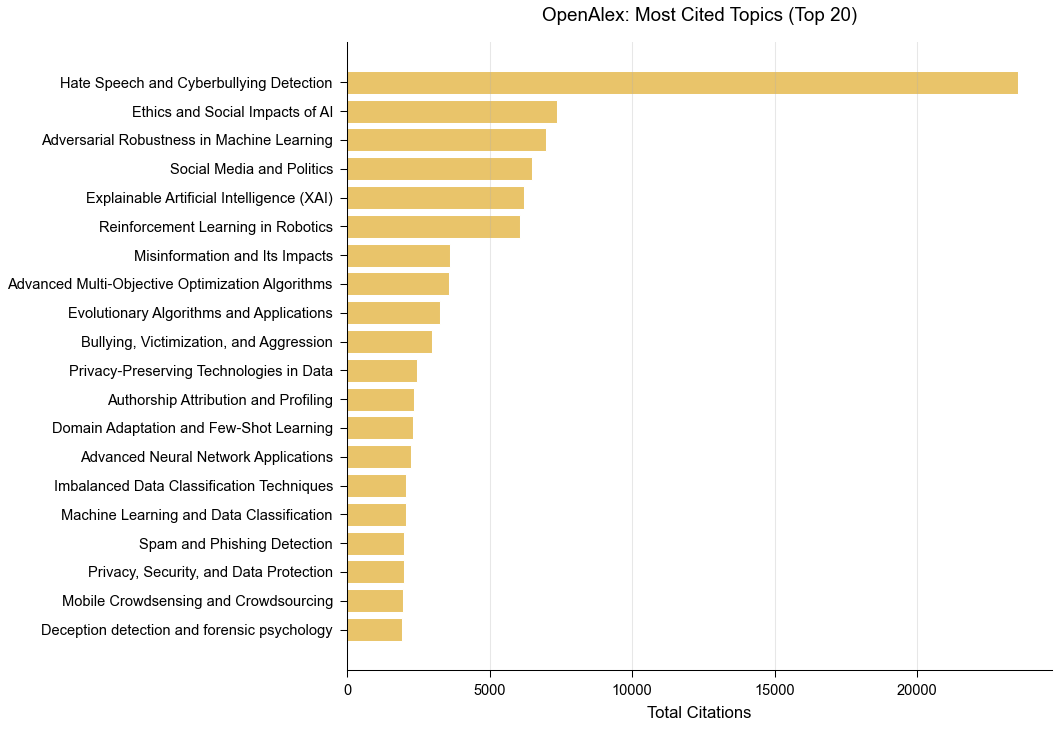

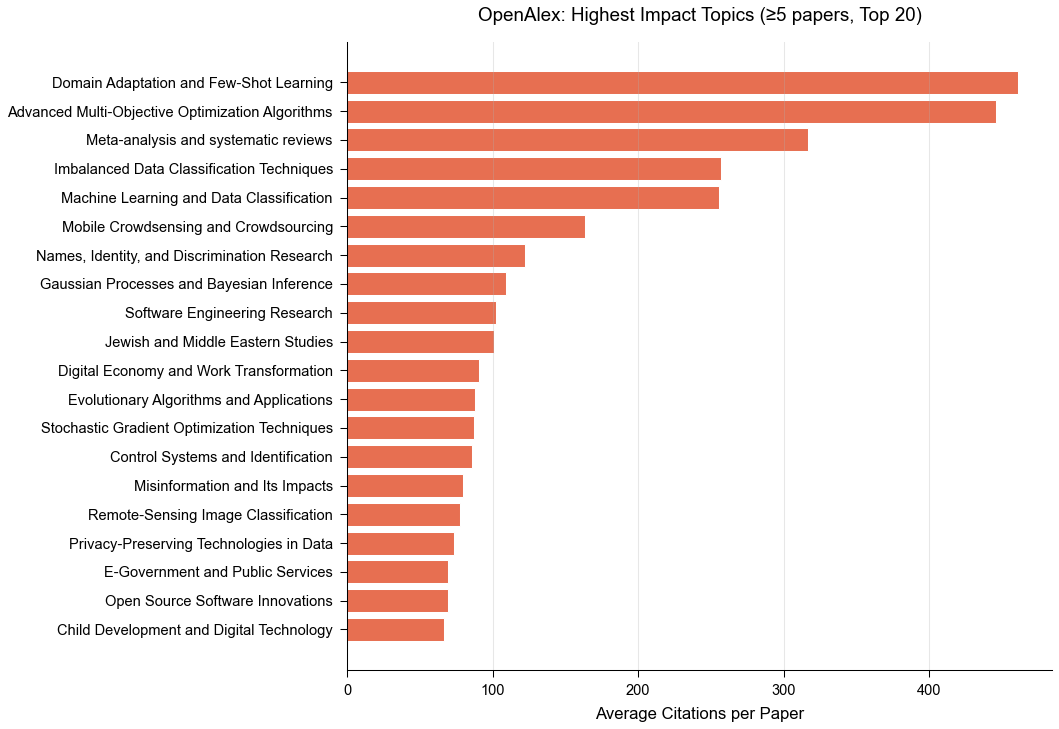

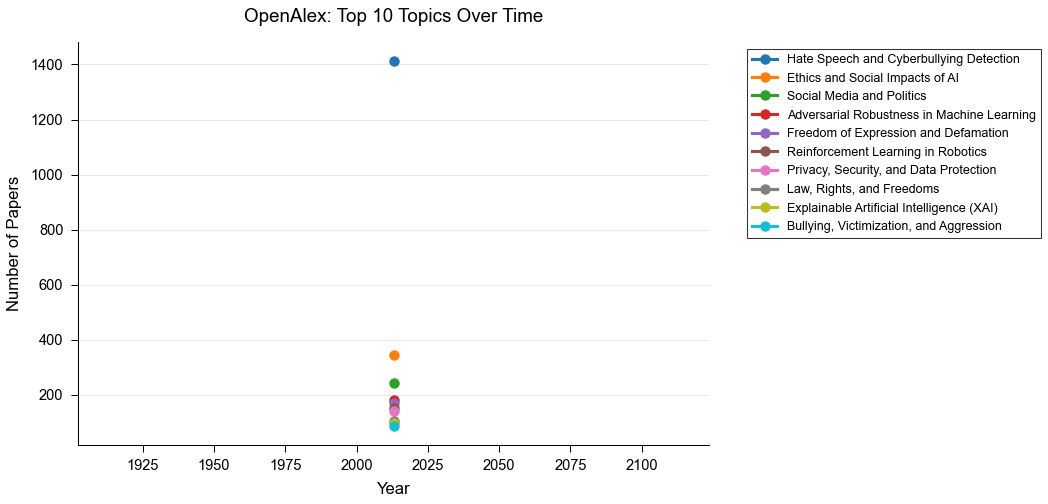

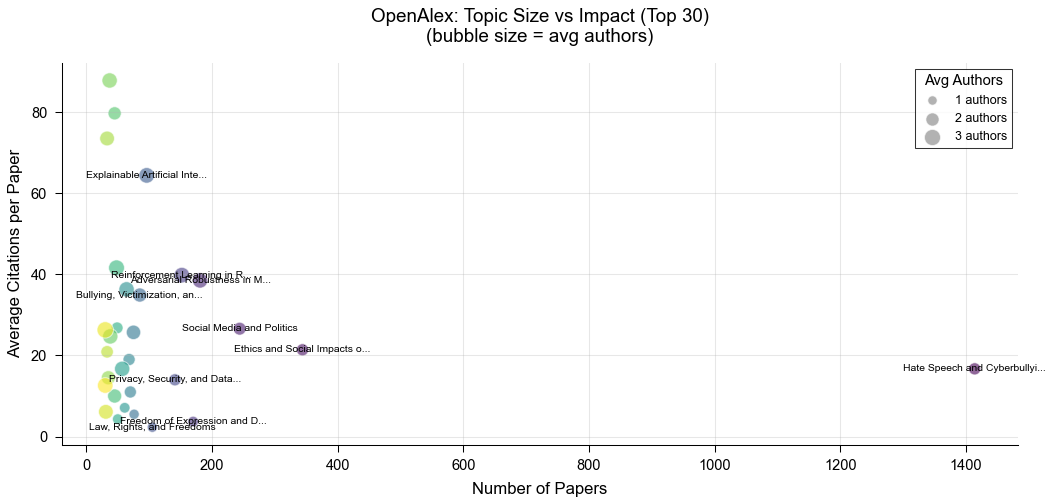


=== OpenAlex topic analysis complete ===


In [40]:
"""=== OPENALEX TOPIC ANALYSIS ==="""

import glob
from pathlib import Path

# Load OpenAlex data with topics from intermediate processed data
print("Loading OpenAlex data with topics from intermediate files...")
openalex_files = glob.glob("../src/processed_data/openalex/02_with_gender/**/*.csv", recursive=True)

if not openalex_files:
    print("Warning: No OpenAlex intermediate files found. Trying alternative path...")
    openalex_files = glob.glob("../src/processed_data/openalex/**/*.csv", recursive=True)

if not openalex_files:
    print("ERROR: Could not find OpenAlex data with topics.")
    print("Topics are not in the final nodes_openalex_works.csv file.")
    print("Please ensure intermediate data exists in src/processed_data/openalex/")
else:
    openalex_data = []
    for file in openalex_files[:10]:  # Load first 10 files as sample, or remove limit
        try:
            df = pd.read_csv(file)
            openalex_data.append(df)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    if openalex_data:
        openalex_df = pd.concat(openalex_data, ignore_index=True)
        print(f"Loaded {len(openalex_df):,} OpenAlex works from {len(openalex_data)} files")
        
        # Parse topics column (semicolon-separated string)
        def parse_topics(topic_str):
            """Parse topics from semicolon-separated string."""
            if pd.isna(topic_str):
                return []
            # Split by semicolon and clean whitespace
            topics = [t.strip() for t in str(topic_str).split(';') if t.strip()]
            return topics
        
        # Extract all topics
        print("Parsing topic data...")
        openalex_df['parsed_topics'] = openalex_df['topics'].apply(parse_topics)
        openalex_df['num_topics'] = openalex_df['parsed_topics'].apply(len)
        
        print(f"Papers with topics: {(openalex_df['num_topics'] > 0).sum():,}")
        print(f"Average topics per paper: {openalex_df['num_topics'].mean():.1f}")
        
        # Create expanded dataframe with one row per topic
        all_topics = []
        for idx, row in openalex_df.iterrows():
            topics = row['parsed_topics']
            for topic in topics:
                all_topics.append({
                    'paper_id': row['id'],
                    'topic_name': topic,
                    'cited_by_count': row['cited_by_count'],
                    'num_authors': row.get('num_authors', 1),  # Use get with default
                    'year': row['publication_year'],
                    'publication_year': row['publication_year']
                })
        
        topics_df = pd.DataFrame(all_topics)
        print(f"Extracted {len(topics_df)} topic associations from {len(openalex_df)} papers")
        
        if len(topics_df) == 0:
            print("No topics found in OpenAlex data")
        else:
            print(f"Unique topics: {topics_df['topic_name'].nunique()}")
            
            # 1. Top Topics Distribution (show top 20)
            topic_counts = topics_df['topic_name'].value_counts().head(20)
            
            print(f"\nTop 20 Topic Distribution:")
            for topic, count in topic_counts.items():
                percentage = (count / len(topics_df)) * 100
                print(f"  {topic}: {count:,} ({percentage:.1f}%)")
            
            fig, ax = plt.subplots(figsize=(DOUBLE_COL, max(3.5, len(topic_counts) * 0.25)))
            bars = ax.barh(range(len(topic_counts)), topic_counts.values,
                           color='#2a9d8f', edgecolor='white', linewidth=0.5)
            ax.set_yticks(range(len(topic_counts)))
            ax.set_yticklabels(topic_counts.index, fontsize=7)
            ax.set_xlabel('Number of Papers', fontsize=8)
            ax.set_title('OpenAlex: Top 20 Research Topics', pad=10, fontsize=9)
            ax.invert_yaxis()
            ax.grid(axis='x', alpha=0.3)
            
            # Add value labels
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax.text(width, bar.get_y() + bar.get_height()/2.,
                       f' {int(width):,}',
                       ha='left', va='center', fontsize=6)
            
            plt.tight_layout()
            plt.show()
            plt.close()
            
            # 2. Topic Distribution (Pie Chart - top 10 only)
            top_10_topics = topics_df['topic_name'].value_counts().head(10)
            
            fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
            wedges, texts, autotexts = ax.pie(
                top_10_topics.values,
                labels=top_10_topics.index,
                autopct='%1.1f%%',
                startangle=90,
                colors=['#2a9d8f', '#e76f51', '#e9c46a', '#264653', '#f4a261', 
                        '#e63946', '#457b9d', '#a8dadc', '#cccccc', '#8d99ae'],
                wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
                counterclock=False,
                textprops={'fontsize': 6}
            )
            
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
                autotext.set_fontsize(6)
            
            # Adjust label fontsize
            for text in texts:
                text.set_fontsize(6)
            
            ax.set_title('OpenAlex: Top 10 Research Topics', pad=10, fontsize=9)
            
            plt.tight_layout()
            plt.show()
            plt.close()
            
            # 3. Topic Citation Impact (top 20)
            topic_engagement = topics_df.groupby('topic_name').agg({
                'cited_by_count': ['sum', 'mean', 'median'],
                'paper_id': 'count'
            }).round(1)
            
            topic_engagement.columns = ['total_citations', 'avg_citations', 'median_citations', 'paper_count']
            topic_engagement = topic_engagement.sort_values('total_citations', ascending=False).head(20)
            
            print(f"\nTop 20 Topics by Citation Metrics:")
            print(topic_engagement.to_string())
            
            # Total citations by topic
            fig, ax = plt.subplots(figsize=(DOUBLE_COL, max(3.5, len(topic_engagement) * 0.25)))
            bars = ax.barh(range(len(topic_engagement)), topic_engagement['total_citations'],
                           color='#e9c46a', edgecolor='white', linewidth=0.5)
            ax.set_yticks(range(len(topic_engagement)))
            ax.set_yticklabels(topic_engagement.index, fontsize=7)
            ax.set_xlabel('Total Citations', fontsize=8)
            ax.set_title('OpenAlex: Most Cited Topics (Top 20)', pad=10, fontsize=9)
            ax.invert_yaxis()
            ax.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            plt.close()
            
            # Average citations by topic
            topic_engagement_avg = topics_df.groupby('topic_name').agg({
                'cited_by_count': 'mean',
                'paper_id': 'count'
            }).round(1)
            topic_engagement_avg.columns = ['avg_citations', 'paper_count']
            # Only topics with at least 5 papers
            topic_engagement_avg = topic_engagement_avg[topic_engagement_avg['paper_count'] >= 5]
            topic_engagement_avg = topic_engagement_avg.sort_values('avg_citations', ascending=False).head(20)
            
            fig, ax = plt.subplots(figsize=(DOUBLE_COL, max(3.5, len(topic_engagement_avg) * 0.25)))
            bars = ax.barh(range(len(topic_engagement_avg)), topic_engagement_avg['avg_citations'],
                           color='#e76f51', edgecolor='white', linewidth=0.5)
            ax.set_yticks(range(len(topic_engagement_avg)))
            ax.set_yticklabels(topic_engagement_avg.index, fontsize=7)
            ax.set_xlabel('Average Citations per Paper', fontsize=8)
            ax.set_title('OpenAlex: Highest Impact Topics (≥5 papers, Top 20)', pad=10, fontsize=9)
            ax.invert_yaxis()
            ax.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            plt.close()
            
            # 4. Topics over time (top 10 only)
            top_10_for_temporal = topics_df['topic_name'].value_counts().head(10).index
            topic_temporal = topics_df[topics_df['topic_name'].isin(top_10_for_temporal)].groupby(['year', 'topic_name']).size().reset_index(name='count')
            
            fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
            
            for topic in top_10_for_temporal:
                topic_data = topic_temporal[topic_temporal['topic_name'] == topic]
                ax.plot(topic_data['year'], topic_data['count'], 
                       marker='o', linewidth=1.5, markersize=4, label=topic)
            
            ax.set_xlabel('Year', fontsize=8)
            ax.set_ylabel('Number of Papers', fontsize=8)
            ax.set_title('OpenAlex: Top 10 Topics Over Time', pad=10, fontsize=9)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                     frameon=True, edgecolor='black', fancybox=False,
                     fontsize=6)
            ax.grid(axis='y', alpha=0.3)
            ax.tick_params(axis='both', labelsize=7)
            
            plt.tight_layout()
            plt.show()
            plt.close()
            
            # 5. Bubble chart: Papers vs Citations (top 30 topics)
            topic_bubble = topics_df.groupby('topic_name').agg({
                'cited_by_count': 'mean',
                'num_authors': 'mean',
                'paper_id': 'count'
            }).round(1)
            topic_bubble.columns = ['avg_citations', 'avg_authors', 'paper_count']
            topic_bubble = topic_bubble[topic_bubble['paper_count'] >= 3].sort_values('paper_count', ascending=False).head(30)
            
            fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
            
            scatter = ax.scatter(
                topic_bubble['paper_count'],
                topic_bubble['avg_citations'],
                s=topic_bubble['avg_authors'] * 20,
                c=np.arange(len(topic_bubble)),
                cmap='viridis',
                alpha=0.6,
                edgecolors='white',
                linewidth=0.5
            )
            
            # Add labels for top 10 only
            for idx, row in topic_bubble.head(10).iterrows():
                label = idx if len(idx) <= 30 else idx[:27] + '...'
                ax.annotate(label, 
                           (row['paper_count'], row['avg_citations']),
                           fontsize=5,
                           ha='center',
                           va='center')
            
            ax.set_xlabel('Number of Papers', fontsize=8)
            ax.set_ylabel('Average Citations per Paper', fontsize=8)
            ax.set_title('OpenAlex: Topic Size vs Impact (Top 30)\n(bubble size = avg authors)', 
                         pad=10, fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='both', labelsize=7)
            
            # Add legend for bubble size
            sizes = [int(topic_bubble['avg_authors'].min()), 
                     int(topic_bubble['avg_authors'].mean()), 
                     int(topic_bubble['avg_authors'].max())]
            labels = [f'{s} authors' for s in sizes]
            legend_elements = [plt.scatter([], [], s=s*20, c='gray', alpha=0.6,
                                           edgecolors='white', linewidth=0.5)
                              for s in sizes]
            ax.legend(legend_elements, labels,
                     title='Avg Authors',
                     loc='upper right',
                     frameon=True,
                     edgecolor='black',
                     fancybox=False,
                     fontsize=6,
                     title_fontsize=7)
            
            plt.tight_layout()
            plt.show()
            plt.close()
            
            print("\n=== OpenAlex topic analysis complete ===")
    else:
        print("ERROR: Could not load any OpenAlex data files")

LessWrong posts (excluding crossposts): 39,173
Alignment Forum posts: 4,215
Expected total unique: 43,388
LessWrong with crossposts: 43451
Combined total: 43,388
Total posts for figure (with topics): 42,403


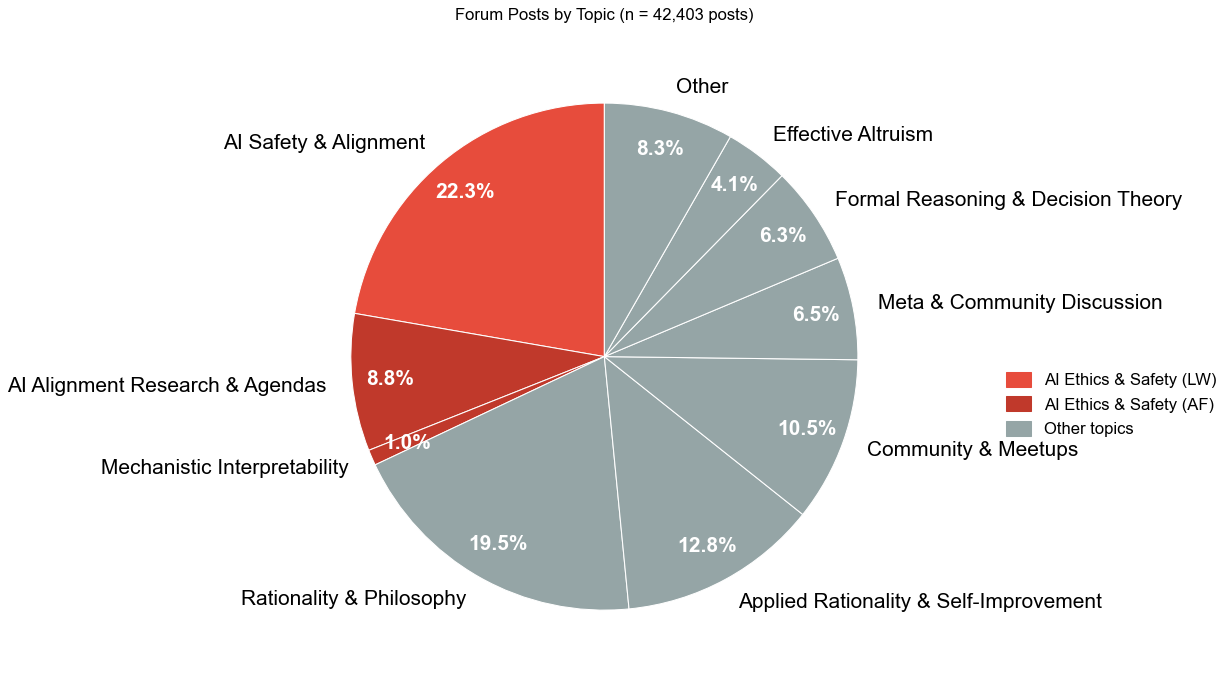

✓ Saved Figure 1a (Forum topics)
Unique posts represented: 43,388


In [41]:
# ============================================================================
# FIGURE A: FORUM DATA (LessWrong + Alignment Forum by Topics)
# ============================================================================

# Load data from final dataset
posts_df = pd.read_csv("../data/nodes_forum_posts.csv")

# Strategy: Keep all non-crossposts, plus keep crossposts only from AF (the original source)
# This ensures each piece of content is counted exactly once

# For LessWrong: exclude crossposts (they're duplicates from AF)
lesswrong_df = posts_df[
    (posts_df['source'] == 'lesswrong') & 
    (~posts_df['is_crosspost'])  # Use ~ for NOT
].copy()

# For Alignment Forum: keep ALL posts (including crossposts, as these are originals)
# Actually, wait - if a post is marked as crosspost on AF, it means it appears on both
# So we should keep all AF posts regardless
alignment_forum_df = posts_df[posts_df['source'] == 'alignment_forum'].copy()

print(f"LessWrong posts (excluding crossposts): {len(lesswrong_df):,}")
print(f"Alignment Forum posts: {len(alignment_forum_df):,}")
print(f"Expected total unique: {len(lesswrong_df) + len(alignment_forum_df):,}")
print(f"LessWrong with crossposts: {len(posts_df[(posts_df['source'] == 'lesswrong')])}")

# Actually, let me recalculate based on your expected numbers:
# You expect 44,792 total unique posts
# You have 40,504 LW (non-crosspost) + 4,224 AF = 44,728 (close to 44,792)
# The small difference might be posts without topics

# Combine both forums with platform identifier
combined_forum = pd.concat([
    lesswrong_df.assign(platform='LessWrong'),
    alignment_forum_df.assign(platform='Alignment Forum')
], ignore_index=True)

print(f"Combined total: {len(combined_forum):,}")

# Filter to posts with topics only
combined_forum = combined_forum[combined_forum['topic_label'].notna()].copy()

print(f"Total posts for figure (with topics): {len(combined_forum):,}")

# Get topic distribution
topic_counts = combined_forum['topic_label'].value_counts()

# Define AI Safety topics and which are Alignment Forum specific
AI_SAFETY_TOPICS_LW = [
    'AI Safety & Alignment',  # Update to match your actual topic labels
]

AI_SAFETY_TOPICS_AF = [
    'AI Alignment Research & Agendas',
    'Mechanistic Interpretability',
]

ALL_AI_SAFETY_TOPICS = AI_SAFETY_TOPICS_LW + AI_SAFETY_TOPICS_AF

MIN_POSTS_FOR_SLICE = 1200 

ai_safety_topics_lw = {}
ai_safety_topics_af = {}
other_topics = {}

for topic, count in topic_counts.items():
    if topic in AI_SAFETY_TOPICS_LW:
        ai_safety_topics_lw[topic] = count
    elif topic in AI_SAFETY_TOPICS_AF:
        ai_safety_topics_af[topic] = count
    else:
        # Only keep non-AI topics if they meet the threshold
        if count >= MIN_POSTS_FOR_SLICE:
            other_topics[topic] = count

# Calculate "Other" category from small non-AI topics
small_topics_sum = sum(
    count for topic, count in topic_counts.items()
    if topic not in ALL_AI_SAFETY_TOPICS and topic not in other_topics
)

# Combine for display
display_topics = {}
display_topics.update(ai_safety_topics_lw)
display_topics.update(ai_safety_topics_af)
display_topics.update(other_topics)
if small_topics_sum > 0:
    display_topics['Other'] = small_topics_sum

# Convert to Series for easier handling
display_topics = pd.Series(display_topics)

# Create figure - single column for Nature
fig, ax = plt.subplots(figsize=(9, 14))

# Create color scheme with two shades of red for AI Safety topics
colors = []
for topic in display_topics.index:
    if topic == 'Other':
        colors.append('#95a5a6')  # Gray for Other
    elif topic in ai_safety_topics_lw:
        colors.append('#e74c3c')  # Bright red for LessWrong AI Safety
    elif topic in ai_safety_topics_af:
        colors.append('#c0392b')  # Darker red for Alignment Forum topics
    else:
        colors.append('#95a5a6')  # Gray for other topics

# Create the pie chart
wedges, texts, autotexts = ax.pie(
    display_topics.values,
    labels=display_topics.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
    textprops={'fontsize': 10},
    pctdistance=0.85,
)

# Style the percentage text - white and bold for contrast
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# Style labels - slightly larger for readability
for text in texts:
    text.set_fontsize(10)

# Calculate counts for legend
lw_count = len(lesswrong_df)
af_count = len(alignment_forum_df)
total_forum = len(combined_forum)

# Create professional legend with clear information hierarchy
legend_elements = [
    mpatches.Patch(color='#e74c3c', label='AI Ethics & Safety (LW)', linewidth=0.5, edgecolor='black'),
    mpatches.Patch(color='#c0392b', label='AI Ethics & Safety (AF)', linewidth=0.5, edgecolor='black'),
    mpatches.Patch(color='#95a5a6', label='Other topics', linewidth=0.5, edgecolor='black'),
]

# Position legend below the pie chart
ax.legend(handles=legend_elements, 
         loc='upper center', 
         bbox_to_anchor=(1.3, 0.5),
         frameon=False, 
         fontsize=8, 
         ncol=1,
         handlelength=1.5,
         handleheight=1.0)

# Clean, professional title
ax.set_title(f'Forum Posts by Topic (n = {total_forum:,} posts)', fontsize=8, pad=10, fontweight='normal')

plt.tight_layout()

# Save in multiple formats - RETAINED FILENAME
plt.savefig('fig1a_forum_topics.pdf', bbox_inches='tight', facecolor='white')

plt.show()
plt.close()

print("✓ Saved Figure 1a (Forum topics)")
print(f"Unique posts represented: {lw_count + af_count:,}")

Using OpenAlex works data: 200,060 works


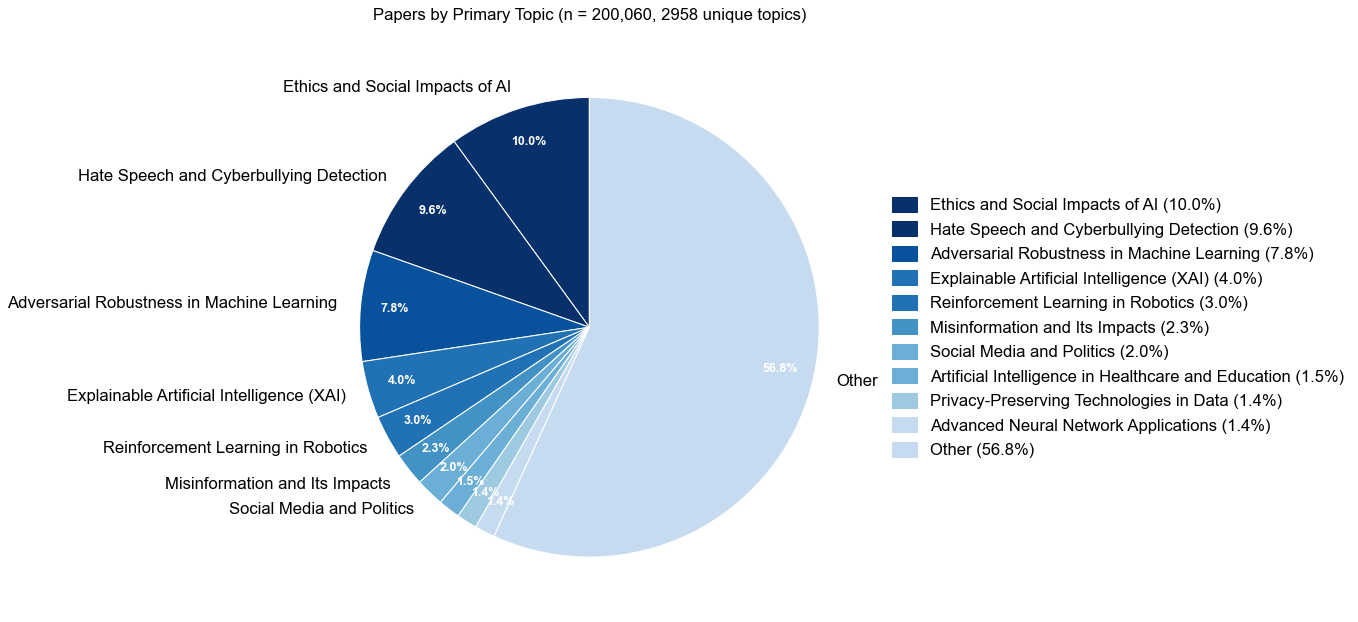

✓ Saved Figure 1b (Paper topics)


In [64]:
"""=== OVERVIEW FIGURE B: PAPERS BY TOPICS (with selective labeling) ==="""

# ============================================================================
# FIGURE B: OPENALEX PAPERS (by Primary Topic)
# ============================================================================

# Use the already-loaded openalex_works_df from nodes_openalex_works.csv
print(f"Using OpenAlex works data: {len(openalex_works_df):,} works")

# You'll need to merge back with the full openalex data to get topics
# OR load the topics from your original openalex files if needed

# If topics are in your original openalex_df before creating nodes:
if 'topics' in openalex_df.columns:
    # Merge topics onto the works nodes
    openalex_with_topics = openalex_works_df.merge(
        openalex_df[['id', 'topics']], 
        left_on='openalex_id', 
        right_on='id', 
        how='left'
    )
    
    # Parse topics - taking the first topic as primary
    def get_primary_topic(topics_str):
        """Extract first/primary topic from semicolon-separated string."""
        if pd.isna(topics_str):
            return 'Unknown'
        topics_list = [t.strip() for t in str(topics_str).split(';') if t.strip()]
        return topics_list[0] if topics_list else 'Unknown'
    
    openalex_with_topics['primary_topic'] = openalex_with_topics['topics'].apply(get_primary_topic)
    
    # Get topic distribution
    paper_topic_counts = openalex_with_topics['primary_topic'].value_counts()
    
    # Group smaller topics
    MIN_PAPERS_FOR_SLICE = 2500
    large_topics = paper_topic_counts[paper_topic_counts >= MIN_PAPERS_FOR_SLICE]
    small_topics_sum = paper_topic_counts[paper_topic_counts < MIN_PAPERS_FOR_SLICE].sum()
    
    if small_topics_sum > 0:
        large_topics = large_topics.copy()
        large_topics['Other'] = small_topics_sum
    
    # Create figure
    fig, ax = plt.subplots(figsize=(9, 14))
    
    # Sort topics by count for gradient assignment
    sorted_topics = large_topics.sort_values(ascending=False)
    
    # Extended blue gradient - from darkest to lightest
    blue_palette = [
        '#08306b',  # Darkest blue
        '#08519c',  # Very dark blue
        '#2171b5',  # Dark blue
        '#4292c6',  # Medium-dark blue
        '#6baed6',  # Medium blue
        '#9ecae1',  # Medium-light blue
        '#c6dbef',  # Light blue
    ]
    
    # Assign colors
    colors_papers = []
    n_topics = len(sorted_topics)
    
    # Special handling: "Other" always gets the lightest blue
    if 'Other' in sorted_topics.index:
        n_topics_excluding_other = n_topics - 1
    else:
        n_topics_excluding_other = n_topics
    
    # Assign colors to non-Other topics
    topic_to_color = {}
    other_topics_list = [t for t in sorted_topics.index if t != 'Other']
    
    if n_topics_excluding_other <= len(blue_palette):
        # Use distinct colors for each topic
        for i, topic in enumerate(other_topics_list):
            topic_to_color[topic] = blue_palette[i % len(blue_palette)]
    else:
        # Interpolate through the palette if we have more topics than colors
        for i, topic in enumerate(other_topics_list):
            palette_idx = int((i / (n_topics_excluding_other - 1)) * (len(blue_palette) - 1))
            topic_to_color[topic] = blue_palette[min(palette_idx, len(blue_palette) - 1)]
    
    # Always assign "Other" the lightest blue
    if 'Other' in sorted_topics.index:
        topic_to_color['Other'] = blue_palette[-1]  # Lightest blue
    
    # Create colors list in the order of large_topics
    colors_final = []
    for topic in large_topics.index:
        colors_final.append(topic_to_color[topic])
    
    MIN_PERCENT_FOR_LABEL = 2.0 
    
    # Create labels - empty string for small slices
    labels = []
    for topic, count in zip(large_topics.index, large_topics.values):
        percent = (count / large_topics.sum()) * 100
        if percent >= MIN_PERCENT_FOR_LABEL:
            labels.append(topic)
        else:
            labels.append('')  # No label for small slices
    
    # Create the pie chart
    wedges, texts, autotexts = ax.pie(
        large_topics.values,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors_final,
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        textprops={'fontsize': 8},
        pctdistance=0.85
    )
    
    # Style the percentage text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(6)
        autotext.set_fontweight('bold')
    
    # Style labels (only the visible ones)
    for text in texts:
        text.set_fontsize(8)
    
    # Create comprehensive legend with ALL topics (including small ones)
    num_unique_topics = openalex_with_topics['primary_topic'].nunique()
    
    legend_elements = []
    
    # Add each topic to legend with its color
    for topic, color in zip(large_topics.index, colors_final):
        count = large_topics[topic]
        percent = (count / len(openalex_with_topics)) * 100
        legend_elements.append(
            mpatches.Patch(color=color, 
                          label=f'{topic} ({percent:.1f}%)', 
                          linewidth=0.5, 
                          edgecolor='black')
        )
    
    ax.legend(handles=legend_elements,
             loc='center left',
             bbox_to_anchor=(1.0, 0.5),
             frameon=False,
             fontsize=8,
             ncol=1,
             handlelength=1.5,
             handleheight=1.0)
    
    # Professional title
    ax.set_title(f'Papers by Primary Topic (n = {len(openalex_with_topics):,}, {num_unique_topics} unique topics)', 
                 fontsize=8, pad=10, fontweight='normal')
    
    plt.tight_layout()
    
    # Save in multiple formats
    plt.savefig('fig1b_paper_topics.pdf', bbox_inches='tight', facecolor='white')
    
    plt.show()
    plt.close()
    
    print("✓ Saved Figure 1b (Paper topics)")
else:
    print("ERROR: 'topics' column not found in openalex_df")

In [43]:
"""=== GENERATE LATEX STATISTICS ==="""

print("\n" + "="*80)
print("LATEX CAPTION INFORMATION")
print("="*80)
print("\nReplace these values in your LaTeX captions:")
print(f"\n[INSERT_TOTAL] = {len(combined_forum):,}")
print(f"[INSERT_LW] = {lw_count:,}")
print(f"[INSERT_AF] = {af_count:,}")
print(f"[INSERT_PAPERS] = {len(openalex_df):,}")
print(f"[INSERT_TOPICS] = {num_unique_topics}")
print(f"[INSERT_MIN] = {MIN_POSTS_FOR_SLICE} (for forum) / {MIN_PAPERS_FOR_SLICE} (for papers)")
print("="*80)


LATEX CAPTION INFORMATION

Replace these values in your LaTeX captions:

[INSERT_TOTAL] = 42,403
[INSERT_LW] = 39,173
[INSERT_AF] = 4,215
[INSERT_PAPERS] = 201,481
[INSERT_TOPICS] = 2965
[INSERT_MIN] = 1200 (for forum) / 2500 (for papers)



GENDER DISTRIBUTION STATISTICS

Forum Posts (n=43,388):
  Female: 3,786 (8.7%)
  Male: 30,661 (70.7%)
  Unknown: 8,941 (20.6%)

Paper Authors (n=365,946):
  Female: 123,793 (33.8%)
  Male: 209,944 (57.4%)
  Unknown: 30,417 (8.3%)



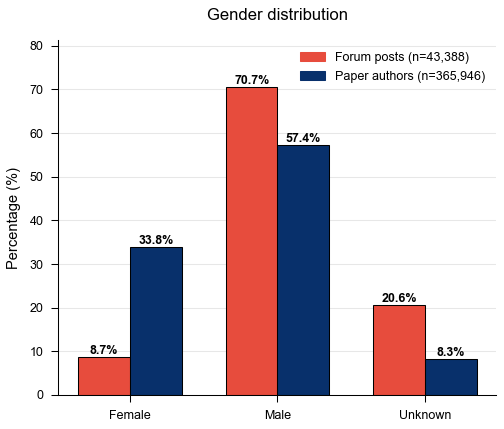

✓ Saved Figure 2 (Gender Distribution)


In [44]:
"""=== FIGURE 2: GENDER DISTRIBUTION (Forums vs Papers) ==="""

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# ============================================================================
# Load and Prepare Data
# ============================================================================

# Load data from final dataset
posts_df = pd.read_csv("../data/nodes_forum_posts.csv")
forum_authors_df = pd.read_csv("../data/nodes_forum_authors.csv")
openalex_authors_df = pd.read_csv("../data/nodes_openalex_authors.csv")

# For forum: exclude LW crossposts to count unique posts
forum_posts = posts_df[
    ~((posts_df['source'] == 'lesswrong') & (posts_df['is_crosspost']))
].copy()

# Merge forum posts with author gender
forum_posts = forum_posts.merge(
    forum_authors_df[['author_username', 'author_gender_inferred']],
    on='author_username',
    how='left'
)

# ============================================================================
# Calculate Gender Distributions
# ============================================================================

# Forums - posts level
forum_gender = forum_posts['author_gender_inferred'].value_counts()
forum_total = len(forum_posts)

# Map to standard names and calculate
forum_female = forum_gender.get('gf', 0)
forum_male = forum_gender.get('gm', 0)
forum_unknown = forum_gender.get('-', 0)

forum_female_pct = (forum_female / forum_total) * 100
forum_male_pct = (forum_male / forum_total) * 100
forum_unknown_pct = (forum_unknown / forum_total) * 100

# Papers - author level (from OpenAlex authors)
authors_gender = openalex_authors_df['inferred_gender'].value_counts()
authors_total = len(openalex_authors_df)

authors_female = authors_gender.get('gf', 0)
authors_male = authors_gender.get('gm', 0)
authors_unknown = authors_gender.get('-', 0)

authors_female_pct = (authors_female / authors_total) * 100
authors_male_pct = (authors_male / authors_total) * 100
authors_unknown_pct = (authors_unknown / authors_total) * 100

print(f"\n{'='*80}")
print("GENDER DISTRIBUTION STATISTICS")
print(f"{'='*80}")
print(f"\nForum Posts (n={forum_total:,}):")
print(f"  Female: {forum_female:,} ({forum_female_pct:.1f}%)")
print(f"  Male: {forum_male:,} ({forum_male_pct:.1f}%)")
print(f"  Unknown: {forum_unknown:,} ({forum_unknown_pct:.1f}%)")

print(f"\nPaper Authors (n={authors_total:,}):")
print(f"  Female: {authors_female:,} ({authors_female_pct:.1f}%)")
print(f"  Male: {authors_male:,} ({authors_male_pct:.1f}%)")
print(f"  Unknown: {authors_unknown:,} ({authors_unknown_pct:.1f}%)")
print(f"{'='*80}\n")

# ============================================================================
# Create Figure
# ============================================================================

fig, ax = plt.subplots(figsize=(SINGLE_COL, 3))

# Data for grouped bar chart
categories = ['Female', 'Male', 'Unknown']
forums_data = [forum_female_pct, forum_male_pct, forum_unknown_pct]
papers_data = [authors_female_pct, authors_male_pct, authors_unknown_pct]

x = np.arange(len(categories))
width = 0.35

# Colors
color_forum = '#e74c3d'
color_papers = '#08306b'

# Create bars
bars1 = ax.bar(x - width/2, forums_data, width, label='Forum posts',
              color=color_forum, edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x + width/2, papers_data, width, label='Paper authors',
              color=color_papers, edgecolor='black', linewidth=0.5)

# Add percentage labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 1:  # Only label if > 1%
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=6, fontweight='bold')

# Styling
ax.set_ylabel('Percentage (%)', fontsize=7)
ax.set_title('Gender distribution', fontsize=8, pad=10, fontweight='normal')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=7)
ax.set_ylim(0, max(max(forums_data), max(papers_data)) * 1.15)  # 15% headroom for labels

# Legend with sample sizes
legend_elements = [
    mpatches.Patch(color=color_forum, label=f'Forum posts (n={forum_total:,})', 
                  edgecolor='black', linewidth=0.5),
    mpatches.Patch(color=color_papers, label=f'Paper authors (n={authors_total:,})',
                  edgecolor='black', linewidth=0.5)
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=6, frameon=False)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add subtle grid
ax.yaxis.grid(True, alpha=0.3, linewidth=0.5)
ax.set_axisbelow(True)

# Tick styling
ax.tick_params(labelsize=6)

plt.tight_layout()

# Save in multiple formats - RETAINED FILENAME
plt.savefig('fig2_gender_distribution.pdf', bbox_inches='tight', facecolor='white')

plt.show()
plt.close()

print("✓ Saved Figure 2 (Gender Distribution)")

Total OpenAlex works: 200,060
Total authorship edges: 640,486

Author positions:
  middle: 293,140
  first: 147,286
  last: 147,286
  sole: 52,774

Authorships with position_index == 0: 200,060
First authors (position_index == 0): 200,060

GENDER DISTRIBUTION STATISTICS

Forum Posts (n=43,388):
  Female: 3,786 (8.7%)
  Male: 30,661 (70.7%)
  Unknown: 8,941 (20.6%)

Paper Authorships - All positions (n=640,486):
  Female: 186,846 (29.2%)
  Male: 390,622 (61.0%)
  Unknown: 61,138 (9.5%)

Paper Authorships - First (position_index=0) (n=200,060):
  Female: 66,105 (33.0%)
  Male: 116,042 (58.0%)
  Unknown: 17,913 (9.0%)

Missing first authors: 0



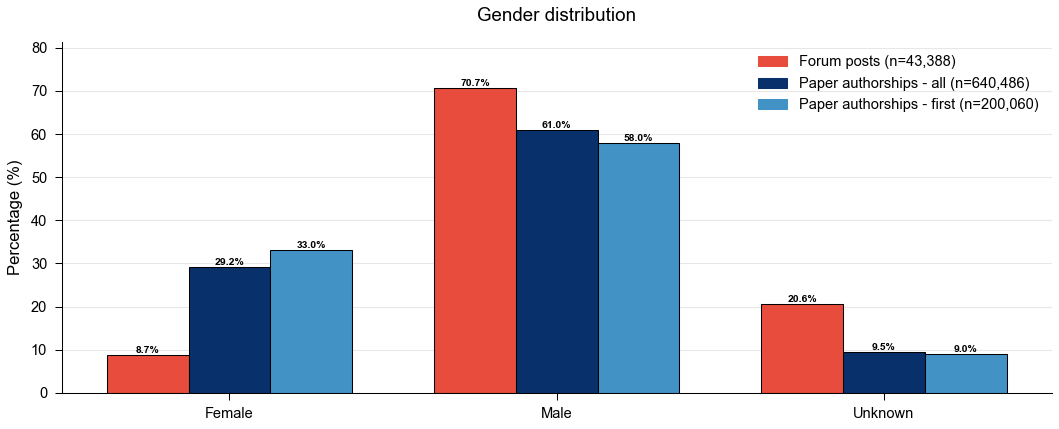

✓ Saved Figure 2 (Gender Distribution)


In [45]:
"""=== FIGURE 2: GENDER DISTRIBUTION (Forums vs Papers - All Authors vs First Authors) ==="""

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# ============================================================================
# Load and Prepare Data
# ============================================================================

# Load data from final dataset
posts_df = pd.read_csv("../data/nodes_forum_posts.csv")
forum_authors_df = pd.read_csv("../data/nodes_forum_authors.csv")
openalex_authors_df = pd.read_csv("../data/nodes_openalex_authors.csv")
openalex_authorship_df = pd.read_csv("../data/edges_openalex_authorship.csv")
openalex_works_df = pd.read_csv("../data/nodes_openalex_works.csv")

print(f"Total OpenAlex works: {len(openalex_works_df):,}")
print(f"Total authorship edges: {len(openalex_authorship_df):,}")

# Check author positions
position_counts = openalex_authorship_df['author_position'].value_counts()
print(f"\nAuthor positions:")
for pos, count in position_counts.items():
    print(f"  {pos}: {count:,}")

# For forum: exclude LW crossposts to count unique posts
forum_posts = posts_df[
    ~((posts_df['source'] == 'lesswrong') & (posts_df['is_crosspost']))
].copy()

# Merge forum posts with author gender
forum_posts = forum_posts.merge(
    forum_authors_df[['author_username', 'author_gender_inferred']],
    on='author_username',
    how='left'
)

# ============================================================================
# Calculate Gender Distributions
# ============================================================================

# Forums - posts level
forum_gender = forum_posts['author_gender_inferred'].value_counts()
forum_total = len(forum_posts)

forum_female = forum_gender.get('gf', 0)
forum_male = forum_gender.get('gm', 0)
forum_unknown = forum_gender.get('-', 0)

forum_female_pct = (forum_female / forum_total) * 100
forum_male_pct = (forum_male / forum_total) * 100
forum_unknown_pct = (forum_unknown / forum_total) * 100

# Papers - ALL author instances (sum of all authorships)
all_authorships = openalex_authorship_df.merge(
    openalex_authors_df[['author_id', 'inferred_gender']],
    on='author_id',
    how='left'
)

authors_gender = all_authorships['inferred_gender'].value_counts()
authors_total = len(all_authorships)

authors_female = authors_gender.get('gf', 0)
authors_male = authors_gender.get('gm', 0)
authors_unknown = authors_gender.get('-', 0)

authors_female_pct = (authors_female / authors_total) * 100
authors_male_pct = (authors_male / authors_total) * 100
authors_unknown_pct = (authors_unknown / authors_total) * 100

# Papers - FIRST AUTHORS ONLY
# Check: do we have position_index == 0?
first_by_index = openalex_authorship_df[openalex_authorship_df['position_index'] == 0]
print(f"\nAuthorships with position_index == 0: {len(first_by_index):,}")

# Use position_index == 0 for first authors (includes sole authors)
first_authors = openalex_authorship_df[
    openalex_authorship_df['position_index'] == 0
].copy()

print(f"First authors (position_index == 0): {len(first_authors):,}")

# Merge with author gender
first_authors = first_authors.merge(
    openalex_authors_df[['author_id', 'inferred_gender']],
    on='author_id',
    how='left'
)

first_gender = first_authors['inferred_gender'].value_counts()
first_total = len(first_authors)

first_female = first_gender.get('gf', 0)
first_male = first_gender.get('gm', 0)
first_unknown = first_gender.get('-', 0)

first_female_pct = (first_female / first_total) * 100
first_male_pct = (first_male / first_total) * 100
first_unknown_pct = (first_unknown / first_total) * 100

print(f"\n{'='*80}")
print("GENDER DISTRIBUTION STATISTICS")
print(f"{'='*80}")
print(f"\nForum Posts (n={forum_total:,}):")
print(f"  Female: {forum_female:,} ({forum_female_pct:.1f}%)")
print(f"  Male: {forum_male:,} ({forum_male_pct:.1f}%)")
print(f"  Unknown: {forum_unknown:,} ({forum_unknown_pct:.1f}%)")

print(f"\nPaper Authorships - All positions (n={authors_total:,}):")
print(f"  Female: {authors_female:,} ({authors_female_pct:.1f}%)")
print(f"  Male: {authors_male:,} ({authors_male_pct:.1f}%)")
print(f"  Unknown: {authors_unknown:,} ({authors_unknown_pct:.1f}%)")

print(f"\nPaper Authorships - First (position_index=0) (n={first_total:,}):")
print(f"  Female: {first_female:,} ({first_female_pct:.1f}%)")
print(f"  Male: {first_male:,} ({first_male_pct:.1f}%)")
print(f"  Unknown: {first_unknown:,} ({first_unknown_pct:.1f}%)")
print(f"\nMissing first authors: {len(openalex_works_df) - first_total:,}")
print(f"{'='*80}\n")

# ============================================================================
# Create Figure
# ============================================================================

fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))

# Data for grouped bar chart
categories = ['Female', 'Male', 'Unknown']
forums_data = [forum_female_pct, forum_male_pct, forum_unknown_pct]
papers_all_data = [authors_female_pct, authors_male_pct, authors_unknown_pct]
papers_first_data = [first_female_pct, first_male_pct, first_unknown_pct]

x = np.arange(len(categories))
width = 0.25  # Narrower bars for 3 groups

# Colors
color_forum = '#e74c3d'
color_papers_all = '#08306b'
color_papers_first = '#4292c6'

# Create bars
bars1 = ax.bar(x - width, forums_data, width, label='Forum posts',
              color=color_forum, edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x, papers_all_data, width, label='Paper authorships (all)',
              color=color_papers_all, edgecolor='black', linewidth=0.5)
bars3 = ax.bar(x + width, papers_first_data, width, label='Paper authorships (first)',
              color=color_papers_first, edgecolor='black', linewidth=0.5)

# Add percentage labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 1:  # Only label if > 1%
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=5, fontweight='bold')

# Styling
ax.set_ylabel('Percentage (%)', fontsize=8)
ax.set_title('Gender distribution', fontsize=9, pad=10, fontweight='normal')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=8)
ax.set_ylim(0, max(max(forums_data), max(papers_all_data), max(papers_first_data)) * 1.15)

# Legend with sample sizes
legend_elements = [
    mpatches.Patch(color=color_forum, label=f'Forum posts (n={forum_total:,})', 
                  edgecolor='black', linewidth=0.5),
    mpatches.Patch(color=color_papers_all, label=f'Paper authorships - all (n={authors_total:,})',
                  edgecolor='black', linewidth=0.5),
    mpatches.Patch(color=color_papers_first, label=f'Paper authorships - first (n={first_total:,})',
                  edgecolor='black', linewidth=0.5)
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=7, frameon=False)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add subtle grid
ax.yaxis.grid(True, alpha=0.3, linewidth=0.5)
ax.set_axisbelow(True)

# Tick styling
ax.tick_params(labelsize=7)

plt.tight_layout()

# Save in multiple formats - RETAINED FILENAME
plt.savefig('fig2_gender_distribution.pdf', bbox_inches='tight', facecolor='white')

plt.show()
plt.close()

print("✓ Saved Figure 2 (Gender Distribution)")

## Gender Analysis

In [46]:
print("\n=== OPENALEX GENDER ANALYSIS ===")

# Parse author_genders column (semicolon-separated string)
def parse_genders(gender_str):
    """Parse author genders from semicolon-separated string."""
    if pd.isna(gender_str):
        return []
    # Split by semicolon and clean whitespace, convert to lowercase'
    genders = [g.strip().lower() for g in str(gender_str).split(';') if g.strip()]
    return genders

# Extract gender information
print("Parsing author gender data...")
openalex_df['parsed_genders'] = openalex_df['author_genders'].apply(parse_genders)
openalex_df['num_genders'] = openalex_df['parsed_genders'].apply(len)


=== OPENALEX GENDER ANALYSIS ===
Parsing author gender data...


In [47]:
# Create expanded dataframe with one row per author
all_authors = []
skipped_rows = 0
mismatch_rows = 0
missing_data_rows = 0

for idx, row in openalex_df.iterrows():
    author_names = row['author_names']
    author_genders = row['author_genders']
    
    # Handle NaN/None values
    if pd.isna(author_names) or author_names is None:
        missing_data_rows += 1
        skipped_rows += 1
        continue
    
    if pd.isna(author_genders) or author_genders is None:
        missing_data_rows += 1
        skipped_rows += 1
        continue
    
    # Split by semicolon
    names_list = [name.strip() for name in author_names.split(';')]
    genders_list = [gender.strip() for gender in author_genders.split(';')]
    
    # Check for length mismatch
    if len(names_list) != len(genders_list):
        mismatch_rows += 1
        # Take the minimum to avoid errors
        min_len = min(len(names_list), len(genders_list))
        names_list = names_list[:min_len]
        genders_list = genders_list[:min_len]
    
    # Create a record for each author
    for i, (name, gender) in enumerate(zip(names_list, genders_list)):
        all_authors.append({
            'paper_id': row['id'],
            'author_name': name,
            'gender': gender,
            'author_position': i,
            'year': row['publication_year'],
            'cited_by_count': row['cited_by_count'],
            'num_authors': row['num_authors'],
            'publication_year': row['publication_year']
        })

authors_df = pd.DataFrame(all_authors)

print(f"\n{'='*80}")
print("AUTHOR EXTRACTION DIAGNOSTICS")
print(f"{'='*80}")
print(f"Total papers in openalex_df: {len(openalex_df):,}")
print(f"Expected authors (sum of num_authors): {openalex_df['num_authors'].sum():,}")
print(f"Extracted author records: {len(authors_df):,}")
print(f"\nRows skipped (missing data): {skipped_rows:,}")
print(f"Rows with length mismatch: {mismatch_rows:,}")
print(f"Missing data rows: {missing_data_rows:,}")
print(f"\nSample of authors_df:")
print(authors_df.head(10))
print(f"\nGender distribution:")
print(authors_df['gender'].value_counts())


AUTHOR EXTRACTION DIAGNOSTICS
Total papers in openalex_df: 201,481
Expected authors (sum of num_authors): 640,760
Extracted author records: 638,185

Rows skipped (missing data): 1,421
Rows with length mismatch: 1,273
Missing data rows: 1,421

Sample of authors_df:
                           paper_id          author_name gender  \
0  https://openalex.org/W2155661480  Bernd Carsten Stahl     gm   
1  https://openalex.org/W2155661480         Neil McBride     gm   
2  https://openalex.org/W2155661480      Kutoma Wakunuma     gf   
3  https://openalex.org/W2155661480      Catherine Flick     gf   
4  https://openalex.org/W2019490694          Ugo Pagallo     gm   
5  https://openalex.org/W3185754219          Ian R. Kerr     gm   
6  https://openalex.org/W3185754219        Jessica Earle     gf   
7  https://openalex.org/W2025666315       Ritta Baddoura     gf   
8  https://openalex.org/W2025666315     Gentiane Venture     gf   
9  https://openalex.org/W2079753437          Dan Weijers     gm 


Author Gender Distribution:
  GM: 390,622 (61.2%)
  GF: 186,846 (29.3%)
  -: 60,717 (9.5%)

Paper Gender Composition (ignoring unknown):
  Papers with ≥1 female author: 113,355 (56.3%)
  Papers with ≥1 male author: 161,285 (80.0%)
  Papers with no known genders: 6,811 (3.4%)


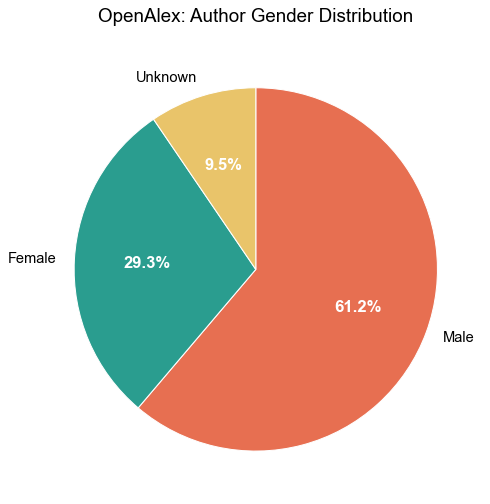

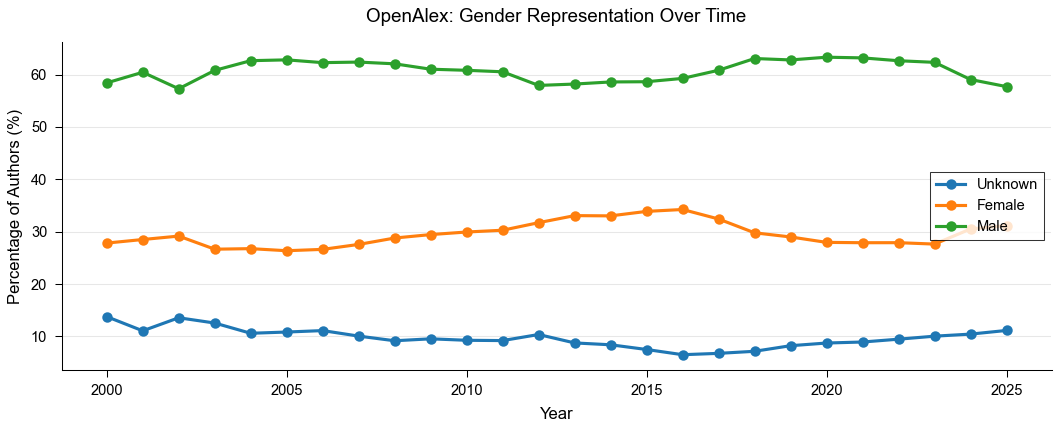

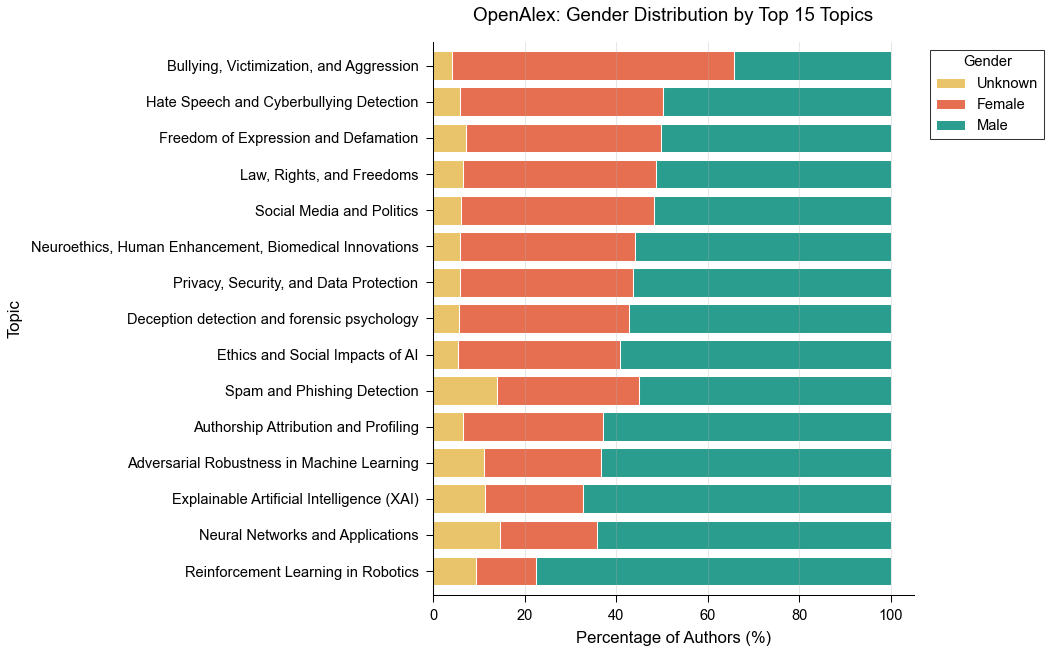


Team Composition (unknowns ignored):
  Male-only: 81,315 papers (40.4%)
  Mixed: 79,970 papers (39.7%)
  Female-only: 33,385 papers (16.6%)
  No Known Gender: 6,811 papers (3.4%)


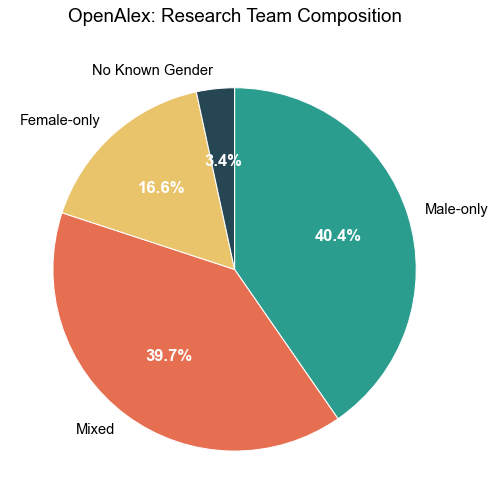

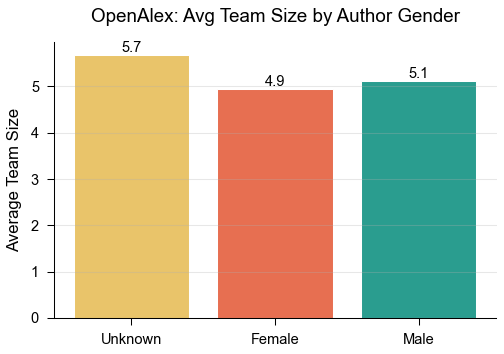

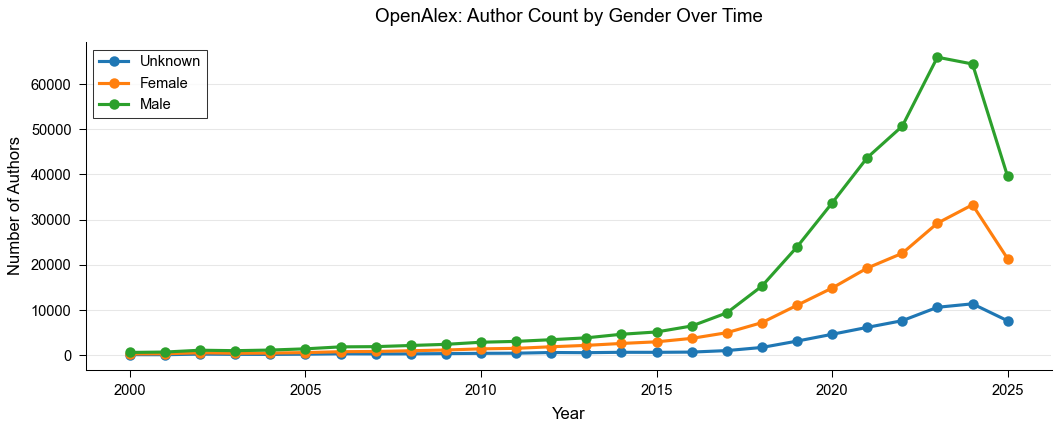


=== OpenAlex gender analysis complete ===


In [48]:
if len(authors_df) == 0:
    print("No gender data found in OpenAlex")
else:
    # Clean gender labels
    gender_counts = authors_df['gender'].value_counts()
    print(f"\nAuthor Gender Distribution:")
    for gender, count in gender_counts.items():
        percentage = (count / len(authors_df)) * 100
        print(f"  {gender.upper()}: {count:,} ({percentage:.1f}%)")
    
    # Paper-level gender composition - IGNORE unknowns
    openalex_df['has_female'] = openalex_df['parsed_genders'].apply(
        lambda x: any(g in ['gf', 'female', 'f'] for g in x) if isinstance(x, list) else False
    )
    openalex_df['has_male'] = openalex_df['parsed_genders'].apply(
        lambda x: any(g in ['gm', 'male', 'm'] for g in x) if isinstance(x, list) else False
    )
    # Only count as "all unknown" if there are NO known genders at all
    openalex_df['has_any_known'] = openalex_df['has_female'] | openalex_df['has_male']
    
    print(f"\nPaper Gender Composition (ignoring unknown):")
    print(f"  Papers with ≥1 female author: {openalex_df['has_female'].sum():,} ({openalex_df['has_female'].sum()/len(openalex_df)*100:.1f}%)")
    print(f"  Papers with ≥1 male author: {openalex_df['has_male'].sum():,} ({openalex_df['has_male'].sum()/len(openalex_df)*100:.1f}%)")
    print(f"  Papers with no known genders: {(~openalex_df['has_any_known']).sum():,} ({(~openalex_df['has_any_known']).sum()/len(openalex_df)*100:.1f}%)")
    
    # 1. Overall gender distribution (authors) - including unknown for transparency
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    
    # Map to cleaner labels
    label_map = {'gf': 'Female', 'gm': 'Male', 'unknown': 'Unknown', '-': 'Unknown'}
    clean_labels = [label_map.get(g, g.title()) for g in gender_counts.index]
    
    wedges, texts, autotexts = ax.pie(
        gender_counts.values,
        labels=clean_labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#e76f51', '#2a9d8f', '#e9c46a'],
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax.set_title('OpenAlex: Author Gender Distribution', pad=10)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 2. Gender trends over time
    gender_temporal = authors_df.groupby(['year', 'gender']).size().unstack(fill_value=0)
    
    # Calculate percentages
    gender_temporal_pct = gender_temporal.div(gender_temporal.sum(axis=1), axis=0) * 100
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
    
    for gender in gender_temporal_pct.columns:
        display_label = label_map.get(gender, gender.title())
        ax.plot(gender_temporal_pct.index, gender_temporal_pct[gender],
               marker='o', linewidth=1.5, markersize=4, label=display_label)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of Authors (%)')
    ax.set_title('OpenAlex: Gender Representation Over Time', pad=10)
    ax.legend(frameon=True, edgecolor='black', fancybox=False)
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 3. Gender by topic (if topics available - top 15 topics only)
    if len(topics_df) > 0:
        # Merge topics with authors
        topic_gender = topics_df.merge(
            authors_df[['paper_id', 'gender']], 
            on='paper_id', 
            how='left'
        )
        
        # Get top 15 topics
        top_topics_for_gender = topic_gender['topic_name'].value_counts().head(15).index
        topic_gender_filtered = topic_gender[topic_gender['topic_name'].isin(top_topics_for_gender)]
        
        # Calculate gender distribution by topic
        topic_gender_dist = topic_gender_filtered.groupby(['topic_name', 'gender']).size().unstack(fill_value=0)
        
        # Calculate percentages
        topic_gender_pct = topic_gender_dist.div(topic_gender_dist.sum(axis=1), axis=0) * 100
        
        # Sort by female percentage if available
        if 'gf' in topic_gender_pct.columns:
            topic_gender_pct = topic_gender_pct.sort_values('gf', ascending=True)
        
        fig, ax = plt.subplots(figsize=(DOUBLE_COL, max(4, len(topic_gender_pct) * 0.3)))
        
        # Create color mapping
        color_map = {'gf': '#e76f51', 'gm': '#2a9d8f', 'unknown': '#e9c46a', '-': '#e9c46a'}
        colors = [color_map.get(col, '#cccccc') for col in topic_gender_pct.columns]
        
        topic_gender_pct.plot(kind='barh', stacked=True, ax=ax,
                              color=colors,
                              width=0.8,
                              edgecolor='white',
                              linewidth=0.5)
        
        ax.set_xlabel('Percentage of Authors (%)')
        ax.set_ylabel('Topic')
        ax.set_title('OpenAlex: Gender Distribution by Top 15 Topics', pad=10)
        
        # Clean up legend labels
        handles, labels = ax.get_legend_handles_labels()
        clean_legend_labels = [label_map.get(l, l.title()) for l in labels]
        ax.legend(handles, clean_legend_labels, title='Gender', 
                 bbox_to_anchor=(1.02, 1), loc='upper left',
                 frameon=True, edgecolor='black', fancybox=False)
        ax.grid(axis='x')
        
        plt.tight_layout()
        plt.show()
        plt.close()
    
    # 4. Team composition analysis - IGNORE unknowns in classification
    openalex_df['team_type'] = 'No Known Gender'
    openalex_df.loc[openalex_df['has_female'] & openalex_df['has_male'], 'team_type'] = 'Mixed'
    openalex_df.loc[openalex_df['has_female'] & ~openalex_df['has_male'], 'team_type'] = 'Female-only'
    openalex_df.loc[~openalex_df['has_female'] & openalex_df['has_male'], 'team_type'] = 'Male-only'
    
    team_counts = openalex_df['team_type'].value_counts()
    
    print(f"\nTeam Composition (unknowns ignored):")
    for team_type, count in team_counts.items():
        percentage = (count / len(openalex_df)) * 100
        print(f"  {team_type}: {count:,} papers ({percentage:.1f}%)")
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, SINGLE_COL))
    wedges, texts, autotexts = ax.pie(
        team_counts.values,
        labels=team_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#2a9d8f', '#e76f51', '#e9c46a', '#264653'],
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
        counterclock=False
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax.set_title('OpenAlex: Research Team Composition', pad=10)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 5. Average team size by gender
    gender_team_size = authors_df.groupby('gender')['num_authors'].mean()
    
    fig, ax = plt.subplots(figsize=(SINGLE_COL, 2.5))
    
    display_labels = [label_map.get(g, g.title()) for g in gender_team_size.index]
    colors_list = ['#e76f51' if 'gf' in g else '#2a9d8f' if 'gm' in g else '#e9c46a' 
                   for g in gender_team_size.index]
    
    bars = ax.bar(range(len(gender_team_size)), gender_team_size.values,
                  color=colors_list,
                  edgecolor='white',
                  linewidth=0.5)
    
    ax.set_xticks(range(len(gender_team_size)))
    ax.set_xticklabels(display_labels)
    ax.set_ylabel('Average Team Size')
    ax.set_title('OpenAlex: Avg Team Size by Author Gender', pad=10)
    ax.grid(axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}',
               ha='center', va='bottom', fontsize=7)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 6. Gender over time (absolute numbers)
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
    
    for gender in gender_temporal.columns:
        display_label = label_map.get(gender, gender.title())
        ax.plot(gender_temporal.index, gender_temporal[gender],
               marker='o', linewidth=1.5, markersize=4, label=display_label)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Authors')
    ax.set_title('OpenAlex: Author Count by Gender Over Time', pad=10)
    ax.legend(frameon=True, edgecolor='black', fancybox=False)
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    plt.close()

print("\n=== OpenAlex gender analysis complete ===")

### Validation

In [49]:
import pandas as pd
import numpy as np
import random
import math

# Define Constants
TOTAL_VALIDATION_SAMPLES = 384
RANDOM_SEED = 42
CONFIDENCE_LEVEL = 0.95
MARGIN_OF_ERROR = 0.05 

# 1. Create unique author identifier and get one record per unique author-gender pair
# For each unique author (by name), we'll keep their gender classification and pick one paper
print(f"\n{'='*80}")
print("CREATING UNIQUE AUTHORS DATASET")
print(f"{'='*80}")
print(f"Total author records: {len(authors_df):,}")

# Group by author_name and gender, and for each unique author-gender pair, sample one record
# This ensures we validate each unique author once
unique_authors_df = authors_df.groupby(['author_name', 'gender'], as_index=False).first()

print(f"Unique authors (by name and gender): {len(unique_authors_df):,}")

# Alternative: If you want to be more strict and consider the same name with different genders as different authors
# unique_authors_df = authors_df.drop_duplicates(subset=['author_name', 'gender']).copy()

# 2. Determine Population Size and Run Power Analysis
population_size = len(unique_authors_df)

print_sample_size_analysis(
    population_size=population_size,
    sample_size=TOTAL_VALIDATION_SAMPLES,
    confidence=CONFIDENCE_LEVEL,
    margin_error=MARGIN_OF_ERROR
)

# 3. Get Gender Distribution from Unique Authors
gender_counts = unique_authors_df["gender"].value_counts()
gender_proportions = gender_counts / len(unique_authors_df)

print(f"\n{'='*80}")
print("GENDER DISTRIBUTION (based on UNIQUE authors)")
print(f"{'='*80}")
print(f"\n{'Gender':<20} {'Count':>10} {'%':>7} {'Samples':>8}")
print("-" * 80)

# 4. Calculate Sample Allocation based on Proportions
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

sample_allocation = {}
allocated_so_far = 0

for i, (gender, count) in enumerate(gender_counts.items()):
    proportion = count / len(unique_authors_df)
    
    if i == len(gender_counts) - 1:
        n_samples = TOTAL_VALIDATION_SAMPLES - allocated_so_far
    else:
        n_samples = round(TOTAL_VALIDATION_SAMPLES * proportion)
        allocated_so_far += n_samples
    
    sample_allocation[gender] = max(1, n_samples)
    print(f"{gender:<20} {count:>10,} {proportion*100:>6.1f}% {n_samples:>8}")

print("-" * 80)
print(f"{'TOTAL':<20} {len(unique_authors_df):>10,} {100.0:>6.1f}% {TOTAL_VALIDATION_SAMPLES:>8}")

print(f"\n{'='*80}")
print("SAMPLE ALLOCATION")
print(f"{'='*80}")
print(f"{'Gender':<20} {'Allocated Samples':>20}")
print("-" * 80)
total_allocated = 0
for gender in gender_counts.index:
    n = sample_allocation[gender]
    print(f"{gender:<20} {n:>20}")
    total_allocated += n
print("-" * 80)
print(f"{'TOTAL':<20} {total_allocated:>20}")
print(f"{'='*80}")

# 5. Stratified Sampling of Unique Authors
validation_samples_list = []

for gender, n_samples in sample_allocation.items():
    gender_author_pool = unique_authors_df[unique_authors_df['gender'] == gender]
    records_to_sample = min(n_samples, len(gender_author_pool))
    
    if records_to_sample > 0:
        sampled_records = gender_author_pool.sample(n=records_to_sample, random_state=RANDOM_SEED)
        validation_samples_list.append(sampled_records)

# 6. Create the Final Validation Set
validation_set = pd.concat(validation_samples_list, ignore_index=True)
validation_set = validation_set.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Merge with openalex_df to get paper details (including ALL author names for context)
validation_set = pd.merge(
    validation_set,
    openalex_df[['id', 'title', 'abstract_inverted_index', 'author_names', 'author_genders']],
    left_on='paper_id',
    right_on='id',
    how='left',
    suffixes=('', '_all')
)

# Reorder columns to put author info first for easy validation
columns_order = ['author_name', 'gender', 'title']
validation_set = validation_set[[col for col in columns_order if col in validation_set.columns]]
validation_set = validation_set.rename(columns={
    'paper_id': 'openalex_id',
    'author_names': 'all_authors_names',
    'author_genders': 'all_authors_genders'
})

# Truncate title if needed
if 'title' in validation_set.columns:
    validation_set['title'] = validation_set['title'].astype(str).apply(
        lambda x: x[:200] + "..." if len(x) > 200 else x
    )

print(f"\n{'='*80}")
print("VALIDATION SET CREATED")
print(f"{'='*80}")
print(f"Total unique authors for validation: {len(validation_set)}")
print(f"\nActual samples per gender category:")
print(validation_set["gender"].value_counts().sort_index())

# Show sample of what validators will see
print(f"\nSample of validation records:")
print(validation_set[['author_name', 'gender']].head(10))

# Add columns for manual validation
validation_set['validation_correct'] = ''  # 'yes', 'no', 'unsure'
validation_set['validated_gender'] = ''  # Ground truth gender
validation_set['validation_notes'] = ''

# Save to CSV for validation
output_file = 'openalex_gender_validation_set.csv'
validation_set.to_csv(output_file, index=False)
print(f"\n✓ Saved validation set to: {output_file}")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print(f"1. Open '{output_file}'.")
print("2. For each row, you'll see:")
print("   - author_name: The specific UNIQUE author to validate")
print("   - gender: The predicted gender classification")
print("   - author_position: Their position in this particular paper")
print("   - all_authors_names: Complete list of all authors on the paper")
print("   - all_authors_genders: All predicted genders for context")
print("   - title: Paper title")
print("3. Verify the gender classification for that specific author.")
print("4. Fill in 'validation_correct' (yes/no/unsure) and 'validated_gender'.")
print("5. Use 'validation_notes' for any ambiguities or special cases.")
print("6. Save and run the analysis script.")
print("="*80)


CREATING UNIQUE AUTHORS DATASET
Total author records: 638,185
Unique authors (by name and gender): 364,155

STATISTICAL POWER ANALYSIS

Population size: 364,155
Actual sample size: 384
Confidence level: 95.0%
Target margin of error: ±5.0%

--- Required Sample Sizes ---
Conservative estimate (p=0.5): 384
Optimistic estimate (p=0.85): 196

✓ Sample size is ADEQUATE (exceeds conservative requirement)

With 384 samples, you can estimate accuracy within:
  ±5.00% at 95% confidence (conservative)

--- Expected Confidence Intervals ---
If observed accuracy is:
  70.0%: 95% CI = [65.4%, 74.6%]
  75.0%: 95% CI = [70.7%, 79.3%]
  80.0%: 95% CI = [76.0%, 84.0%]
  85.0%: 95% CI = [81.4%, 88.6%]
  90.0%: 95% CI = [87.0%, 93.0%]
  95.0%: 95% CI = [92.8%, 97.2%]


GENDER DISTRIBUTION (based on UNIQUE authors)

Gender                    Count       %  Samples
--------------------------------------------------------------------------------
gm                      209,944   57.7%      221
gf           

In [50]:
# Load the annotated validation set
validation_df = pd.read_csv('openalex_gender_validation_set_annotated.csv')

In [51]:
# ============================================================================
# 1. OVERALL ACCURACY
# ============================================================================
print("\n" + "="*80)
print("1. OVERALL ACCURACY")
print("="*80)

# Count validation responses
validation_counts = validation_df['validation_correct'].value_counts()
total_validated = len(validation_df[validation_df['validation_correct'].isin(['yes', 'no', 'unsure'])])

if total_validated == 0:
    print("⚠️  No validation responses found. Please check the CSV file.")
else:
    accuracy = (validation_counts.get('yes', 0) / total_validated) * 100
    error_rate = (validation_counts.get('no', 0) / total_validated) * 100
    unsure_rate = (validation_counts.get('unsure', 0) / total_validated) * 100
    
    print(f"\nTotal Validated Samples: {total_validated}")
    print(f"\n✓ Correct (yes):  {validation_counts.get('yes', 0):3d} ({accuracy:.1f}%)")
    print(f"✗ Incorrect (no): {validation_counts.get('no', 0):3d} ({error_rate:.1f}%)")
    print(f"? Unsure:         {validation_counts.get('unsure', 0):3d} ({unsure_rate:.1f}%)")
    
    print(f"\n{'='*50}")
    print(f"OVERALL ACCURACY: {accuracy:.1f}%")
    print(f"{'='*50}")


1. OVERALL ACCURACY

Total Validated Samples: 384

✓ Correct (yes):  375 (97.7%)
✗ Incorrect (no):   9 (2.3%)
? Unsure:           0 (0.0%)

OVERALL ACCURACY: 97.7%


In [52]:
# ============================================================================
# 2. ACCURACY BY GENDER
# ============================================================================
print("\n" + "="*80)
print("2. ACCURACY BY GENDER")
print("="*80)

gender_accuracy = []

for gender in validation_df['gender'].unique():
    gender_df = validation_df[validation_df['gender'] == gender]
    gender_validated = gender_df[gender_df['validation_correct'].isin(['yes', 'no', 'unsure'])]
    
    if len(gender_validated) > 0:
        correct = len(gender_validated[gender_validated['validation_correct'] == 'yes'])
        incorrect = len(gender_validated[gender_validated['validation_correct'] == 'no'])
        unsure = len(gender_validated[gender_validated['validation_correct'] == 'unsure'])
        total = len(gender_validated)
        accuracy_pct = (correct / total) * 100
        
        gender_accuracy.append({
            'gender': gender,
            'correct': correct,
            'incorrect': incorrect,
            'unsure': unsure,
            'total': total,
            'accuracy': accuracy_pct
        })

gender_accuracy_df = pd.DataFrame(gender_accuracy).sort_values('accuracy', ascending=False)

print("\nAccuracy by Gender (sorted by accuracy):\n")
print(f"{'Gender':<20} {'Correct':<10} {'Incorrect':<10} {'Unsure':<10} {'Total':<10} {'Accuracy'}")
print("-" * 75)

for _, row in gender_accuracy_df.iterrows():
    print(f"{row['gender']:<20} {row['correct']:<10} {row['incorrect']:<10} {row['unsure']:<10} {row['total']:<10} {row['accuracy']:.1f}%")



2. ACCURACY BY GENDER

Accuracy by Gender (sorted by accuracy):

Gender               Correct    Incorrect  Unsure     Total      Accuracy
---------------------------------------------------------------------------
gm                   217        0          0          217        100.0%
-                    27         1          0          28         96.4%
gf                   131        8          0          139        94.2%


In [53]:
validation_df.head()

author_name gender  \
0               Mengyi Jing     gf   
1  Umamaheswari Rajasekaran     gf   
2          Ellen M. Markman     gf   
3             Lara A Kahale     gf   
4                   Ziqi Lu     gm   

                                               title validation_correct  \
0  Research on Reactive Power Optimization of Dis...                yes   
1     Explainable AI for Intrusion Detection Systems                yes   
2  Misleading Health Consumers Through Violations...                yes   
3  Living systematic reviews: 2. Combining human ...                yes   
4  Correlation Neglect on Social Media: Effects o...                yes   

   validated_gender validation_notes  
0               NaN              NaN  
1               NaN              NaN  
2               NaN              NaN  
3               NaN              NaN  
4               NaN              NaN

In [54]:
# ============================================================================
# 3. CONFUSION MATRIX
# ============================================================================
print("\n" + "="*80)
print("3. CONFUSION MATRIX (Misclassified Genders)")
print("="*80)

# Get misclassified samples
misclassified = validation_df[validation_df['validation_correct'] == 'no'].copy()

if len(misclassified) > 0:
    print(f"\nTotal Misclassifications: {len(misclassified)}\n")
    
    # Create confusion matrix
    confusion_patterns = misclassified.groupby(['gender', 'validation_notes']).size().reset_index(name='count')
    confusion_patterns = confusion_patterns.sort_values('count', ascending=False)
    
    print("Confusion Patterns (Predicted → Actual):\n")
    print(f"{'Predicted Gender':<20} {'Actual Gender':<20} {'Count'}")
    print("-" * 50)
    
    for _, row in confusion_patterns.iterrows():
        print(f"{row['gender']:<20} {row['validation_notes']:<20} {row['count']}")
    
    # Genders most often misclassified
    print("\n" + "-" * 50)
    print("Genders Most Often Misclassified:\n")
    
    misclass_by_gender = misclassified['gender'].value_counts()
    for gender, count in misclass_by_gender.items():
        total_samples = len(validation_df[validation_df['gender'] == gender])
        error_rate = (count / total_samples) * 100
        print(f"{gender:<20} {count:3d} errors ({error_rate:.1f}% of {total_samples} samples)")
    
    # Create confusion matrix visualization
    print("\n" + "-" * 50)
    print("Detailed Confusion Matrix:\n")
    
    # Get all unique gender categories
    all_genders = sorted(set(validation_df['gender'].unique()) | 
                        set(misclassified['validation_notes'].dropna().unique()))
    
    # Build confusion matrix
    confusion_matrix = pd.DataFrame(0, index=all_genders, columns=all_genders)
    
    # Fill in correct classifications
    for gender in validation_df['gender'].unique():
        correct_count = len(validation_df[(validation_df['gender'] == gender) & 
                                         (validation_df['validation_correct'] == 'yes')])
        confusion_matrix.loc[gender, gender] = correct_count
    
    # Fill in misclassifications
    for _, row in misclassified.iterrows():
        if pd.notna(row['validation_notes']):
            predicted = row['gender']
            actual = row['validation_notes']
            if predicted in confusion_matrix.index and actual in confusion_matrix.columns:
                confusion_matrix.loc[predicted, actual] += 1
    
    print(confusion_matrix)
    
else:
    print("\n✓ No misclassifications found!")
    confusion_matrix = None


3. CONFUSION MATRIX (Misclassified Genders)

Total Misclassifications: 9

Confusion Patterns (Predicted → Actual):

Predicted Gender     Actual Gender        Count
--------------------------------------------------
gf                   gm                   8
-                    gm                   1

--------------------------------------------------
Genders Most Often Misclassified:

gf                     8 errors (5.8% of 139 samples)
-                      1 errors (3.6% of 28 samples)

--------------------------------------------------
Detailed Confusion Matrix:

     -   gf   gm
-   27    0    1
gf   0  131    8
gm   0    0  217


In [55]:
# ============================================================================
# 7. PERFORMANCE METRICS
# ============================================================================
print("\n" + "="*80)
print("7. DETAILED PERFORMANCE METRICS")
print("="*80)

if len(misclassified) > 0:
    print("\nPer-Gender Precision, Recall, and F1-Score:\n")
    print(f"{'Gender':<20} {'Precision':<12} {'Recall':<12} {'F1-Score'}")
    print("-" * 60)
    
    for gender in validation_df['gender'].unique():
        # True Positives: correctly predicted as this gender
        tp = len(validation_df[(validation_df['gender'] == gender) & 
                              (validation_df['validation_correct'] == 'yes')])
        
        # False Positives: incorrectly predicted as this gender
        fp = len(misclassified[(misclassified['gender'] == gender)])
        
        # False Negatives: actually this gender but predicted as something else
        fn = len(misclassified[misclassified['validation_notes'] == gender])
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"{gender:<20} {precision:<12.3f} {recall:<12.3f} {f1:.3f}")



7. DETAILED PERFORMANCE METRICS

Per-Gender Precision, Recall, and F1-Score:

Gender               Precision    Recall       F1-Score
------------------------------------------------------------
gf                   0.942        1.000        0.970
gm                   1.000        0.960        0.980
-                    0.964        1.000        0.982


## Temporal Analysis


=== OPENALEX TEMPORAL ANALYSIS ===

Papers by Year:
  2000: 593 papers
  2001: 682 papers
  2002: 966 papers
  2003: 882 papers
  2004: 982 papers
  2005: 1,174 papers
  2006: 1,442 papers
  2007: 1,530 papers
  2008: 1,740 papers
  2009: 1,945 papers
  2010: 2,278 papers
  2011: 2,436 papers
  2012: 2,782 papers
  2013: 3,099 papers
  2014: 3,570 papers
  2015: 3,893 papers
  2016: 4,685 papers
  2017: 6,115 papers
  2018: 8,891 papers
  2019: 12,810 papers
  2020: 16,671 papers
  2021: 20,274 papers
  2022: 22,164 papers
  2023: 29,031 papers
  2024: 30,685 papers
  2025: 20,161 papers


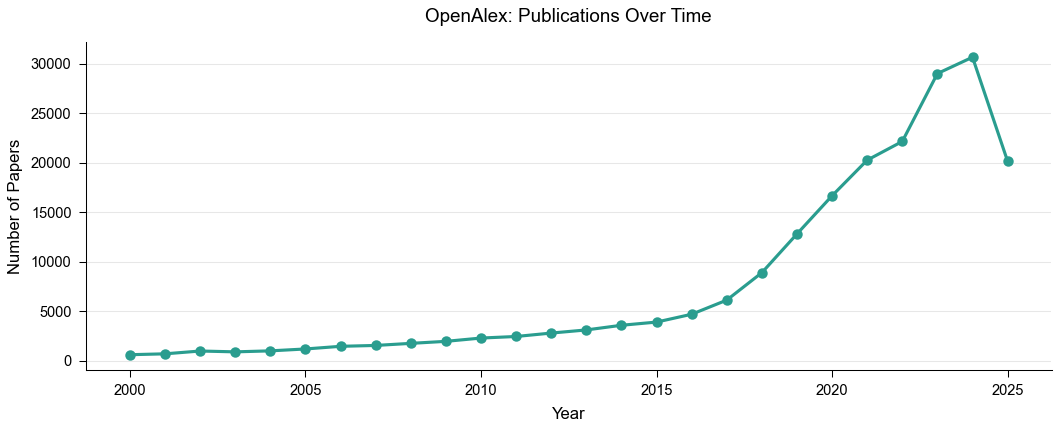


Citations by Year:
                  total_citations  avg_citations  median_citations
publication_year                                                  
2000                        19820           33.4               2.0
2001                        15788           23.1               2.0
2002                        21050           21.8               3.0
2003                        21365           24.2               3.0
2004                        31095           31.7               2.0
2005                        28911           24.6               2.0
2006                        35925           24.9               2.0
2007                        31010           20.3               2.0
2008                        40394           23.2               2.0
2009                        44854           23.1               2.0
2010                        53307           23.4               2.0
2011                        52373           21.5               2.0
2012                        59640         

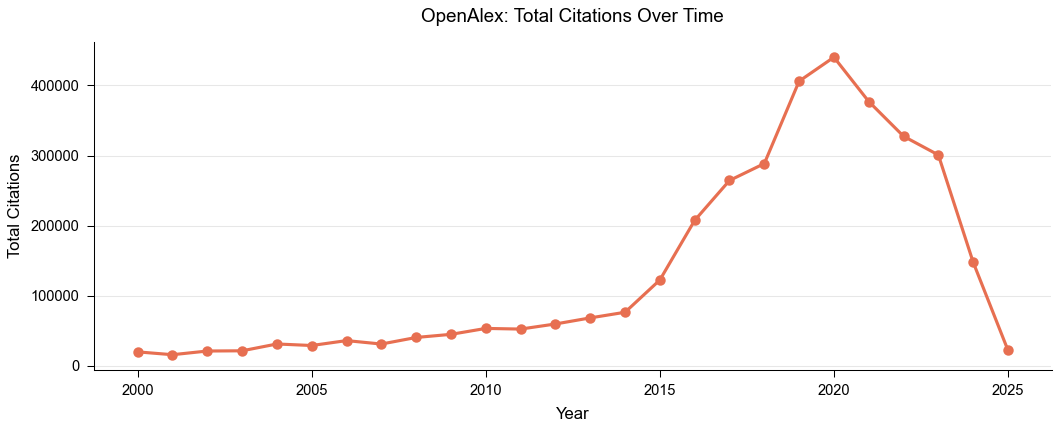

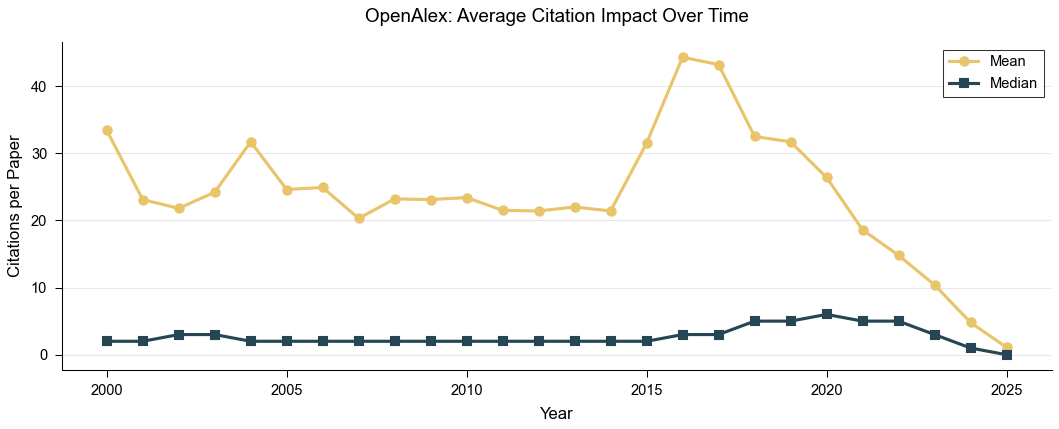


Collaboration Trends:
                  avg_authors  median_authors
publication_year                             
2000                      1.8             1.0
2001                      1.8             1.0
2002                      2.0             2.0
2003                      1.9             2.0
2004                      1.9             1.0
2005                      2.0             1.0
2006                      2.1             2.0
2007                      2.0             1.0
2008                      2.0             2.0
2009                      2.1             2.0
2010                      2.1             2.0
2011                      2.1             2.0
2012                      2.2             2.0
2013                      2.2             2.0
2014                      2.2             2.0
2015                      2.3             2.0
2016                      2.4             2.0
2017                      2.5             2.0
2018                      2.7             2.0
2019       

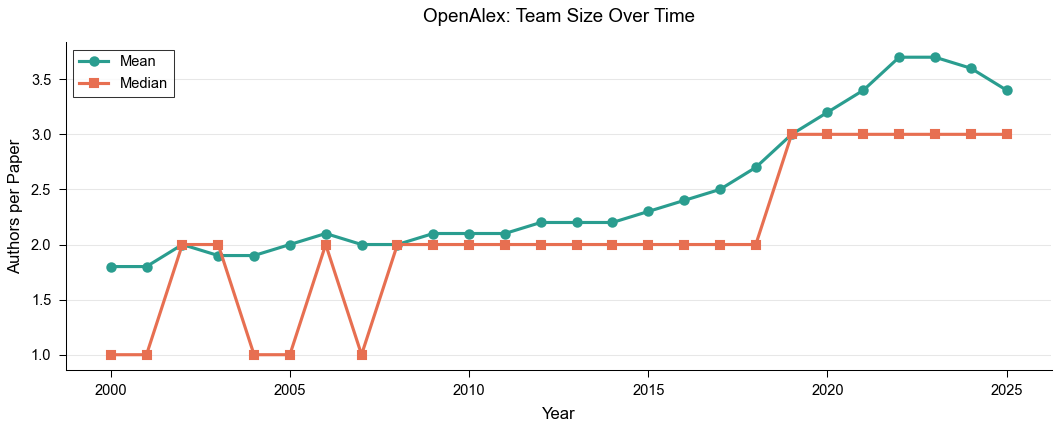

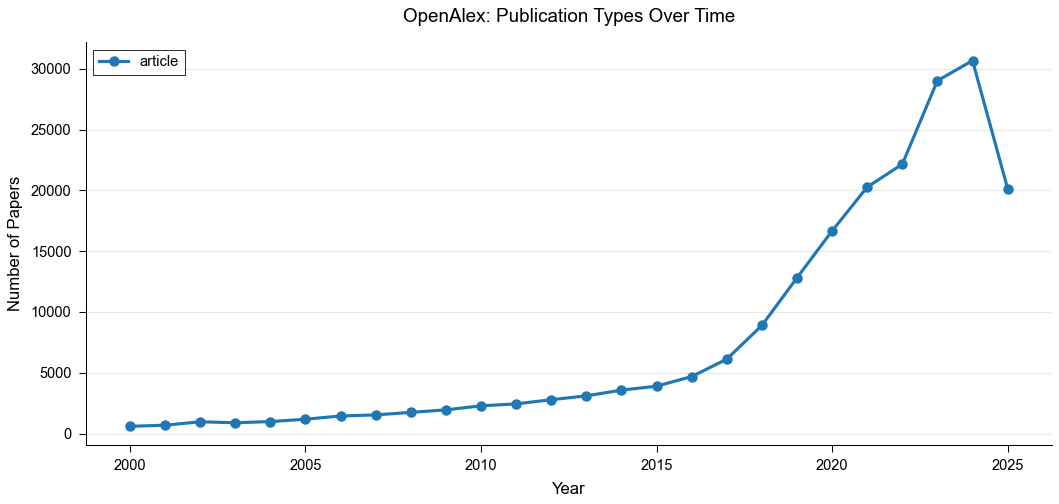


Year-over-Year Growth Rate:
  2001: +15.0%
  2002: +41.6%
  2003: -8.7%
  2004: +11.3%
  2005: +19.6%
  2006: +22.8%
  2007: +6.1%
  2008: +13.7%
  2009: +11.8%
  2010: +17.1%
  2011: +6.9%
  2012: +14.2%
  2013: +11.4%
  2014: +15.2%
  2015: +9.0%
  2016: +20.3%
  2017: +30.5%
  2018: +45.4%
  2019: +44.1%
  2020: +30.1%
  2021: +21.6%
  2022: +9.3%
  2023: +31.0%
  2024: +5.7%
  2025: -34.3%


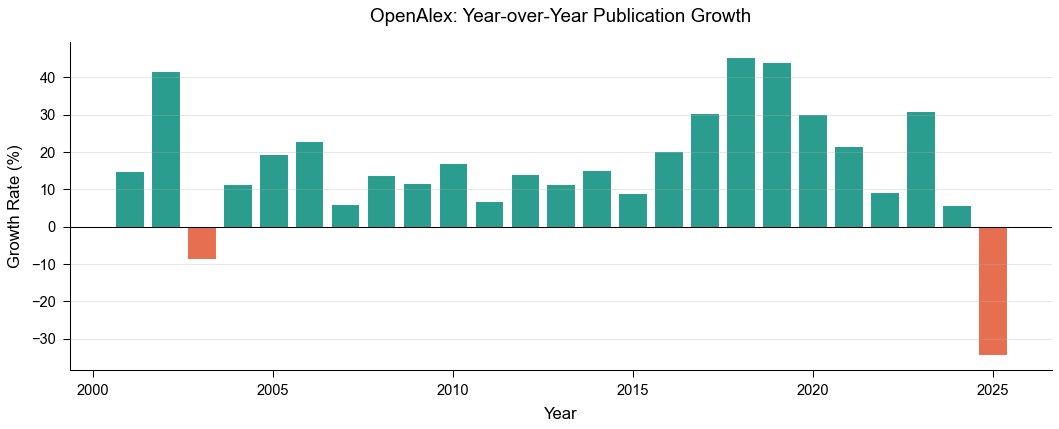

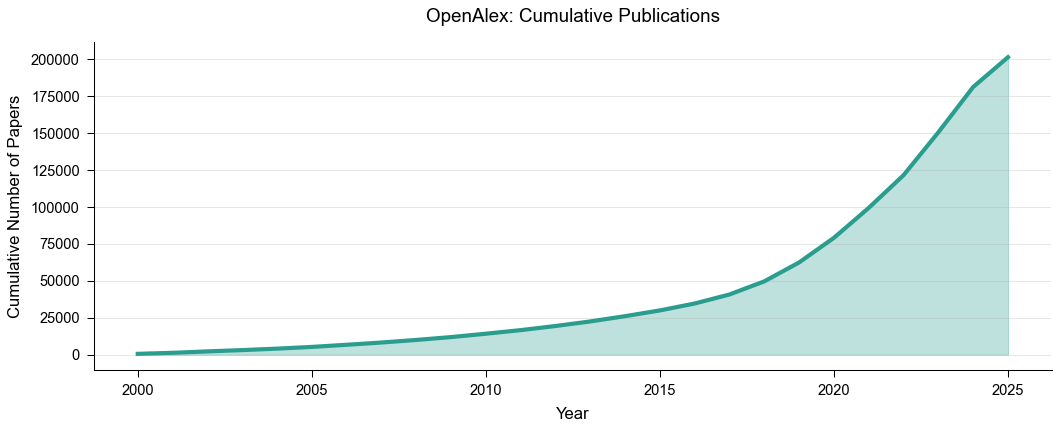

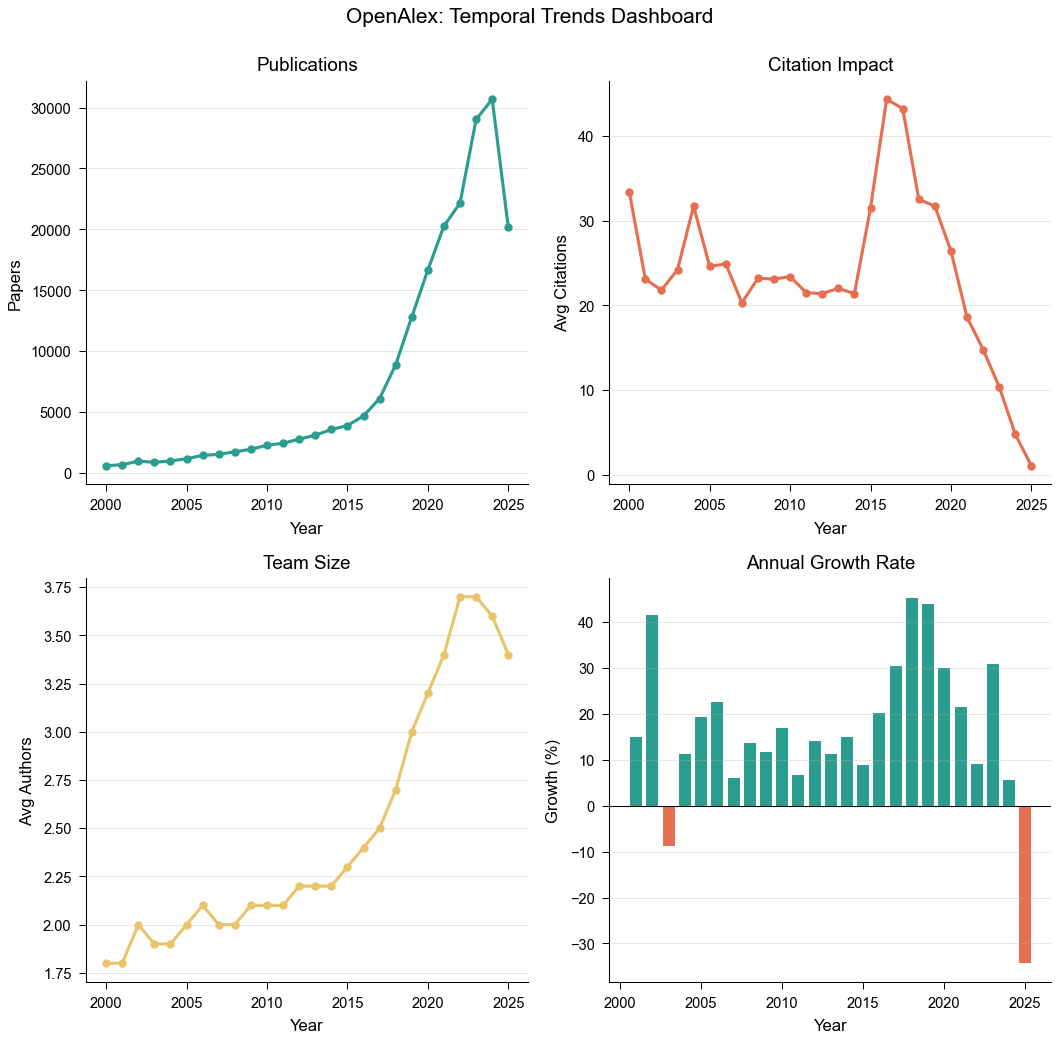


=== OpenAlex temporal analysis complete ===


In [56]:
"""=== OPENALEX TEMPORAL ANALYSIS ==="""

print("\n=== OPENALEX TEMPORAL ANALYSIS ===")

# 1. Papers by year
yearly_papers = openalex_df.groupby('publication_year').size()

print(f"\nPapers by Year:")
for year, count in yearly_papers.items():
    print(f"  {year}: {count:,} papers")

fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.plot(yearly_papers.index, yearly_papers.values,
        marker='o', linewidth=1.5, markersize=4, color='#2a9d8f')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Papers')
ax.set_title('OpenAlex: Publications Over Time', pad=10)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# 2. Citations over time
yearly_citations = openalex_df.groupby('publication_year').agg({
    'cited_by_count': ['sum', 'mean', 'median']
}).round(1)
yearly_citations.columns = ['total_citations', 'avg_citations', 'median_citations']

print(f"\nCitations by Year:")
print(yearly_citations.to_string())

# Total citations
fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.plot(yearly_citations.index, yearly_citations['total_citations'],
        marker='o', linewidth=1.5, markersize=4, color='#e76f51')
ax.set_xlabel('Year')
ax.set_ylabel('Total Citations')
ax.set_title('OpenAlex: Total Citations Over Time', pad=10)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# Average citations
fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.plot(yearly_citations.index, yearly_citations['avg_citations'],
        marker='o', linewidth=1.5, markersize=4, color='#e9c46a', label='Mean')
ax.plot(yearly_citations.index, yearly_citations['median_citations'],
        marker='s', linewidth=1.5, markersize=4, color='#264653', label='Median')
ax.set_xlabel('Year')
ax.set_ylabel('Citations per Paper')
ax.set_title('OpenAlex: Average Citation Impact Over Time', pad=10)
ax.legend(frameon=True, edgecolor='black', fancybox=False)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# 3. Collaboration trends (authors per paper)
yearly_collaboration = openalex_df.groupby('publication_year').agg({
    'num_authors': ['mean', 'median']
}).round(1)
yearly_collaboration.columns = ['avg_authors', 'median_authors']

print(f"\nCollaboration Trends:")
print(yearly_collaboration.to_string())

fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.plot(yearly_collaboration.index, yearly_collaboration['avg_authors'],
        marker='o', linewidth=1.5, markersize=4, color='#2a9d8f', label='Mean')
ax.plot(yearly_collaboration.index, yearly_collaboration['median_authors'],
        marker='s', linewidth=1.5, markersize=4, color='#e76f51', label='Median')
ax.set_xlabel('Year')
ax.set_ylabel('Authors per Paper')
ax.set_title('OpenAlex: Team Size Over Time', pad=10)
ax.legend(frameon=True, edgecolor='black', fancybox=False)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# 4. Monthly heatmap (if month data available)
if 'month' in openalex_df.columns:
    heatmap_data = openalex_df.groupby(['publication_year', 'month']).size().unstack(fill_value=0)
    
    # Ensure all months 1-12 are present
    for month in range(1, 13):
        if month not in heatmap_data.columns:
            heatmap_data[month] = 0
    heatmap_data = heatmap_data[sorted(heatmap_data.columns)]
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, len(heatmap_data) * 0.3 + 1))
    
    import seaborn as sns
    sns.heatmap(heatmap_data, annot=True, fmt='d',
                cmap='YlOrRd',
                ax=ax,
                cbar_kws={'label': 'Number of Papers'},
                linewidths=0.5,
                linecolor='white')
    
    ax.set_title('OpenAlex: Publications by Year and Month', pad=10)
    ax.set_xlabel('Month')
    ax.set_ylabel('Year')
    
    # Set month labels
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticklabels(month_labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Monthly aggregated pattern
    monthly_papers = openalex_df.groupby('month').size()
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 2.5))
    bars = ax.bar(monthly_papers.index, monthly_papers.values,
                  color='#e76f51', edgecolor='white', linewidth=0.5)
    ax.set_title('OpenAlex: Publications by Month (All Years)', pad=10)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Papers')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                      rotation=45, ha='right')
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    plt.close()

# 5. Paper type distribution over time (if type column exists)
if 'type' in openalex_df.columns and openalex_df['type'].notna().sum() > 0:
    type_temporal = openalex_df.groupby(['publication_year', 'type']).size().unstack(fill_value=0)
    
    # Get top 5 types
    top_types = openalex_df['type'].value_counts().head(5).index
    type_temporal_filtered = type_temporal[top_types]
    
    fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3.5))
    
    for pub_type in top_types:
        ax.plot(type_temporal_filtered.index, type_temporal_filtered[pub_type],
               marker='o', linewidth=1.5, markersize=4, label=pub_type)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Papers')
    ax.set_title('OpenAlex: Publication Types Over Time', pad=10)
    ax.legend(frameon=True, edgecolor='black', fancybox=False)
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    plt.close()

# 6. Growth rate analysis
yearly_papers_sorted = yearly_papers.sort_index()
growth_rate = yearly_papers_sorted.pct_change() * 100

print(f"\nYear-over-Year Growth Rate:")
for year, rate in growth_rate.items():
    if not pd.isna(rate):
        print(f"  {year}: {rate:+.1f}%")

fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.bar(growth_rate.index, growth_rate.values,
       color=['#2a9d8f' if x > 0 else '#e76f51' for x in growth_rate.values],
       edgecolor='white', linewidth=0.5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Growth Rate (%)')
ax.set_title('OpenAlex: Year-over-Year Publication Growth', pad=10)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# 7. Cumulative papers over time
cumulative_papers = yearly_papers_sorted.cumsum()

fig, ax = plt.subplots(figsize=(DOUBLE_COL, 3))
ax.fill_between(cumulative_papers.index, cumulative_papers.values,
                alpha=0.3, color='#2a9d8f')
ax.plot(cumulative_papers.index, cumulative_papers.values,
        linewidth=2, color='#2a9d8f')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Number of Papers')
ax.set_title('OpenAlex: Cumulative Publications', pad=10)
ax.grid(axis='y')

plt.tight_layout()
plt.show()
plt.close()

# 8. Combined metrics dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(DOUBLE_COL, 7))

# Papers over time
ax1.plot(yearly_papers.index, yearly_papers.values,
         marker='o', linewidth=1.5, markersize=3, color='#2a9d8f')
ax1.set_xlabel('Year')
ax1.set_ylabel('Papers')
ax1.set_title('Publications', pad=5)
ax1.grid(axis='y', alpha=0.3)

# Citations over time
ax2.plot(yearly_citations.index, yearly_citations['avg_citations'],
         marker='o', linewidth=1.5, markersize=3, color='#e76f51')
ax2.set_xlabel('Year')
ax2.set_ylabel('Avg Citations')
ax2.set_title('Citation Impact', pad=5)
ax2.grid(axis='y', alpha=0.3)

# Collaboration trends
ax3.plot(yearly_collaboration.index, yearly_collaboration['avg_authors'],
         marker='o', linewidth=1.5, markersize=3, color='#e9c46a')
ax3.set_xlabel('Year')
ax3.set_ylabel('Avg Authors')
ax3.set_title('Team Size', pad=5)
ax3.grid(axis='y', alpha=0.3)

# Growth rate
ax4.bar(growth_rate.index, growth_rate.values,
        color=['#2a9d8f' if x > 0 else '#e76f51' for x in growth_rate.values],
        edgecolor='white', linewidth=0.5)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.set_xlabel('Year')
ax4.set_ylabel('Growth (%)')
ax4.set_title('Annual Growth Rate', pad=5)
ax4.grid(axis='y', alpha=0.3)

fig.suptitle('OpenAlex: Temporal Trends Dashboard', fontsize=10, y=0.995)
plt.tight_layout()
plt.show()
plt.close()

print("\n=== OpenAlex temporal analysis complete ===")

In [57]:
import pandas as pd

# Load the data
posts_df = pd.read_csv("../data/nodes_forum_posts.csv")

print(f"Total posts in dataset: {len(posts_df):,}")

# Check breakdown by source
print("\nBy source:")
print(posts_df['source'].value_counts())

# Check crosspost flagging
print("\nCrosspost breakdown:")
print(f"Total crossposts (is_crosspost=True): {posts_df['is_crosspost'].sum():,}")
print(f"LW crossposts: {((posts_df['source'] == 'lesswrong') & posts_df['is_crosspost']).sum():,}")
print(f"AF crossposts: {((posts_df['source'] == 'alignment_forum') & posts_df['is_crosspost']).sum():,}")

# Check for the unique post count (excluding LW crossposts)
unique_posts = posts_df[
    ~((posts_df['source'] == 'lesswrong') & (posts_df['is_crosspost']))
]
print(f"\nUnique posts (excluding LW crossposts): {len(unique_posts):,}")

# Check for missing posts
print("\nPotential issues:")
print(f"Posts with null post_id: {posts_df['post_id'].isna().sum()}")
print(f"Posts with null source: {posts_df['source'].isna().sum()}")
print(f"Posts with null title: {posts_df['title'].isna().sum()}")

Total posts in dataset: 47,666

By source:
source
lesswrong          43451
alignment_forum     4215
Name: count, dtype: int64

Crosspost breakdown:
Total crossposts (is_crosspost=True): 8,492
LW crossposts: 4,278
AF crossposts: 4,214

Unique posts (excluding LW crossposts): 43,388

Potential issues:
Posts with null post_id: 0
Posts with null source: 0
Posts with null title: 0


In [58]:
# Check for posts with missing author information
print("Author field analysis:")
print(f"Posts with null author_username: {posts_df['author_username'].isna().sum()}")

# Check if the null post_id is the same row with null title
null_checks = posts_df[
    posts_df['post_id'].isna() | 
    posts_df['title'].isna() | 
    posts_df['author_username'].isna()
]
print(f"\nPosts with any null critical fields: {len(null_checks)}")
print(null_checks[['post_id', 'title', 'author_username', 'source', 'posted_at']])

# These should probably be filtered out in build_graph.py
print("\nThese posts should be removed from the final dataset")

Author field analysis:
Posts with null author_username: 0

Posts with any null critical fields: 0
Empty DataFrame
Columns: [post_id, title, author_username, source, posted_at]
Index: []

These posts should be removed from the final dataset


In [59]:
# Load paper data
works_df = pd.read_csv("../data/nodes_openalex_works.csv")
authorship_df = pd.read_csv("../data/edges_openalex_authorship.csv")

print(f"Total works: {len(works_df):,}")
print(f"Total authorship edges: {len(authorship_df):,}")

# Check first authors
first_authors = authorship_df[authorship_df['position_index'] == 0]
print(f"First author positions: {len(first_authors):,}")

# Find works without first authors
works_with_first = set(first_authors['openalex_id'].unique())
all_works = set(works_df['openalex_id'].unique())
missing_first_authors = all_works - works_with_first

print(f"\nWorks missing first authors: {len(missing_first_authors):,}")

# Check these works
if len(missing_first_authors) > 0:
    missing_works = works_df[works_df['openalex_id'].isin(missing_first_authors)]
    print(f"\nSample of works without first authors:")
    print(missing_works[['openalex_id', 'title', 'publication_year']].head(10))
    
    # Check if they have ANY authors
    works_with_any_authors = set(authorship_df['openalex_id'].unique())
    no_authors_at_all = missing_first_authors - works_with_any_authors
    print(f"\nWorks with NO authors at all: {len(no_authors_at_all)}")
    
    # Check if they have authors but wrong position_index
    has_authors_but_no_first = missing_first_authors - no_authors_at_all
    print(f"Works with authors but no position_index=0: {len(has_authors_but_no_first)}")
    
    if len(has_authors_but_no_first) > 0:
        sample_work = list(has_authors_but_no_first)[0]
        sample_authors = authorship_df[authorship_df['openalex_id'] == sample_work]
        print(f"\nExample work {sample_work} author positions:")
        print(sample_authors[['author_id', 'position_index', 'author_position']])

Total works: 200,060
Total authorship edges: 640,486
First author positions: 200,060

Works missing first authors: 0


---
# Edges
---

## What coverage of DOIs does OpenAlex data provide for LessWrong posts?

In [60]:
print("=" * 80)
print("STEP 1: Preparing forum posts data")
print("=" * 80)

# Extract AI Safety posts from LessWrong (topic 0)
lesswrong_ai_safety = lesswrong_df[lesswrong_df['topic_cluster_id'] == 0].copy()
print(f"LessWrong AI Safety posts (Topic 0): {len(lesswrong_ai_safety)}")

# Get all Alignment Forum posts
alignment_forum_all = alignment_forum_df.copy()
print(f"Alignment Forum posts (all): {len(alignment_forum_all)}")

# Combine them
posts_df = pd.concat([
    lesswrong_ai_safety.assign(source='LessWrong_Topic0'),
    alignment_forum_all.assign(source='AlignmentForum')
], ignore_index=True)

print(f"\nTotal combined AI Safety posts: {len(posts_df)}")
print()

# Load OpenAlex papers
print("Loading OpenAlex data...")
openalex_df = pd.read_csv('../data/nodes_openalex_works.csv')
print(f"✓ Loaded {len(openalex_df):,} OpenAlex papers")
print()

STEP 1: Preparing forum posts data


KeyError: 'topic_cluster_id'

In [ ]:
# ============================================================================
# STEP 2: EXTRACT DOIs FROM POST CONTENT
# ============================================================================

print("=" * 80)
print("STEP 2: Extracting DOIs from post content")
print("=" * 80)

def extract_dois_from_text(text):
    """
    Extract all DOIs from any text content.
    
    Handles multiple formats:
    - Plain DOI: 10.1234/example
    - URL format: https://doi.org/10.1234/example
    - dx.doi.org format: http://dx.doi.org/10.1234/example
    - DOI with prefix: doi:10.1234/example
    
    Returns a list of normalized DOIs (lowercase, no URL prefix).
    """
    if pd.isna(text):
        return []
    
    text = str(text)
    
    # DOI regex pattern
    # DOIs always start with "10." followed by 4+ digits, then "/", then any characters
    # We exclude whitespace and common delimiters that would end a DOI
    doi_pattern = r'10\.\d{4,}/[^\s,;|\]}\)"\'\><\n]+'
    
    # Find all DOIs in the text
    dois = re.findall(doi_pattern, text)
    
    # Clean and normalize DOIs
    cleaned_dois = []
    for doi in dois:
        # Remove common trailing punctuation that might be captured
        doi = doi.rstrip('.,;:!?')
        # Remove HTML tags if present (e.g., </a>)
        doi = re.sub(r'<[^>]+>$', '', doi)
        # Normalize to lowercase (DOIs are case-insensitive)
        doi = doi.lower()
        # Basic validation: DOI should still look like 10.xxxx/yyyy
        if re.match(r'^10\.\d{4,}/.+', doi):
            cleaned_dois.append(doi)
    
    # Remove duplicates while preserving order
    seen = set()
    unique_dois = []
    for doi in cleaned_dois:
        if doi not in seen:
            seen.add(doi)
            unique_dois.append(doi)
    
    return unique_dois

# Define columns to search for DOIs
# Based on the sample data, we have: htmlBody, cleaned_htmlBody, extracted_links
columns_to_search = []

# Check which columns exist
if 'htmlBody' in posts_df.columns:
    columns_to_search.append('htmlBody')
if 'cleaned_htmlBody' in posts_df.columns:
    columns_to_search.append('cleaned_htmlBody')
if 'extracted_links' in posts_df.columns:
    columns_to_search.append('extracted_links')

print(f"Columns to search for DOIs: {columns_to_search}")
print()

# Extract DOIs from each column
for col in columns_to_search:
    print(f"Searching column: {col}")
    posts_df[f'dois_from_{col}'] = posts_df[col].apply(extract_dois_from_text)
    dois_found = posts_df[f'dois_from_{col}'].apply(len).sum()
    posts_with_dois = (posts_df[f'dois_from_{col}'].apply(len) > 0).sum()
    print(f"  ✓ Found {dois_found:,} DOIs in {posts_with_dois:,} posts")

print()

# Combine all DOIs into a single list per post
def combine_doi_lists(*lists):
    """Combine multiple lists of DOIs, removing duplicates"""
    combined = []
    seen = set()
    for doi_list in lists:
        if isinstance(doi_list, list):
            for doi in doi_list:
                if doi not in seen:
                    seen.add(doi)
                    combined.append(doi)
    return combined

# Get all the DOI columns we created
doi_columns = [f'dois_from_{col}' for col in columns_to_search]

# Combine all extracted DOIs
posts_df['all_extracted_dois'] = posts_df[doi_columns].apply(
    lambda row: combine_doi_lists(*row), axis=1
)
posts_df['doi_count'] = posts_df['all_extracted_dois'].apply(len)

# Summary statistics
total_dois = posts_df['doi_count'].sum()
posts_with_dois = (posts_df['doi_count'] > 0).sum()

print(f"{'='*80}")
print(f"EXTRACTION SUMMARY:")
print(f"{'='*80}")
print(f"  Posts with at least 1 DOI: {posts_with_dois:,} ({posts_with_dois/len(posts_df)*100:.1f}%)")
print(f"  Total DOIs extracted: {total_dois:,}")

if posts_with_dois > 0:
    print(f"  Average DOIs per post (for posts with DOIs): {posts_df[posts_df['doi_count'] > 0]['doi_count'].mean():.2f}")
    print(f"  Max DOIs in a single post: {posts_df['doi_count'].max()}")
    print()
    
    # Show distribution
    print("Distribution of DOI counts per post:")
    dist = posts_df['doi_count'].value_counts().sort_index().head(10)
    for count, freq in dist.items():
        print(f"  {count} DOIs: {freq:,} posts")
    print()
    
    # Show some examples
    print("Sample posts with DOIs:")
    print("-" * 80)
    for i, (idx, row) in enumerate(posts_df[posts_df['doi_count'] > 0].head(5).iterrows(), 1):
        title = row.get('title', 'N/A')
        title = title[:70] + "..." if len(title) > 70 else title
        print(f"\n{i}. {title}")
        print(f"   Source: {row['source']}")
        print(f"   DOIs found: {len(row['all_extracted_dois'])}")
        for doi in row['all_extracted_dois'][:3]:  # Show first 3 DOIs
            print(f"     - {doi}")
        if len(row['all_extracted_dois']) > 3:
            print(f"     ... and {len(row['all_extracted_dois']) - 3} more")
else:
    print()
    print("⚠️  No DOIs found in any posts!")
    print("This might mean:")
    print("  - Posts don't contain DOI links")
    print("  - DOIs are in a different format than expected")
    print("  - Need to check other columns")

print()

In [ ]:
# ============================================================================
# STEP 3: PREPARE OpenAlex DOI LOOKUP
# ============================================================================

print("=" * 80)
print("STEP 3: Preparing OpenAlex DOI lookup")
print("=" * 80)

def clean_openalex_doi(doi_str):
    """Clean OpenAlex DOI for matching"""
    if pd.isna(doi_str):
        return None
    doi_str = str(doi_str).lower().strip()
    # Remove URL prefixes if present
    doi_str = doi_str.replace('https://doi.org/', '')
    doi_str = doi_str.replace('http://dx.doi.org/', '')
    doi_str = doi_str.replace('doi:', '')
    return doi_str if doi_str else None

openalex_df['doi_cleaned'] = openalex_df['openalex_doi'].apply(clean_openalex_doi)

# Remove rows without DOIs
openalex_with_doi = openalex_df[openalex_df['doi_cleaned'].notna()].copy()
print(f"OpenAlex papers with DOIs: {len(openalex_with_doi):,} ({len(openalex_with_doi)/len(openalex_df)*100:.1f}%)")

# Create a set for fast O(1) lookup
openalex_doi_set = set(openalex_with_doi['doi_cleaned'].values)
print(f"Unique DOIs in OpenAlex: {len(openalex_doi_set):,}")
print()

In [ ]:
def clean_doi(doi):
    """
    Comprehensive DOI cleaning for matching.
    Handles all the weird edge cases we've found.
    """
    if not doi or pd.isna(doi):
        return None
    
    doi = str(doi).strip()
    
    # === STEP 1: Remove URL prefixes (do this first) ===
    doi = doi.replace('https://doi.org/', '')
    doi = doi.replace('http://doi.org/', '')
    doi = doi.replace('https://dx.doi.org/', '')
    doi = doi.replace('http://dx.doi.org/', '')
    doi = doi.replace('doi:', '')

    # === STEP 2: Remove fragments and query parameters (before other cleaning) ===
    if '#' in doi:
        doi = doi.split('#')[0]
    if '?' in doi:
        doi = doi.split('?')[0]
    
    # === STEP 3: Remove HTML entities and special characters ===
    doi = doi.replace('&amp;', '').replace('&amp', '')
    # Normalize en-dashes and em-dashes to regular hyphens (but not at the end)
    doi = doi.replace('–', '-').replace('—', '-')
    doi = re.sub(r'%[0-9a-f]{2}', '', doi, flags=re.IGNORECASE)  # URL-encoded chars
    # Remove incomplete parenthetical patterns that remain after decoding
    doi = re.sub(r'\(\d{2}\)$', '', doi)
    doi = re.sub(r'[†‌—]', '', doi)  # Special Unicode
    doi = re.sub(r'&type=.*$', '', doi)
    doi = re.sub(r'&.*$', '', doi)
    # Remove sequences of dashes (en-dash, em-dash, regular dash)
    doi = re.sub(r'\.?[-—–]{2,}$', '', doi)
    # Remove trailing spaces (encoded or not)
    doi = doi.strip()
    # Remove zero-width and other invisible Unicode characters
    doi = re.sub(r'[\u200b-\u200f\u202a-\u202e\u2060\ufeff]', '', doi)
    
    # === STEP 4: Remove file extensions and path suffixes ===
    doi = re.sub(r'\.pdf.*$', '', doi)  # .pdf with any trailing stuff
    doi = re.sub(r'\.(full\.pdf|pdf\.full).*$', '', doi)  # Compound suffixes
    doi = re.sub(r'/abstract$', '', doi)
    doi = re.sub(r'/pdf$', '', doi)
    doi = re.sub(r'/epdf$', '', doi)
    doi = re.sub(r'/full$', '', doi)
    doi = re.sub(r'/issuetoc$', '', doi)
    doi = re.sub(r'/full/html$', '', doi)
    doi = re.sub(r'/meta$', '', doi)
    doi = re.sub(r'/tables/\d+$', '', doi)
    doi = re.sub(r'/suppl_file/.*$', '', doi)
    doi = re.sub(r'/full\.pdf$', '', doi)
    
    # === STEP 5: Remove version indicators ===
    doi = re.sub(r'v\d+\.full.*$', '', doi)  # v1.full.pdf etc
    doi = re.sub(r'v\d+\.full$', '', doi)    # v1.full
    doi = re.sub(r'v\d+$', '', doi)          # v1
    
    # === STEP 6: Remove bracket and parenthesis artifacts ===
    doi = re.sub(r'\[[^\]]*$', '', doi)  # Incomplete brackets
    doi = re.sub(r'\([^)]*$', '', doi)   # Incomplete parentheses
    if doi.endswith('('):
        doi = doi[:-1]
    
    # === STEP 7: Remove duplicate acprof segments ===
    # Remove duplicate segments in Oxford reference DOIs (acrefore, acref)
    if '/acrefore/' in doi or '/acref/' in doi:
        # Pattern: /acrefore/ID/acrefore-ID-... -> keep only /acrefore/ID
        # Match everything up to and including the book ID, before the duplicate
        match = re.match(r'(10\.1093/acr(?:efore|ef)/\d+(?:\.\d+)*)', doi)
        if match:
            doi = match.group(1)
    
    # === STEP 8: Remove caret suffixes ===
    doi = re.sub(r'\.\^.*$', '', doi)
    doi = re.sub(r'\^.*$', '', doi)
    
    # === STEP 9: Remove trailing text patterns ===
    # Multiple hyphenated words (titles/author names)
    doi = re.sub(r'/[a-z]+-[a-z]+-[a-z]+-.*$', '', doi, flags=re.IGNORECASE)
    # Single hyphenated fragment
    doi = re.sub(r'/[a-z]+-[a-z]+-?$', '', doi, flags=re.IGNORECASE)
    # Word suffixes (gödel, kraft, etc.)
    doi = re.sub(r'\.?[a-zàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿłćśźżğ]{4,}$', '', doi, flags=re.IGNORECASE)
    # Remove text concatenated after digit endings (no separator)
    doi = re.sub(r'(\d)[a-z]{4,}(-[a-z]+)*$', r'\1', doi, flags=re.IGNORECASE)
    # Remove trailing lone hyphens
    doi = doi.rstrip('-')
    # Remove footnote markers
    doi = re.sub(r'\.footnotes\*\d+$', '', doi)
    # Remove possessive markers and contractions at the end
    doi = re.sub(r"(what's|that's|it's|what’s|that’s|it’s|[a-z]+'s?)$", '', doi, flags=re.IGNORECASE)
    # Remove .cross- and similar suffix patterns
    doi = re.sub(r'\.cross-$', '', doi)
    # Remove 2-3 letter word fragments at the end (but not legitimate suffixes like .x or .e1234)
    doi = re.sub(r'\.([a-z]{2,3})$', lambda m: '' if not any(c.isdigit() for c in m.group(1)) else m.group(0), doi, flags=re.IGNORECASE)
    # Remove article title paths (pattern: /numbers/long-title-text)
    doi = re.sub(r'/\d+/[a-z][a-z-]+-[a-z-]+$', '', doi, flags=re.IGNORECASE)
    # Remove 2-3 letter author initials concatenated after numbers
    doi = re.sub(r'(\d)([a-z]{2,3})$', r'\1', doi, flags=re.IGNORECASE)
    
    # === STEP 10: Clean last segment after final slash ===
    parts = doi.split('/')
    if len(parts) >= 2:
        last_part = parts[-1]
        last_part = re.sub(r'[a-z]{3,}$', '', last_part, flags=re.IGNORECASE)
        parts[-1] = last_part
        doi = '/'.join(parts)
    
    # === STEP 11: Remove trailing special characters ===
    doi = re.sub(r'[\.&]+$', '', doi)  # Ampersands and periods
    # Remove trailing underscores (multiple)
    doi = re.sub(r'_+$', '', doi)
    # Remove /full one more time before final cleanup
    doi = re.sub(r'/full$', '', doi)
    doi = doi.rstrip("/.,;:!?_+'\"‘")  # Add quotes to the list
    
    # === STEP 12: Final version check (after all other cleaning) ===
    doi = re.sub(r'v\d+$', '', doi)

    # Final /full removal (catch any stragglers)
    doi = re.sub(r'/full$', '', doi)

    # Final cleanup of version patterns
    doi = re.sub(r'v\d+\.full$', '', doi)
    
    # === STEP 13: Lowercase ===
    doi = doi.lower()
    
    # === STEP 14: Validate completeness ===
    # Filter out DOIs that end with a lone hyphen (likely incomplete)
    if doi.endswith('-'):
        return None
    
    if '/' in doi:
        parts = doi.split('/')
        if len(parts[-1]) < 2:
            return None
        
    # Filter out DOIs that are just the prefix (no suffix after slash)
    if '/' not in doi or doi.split('/')[-1] == '':
        return None
    
    # Filter out DOIs where the last part looks incomplete (2 chars or ends with hyphen)
    if '/' in doi:
        last_part = doi.split('/')[-1]
        if len(last_part) <= 2 or last_part.endswith('-'):
            return None
    
    return doi.strip() if doi else None

In [ ]:
test_dois = [
    "10.1111/j.1755-2567.1996.tb00529.x",  # Should KEEP .x
    "10.1111/j.1755-2567.1996.tb00529.x/abstract",  # Should become .x (remove /abstract)
    "10.1234/test.v1",  # Should KEEP .v1 (version)
    "10.5678/paper.a1",  # Should KEEP .a1 (supplement)
    "10.3389/fnins.2018.00774^c",  # Should remove ^c
    "10.1002/aisy.202000096.^nvidia",  # Should remove .^nvidia
    "10.1093/acref/9780191843266.001.0001/acref-9780191843266-e-139:~:texta20theoretical20construct20developed20",
    "10.1093/acrefore/9780199329175.001.0001/acrefore-9780199329175-e-26",
    "10.1093/acrefore/9780199389407.001.0001/acrefore-9780199389407-e-293",
]

for original in test_dois:
    cleaned = clean_doi(original)
    print(f"Original:  {original:50s}")
    print(f"Cleaned:   {cleaned}")
    print()

In [ ]:
posts_df['all_extracted_dois'] = posts_df['all_extracted_dois'].apply(
    lambda doi_list: [clean_doi(doi) for doi in doi_list if clean_doi(doi)]
)

# Remove any None/empty values
posts_df['all_extracted_dois'] = posts_df['all_extracted_dois'].apply(
    lambda doi_list: [doi for doi in doi_list if doi]
)

In [ ]:
openalex_df['doi_cleaned'] = openalex_df['openalex_doi'].apply(clean_doi)

In [ ]:
# ============================================================================
# STEP 4: MATCH DOIs
# ============================================================================

print("=" * 80)
print("STEP 4: Matching forum DOIs with OpenAlex DOIs")
print("=" * 80)

def match_dois(doi_list, openalex_set):
    """Match a list of DOIs against the OpenAlex set"""
    if not doi_list:
        return []
    return [doi for doi in doi_list if doi in openalex_set]

# Find matches for each post
posts_df['matched_dois'] = posts_df['all_extracted_dois'].apply(
    lambda dois: match_dois(dois, openalex_doi_set)
)
posts_df['matched_doi_count'] = posts_df['matched_dois'].apply(len)

# Calculate statistics
total_dois_extracted = posts_df['doi_count'].sum()
total_dois_matched = posts_df['matched_doi_count'].sum()
posts_with_matches = (posts_df['matched_doi_count'] > 0).sum()

print(f"✓ Matching complete!")
print(f"  Total DOIs extracted: {total_dois_extracted:,}")
print(f"  Total DOIs matched in OpenAlex: {total_dois_matched:,}")

if total_dois_extracted > 0:
    match_rate = total_dois_matched / total_dois_extracted * 100
    print(f"  Match rate: {match_rate:.1f}%")
    print()
    print(f"  Posts with at least 1 match: {posts_with_matches:,}")
    print(f"  Posts with DOIs but no match: {posts_with_dois - posts_with_matches:,}")
    
    """
    # Show some unmatched DOIs for debugging
    if total_dois_matched < total_dois_extracted:
        print()
        print("Sample unmatched DOIs (for debugging):")
        unmatched = []
        for dois, matched in zip(posts_df['all_extracted_dois'], posts_df['matched_dois']):
            for doi in dois:
                if doi not in matched:
                    unmatched.append(doi)
                    if len(unmatched) >= 100:
                        break
            if len(unmatched) >= 100:
                break
        for doi in unmatched[:200]:
            print(f"  - {doi}")
else:
    print("  ⚠️  No DOIs found to match")
    """

print()

In [ ]:
print("=" * 80)
print("STEP 5: Collecting unmatched DOIs")
print("=" * 80)

# Get all DOIs that were extracted but not matched
# IMPORTANT: Use the CLEANED dois from all_extracted_dois (after cell 378)
unmatched_dois = []

for dois_extracted, dois_matched in zip(posts_df['all_extracted_dois'], posts_df['matched_dois']):
    for doi in dois_extracted:
        if doi not in dois_matched:
            unmatched_dois.append(doi)

# Remove duplicates while preserving order
unique_unmatched = list(dict.fromkeys(unmatched_dois))

print(f"Total unmatched DOI occurrences: {len(unmatched_dois):,}")
print(f"Unique unmatched DOIs: {len(unique_unmatched):,}")
print()

# Show sample of what we're about to look up
print("Sample DOIs to look up:")
for doi in unique_unmatched[:10]:
    print(f"  - {doi}")
print()

In [ ]:
# ============================================================================
# STEP 6: LOOKUP DOIS IN OPENALEX
# ============================================================================

print("=" * 80)
print("STEP 6: Looking up DOIs in OpenAlex API (with topics & concepts)")
print("=" * 80)

def lookup_doi_with_metadata(doi, email=None):
    """
    Look up a DOI in OpenAlex and extract full metadata including:
    - Basic info (title, year, type, citations)
    - Topics (primary_topic, topics list)
    - Concepts (with scores)
    - Keywords (from various sources)
    
    Returns:
        Tuple of (paper_info_dict, topics_list, concepts_list, keywords_list) if found
        (None, None, None, None) if not found
    """
    # OpenAlex API endpoint
    base_url = "https://api.openalex.org/works"
    
    # Construct the DOI URL for OpenAlex
    doi_url = f"https://doi.org/{doi}"
    
    # Make request
    params = {'filter': f'doi:{doi_url}'}
    if email:
        params['mailto'] = email
    
    try:
        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        
        data = response.json()
        
        # Check if we found results
        if data.get('results') and len(data['results']) > 0:
            work = data['results'][0]
            
            # === BASIC INFO ===
            openalex_id = work.get('id', '').replace('https://openalex.org/', '')
            
            # Extract primary location info
            primary_location = None
            if work.get('primary_location'):
                source = work['primary_location'].get('source')
                if source:
                    primary_location = source.get('display_name')
            
            # Extract open access info
            is_oa = False
            if work.get('open_access'):
                is_oa = work['open_access'].get('is_oa', False)
            
            paper_info = {
                'doi': doi,
                'openalex_id': openalex_id,
                'title': work.get('title'),
                'publication_year': work.get('publication_year'),
                'type': work.get('type'),
                'cited_by_count': work.get('cited_by_count', 0),
                'primary_location': primary_location,
                'open_access': is_oa,
            }
            
            # === TOPICS (NEW in OpenAlex - replaces concepts) ===
            topics_list = []
            
            # Primary topic
            if work.get('primary_topic'):
                pt = work['primary_topic']
                topics_list.append({
                    'openalex_id': openalex_id,
                    'doi': doi,
                    'topic_id': pt.get('id', '').replace('https://openalex.org/', ''),
                    'topic_name': pt.get('display_name'),
                    'topic_score': 1.0,  # Primary topic gets max score
                    'is_primary': True,
                    'subfield': pt.get('subfield', {}).get('display_name') if pt.get('subfield') else None,
                    'field': pt.get('field', {}).get('display_name') if pt.get('field') else None,
                    'domain': pt.get('domain', {}).get('display_name') if pt.get('domain') else None,
                })
            
            # All topics with scores
            if work.get('topics'):
                for topic in work['topics']:
                    topics_list.append({
                        'openalex_id': openalex_id,
                        'doi': doi,
                        'topic_id': topic.get('id', '').replace('https://openalex.org/', ''),
                        'topic_name': topic.get('display_name'),
                        'topic_score': topic.get('score', 0),
                        'is_primary': False,
                        'subfield': topic.get('subfield', {}).get('display_name') if topic.get('subfield') else None,
                        'field': topic.get('field', {}).get('display_name') if topic.get('field') else None,
                        'domain': topic.get('domain', {}).get('display_name') if topic.get('domain') else None,
                    })
            
            # === CONCEPTS (DEPRECATED but still available) ===
            concepts_list = []
            if work.get('concepts'):
                for concept in work['concepts']:
                    concepts_list.append({
                        'openalex_id': openalex_id,
                        'doi': doi,
                        'concept_id': concept.get('id', '').replace('https://openalex.org/', ''),
                        'concept_name': concept.get('display_name'),
                        'concept_score': concept.get('score', 0),
                        'concept_level': concept.get('level', 0),
                    })
            
            # === KEYWORDS ===
            keywords_list = []
            if work.get('keywords'):
                for kw in work['keywords']:
                    keywords_list.append({
                        'openalex_id': openalex_id,
                        'doi': doi,
                        'keyword': kw.get('display_name'),
                        'keyword_score': kw.get('score', 0),
                    })
            
            return paper_info, topics_list, concepts_list, keywords_list
        else:
            return None, None, None, None
            
    except requests.exceptions.RequestException as e:
        print(f"  ⚠️  Error looking up {doi}: {e}")
        return None, None, None, None

# Lookup all unmatched DOIs
print("Looking up DOIs in OpenAlex API...")
print("(This may take several minutes for thousands of DOIs)")
print()

# You can add your email here for faster rate limits (polite pool)
YOUR_EMAIL = None  # Set to your email like: "your.email@example.com"

found_papers = []
all_topics = []
all_concepts = []
all_keywords = []
not_found_dois = []
batch_size = 50

for i, doi in enumerate(unique_unmatched):
    # Progress indicator
    if (i + 1) % batch_size == 0:
        print(f"  Progress: {i + 1}/{len(unique_unmatched)} ({(i+1)/len(unique_unmatched)*100:.1f}%)")
    
    paper_info, topics, concepts, keywords = lookup_doi_with_metadata(doi, email=YOUR_EMAIL)
    
    if paper_info:
        found_papers.append(paper_info)
        all_topics.extend(topics)
        all_concepts.extend(concepts)
        all_keywords.extend(keywords)
    else:
        not_found_dois.append(doi)
    
    # Rate limiting: Be polite to OpenAlex API
    # With email (polite pool): 10 req/sec = 0.1s wait
    # Without email: 6 req/sec = 0.17s wait
    time.sleep(0.11 if YOUR_EMAIL else 0.17)

print(f"\n✓ Lookup complete!")
print()

In [ ]:
# ============================================================================
# STEP 7: RESULTS SUMMARY
# ============================================================================

print("=" * 80)
print("STEP 7: Results Summary")
print("=" * 80)

found_count = len(found_papers)
not_found_count = len(not_found_dois)
total = len(unique_unmatched)

print(f"Total DOIs looked up: {total:,}")
print(f"  Found in OpenAlex: {found_count:,} ({found_count/total*100:.1f}%)")
print(f"  Not found: {not_found_count:,} ({not_found_count/total*100:.1f}%)")
print()

if found_count > 0:
    # Create dataframes
    new_papers_df = pd.DataFrame(found_papers)
    topics_df = pd.DataFrame(all_topics) if all_topics else pd.DataFrame()
    concepts_df = pd.DataFrame(all_concepts) if all_concepts else pd.DataFrame()
    keywords_df = pd.DataFrame(all_keywords) if all_keywords else pd.DataFrame()
    
    print("📚 Newly discovered papers:")
    print("-" * 80)
    print(f"  Total papers: {len(new_papers_df):,}")
    print(f"  Total topics: {len(topics_df['topic_name'].unique()):,}")
    print(f"  Total concepts: {len(concepts_df['concept_name'].unique()):,}")
    print(f"  Total keywords: {len(keywords_df['keyword'].unique()):,}")
    print()
    
    # Paper statistics
    print(f"  Papers by type:")
    if 'type' in new_papers_df.columns:
        type_counts = new_papers_df['type'].value_counts()
        for paper_type, count in type_counts.head(10).items():
            print(f"    {paper_type}: {count}")
    print()
    
    print(f"  Publication years:")
    if 'publication_year' in new_papers_df.columns:
        year_stats = new_papers_df['publication_year'].describe()
        print(f"    Range: {int(year_stats['min'])}-{int(year_stats['max'])}")
        print(f"    Median: {int(year_stats['50%'])}")
    print()
    
    print(f"  Citation stats:")
    if 'cited_by_count' in new_papers_df.columns:
        citation_stats = new_papers_df['cited_by_count'].describe()
        print(f"    Total citations: {int(new_papers_df['cited_by_count'].sum()):,}")
        print(f"    Mean: {citation_stats['mean']:.1f}")
        print(f"    Median: {int(citation_stats['50%'])}")
        print(f"    Max: {int(citation_stats['max'])}")
    print()
    
    # Topic statistics
    if not topics_df.empty:
        print("🏷️  TOPIC ANALYSIS:")
        print("-" * 80)
        
        # Most common topics
        topic_counts = topics_df.groupby('topic_name').size().sort_values(ascending=False)
        print(f"  Top 15 topics (by paper count):")
        for topic, count in topic_counts.head(25).items():
            print(f"    {count:4d} papers | {topic}")
        print()
        
        # Most common domains/fields
        if 'domain' in topics_df.columns:
            domain_counts = topics_df[topics_df['domain'].notna()]['domain'].value_counts()
            print(f"  Domains:")
            for domain, count in domain_counts.head(10).items():
                print(f"    {count:4d} | {domain}")
        print()
    
    # Concept statistics
    if not concepts_df.empty:
        print("💡 CONCEPT ANALYSIS:")
        print("-" * 80)
        
        # Most common concepts
        concept_counts = concepts_df.groupby('concept_name').size().sort_values(ascending=False)
        print(f"  Top 15 concepts (by paper count):")
        for concept, count in concept_counts.head(15).items():
            print(f"    {count:4d} papers | {concept}")
        print()
        
        # Average concept scores
        avg_scores = concepts_df.groupby('concept_name')['concept_score'].mean().sort_values(ascending=False)
        print(f"  Highest average concept scores:")
        for concept, score in avg_scores.head(10).items():
            print(f"    {score:.3f} | {concept}")
        print()
    
    # Keyword statistics
    if not keywords_df.empty:
        print("🔑 KEYWORD ANALYSIS:")
        print("-" * 80)
        
        # Most common keywords
        keyword_counts = keywords_df.groupby('keyword').size().sort_values(ascending=False)
        print(f"  Top 20 keywords (by paper count):")
        for keyword, count in keyword_counts.head(20).items():
            print(f"    {count:4d} papers | {keyword}")
        print()
    
    # Top cited papers
    print("  Top 10 most cited newly found papers:")
    print("  " + "-" * 78)
    top_cited = new_papers_df.nlargest(10, 'cited_by_count')
    for idx, row in top_cited.iterrows():
        title = str(row['title'])[:65] + "..." if len(str(row['title'])) > 65 else row['title']
        print(f"    {row['cited_by_count']:5,} | {row['publication_year']} | {title}")
    print()

if not_found_count > 0:
    print("❌ Sample DOIs not found in OpenAlex:")
    print("-" * 80)
    for doi in not_found_dois[:20]:
        print(f"  - {doi}")
    if not_found_count > 20:
        print(f"  ... and {not_found_count - 20} more")
    print()

In [ ]:
# ============================================================================
# STEP 8: SAVE RESULTS
# ============================================================================

print("=" * 80)
print("STEP 8: Saving results")
print("=" * 80)

if found_count > 0:
    # Save newly found papers
    new_papers_df.to_csv('openalex_papers_from_api.csv', index=False)
    print(f"✓ Saved {found_count:,} papers to: openalex_papers_from_api.csv")
    
    # Save topics
    if not topics_df.empty:
        topics_df.to_csv('openalex_topics_from_api.csv', index=False)
        print(f"✓ Saved {len(topics_df):,} topic associations to: openalex_topics_from_api.csv")
    
    # Save concepts
    if not concepts_df.empty:
        concepts_df.to_csv('openalex_concepts_from_api.csv', index=False)
        print(f"✓ Saved {len(concepts_df):,} concept associations to: openalex_concepts_from_api.csv")
    
    # Save keywords
    if not keywords_df.empty:
        keywords_df.to_csv('openalex_keywords_from_api.csv', index=False)
        print(f"✓ Saved {len(keywords_df):,} keyword associations to: openalex_keywords_from_api.csv")
    
    # Save expanded OpenAlex dataset
    expanded_openalex = pd.concat([
        openalex_df[['openalex_id', 'openalex_doi', 'title', 'publication_year', 'type', 'cited_by_count']],
        new_papers_df[['openalex_id', 'doi', 'title', 'publication_year', 'type', 'cited_by_count']].rename(columns={'doi': 'openalex_doi'})
    ], ignore_index=True)
    
    expanded_openalex.to_csv('nodes_openalex_works_expanded.csv', index=False)
    print(f"✓ Saved expanded dataset ({len(expanded_openalex):,} papers) to: nodes_openalex_works_expanded.csv")

if not_found_count > 0:
    # Save DOIs that weren't found
    not_found_df = pd.DataFrame({'doi': not_found_dois})
    not_found_df.to_csv('dois_not_in_openalex.csv', index=False)
    print(f"✓ Saved {not_found_count:,} DOIs not found to: dois_not_in_openalex.csv")

print()
print("=" * 80)
print("✅ LOOKUP COMPLETE!")
print("=" * 80)
print()
print("📦 New dataframes available:")
if found_count > 0:
    print("  - new_papers_df: Papers found via OpenAlex API")
    print("  - topics_df: Topic classifications for each paper")
    print("  - concepts_df: Concepts (deprecated) for each paper")
    print("  - keywords_df: Keywords for each paper")
    print("  - expanded_openalex: Your original + newly found papers")
print()
print("📊 Analysis possibilities:")
print("  - Analyze which topics are most cited by AI Safety community")
print("  - See if certain domains/fields are over-represented")
print("  - Track concept evolution over time")
print("  - Identify key research areas through keyword clusters")
print()

## Unknown Genders

In [ ]:
unknown_gender = combined_df[combined_df["user_gender"] == '-']
unknown_gender_counts = unknown_gender['user.username'].value_counts()
# if (unknown_gender_counts < 5).any():
unknwons = set(unknown_gender_counts.index)
unknowns_lower = {name.lower() for name in unknwons}

In [ ]:
for user in unknowns_lower:
    print(user)

In [ ]:
import json
with open("../src/metadata/graphql_usernames.json", "r", encoding="utf-8") as f:
        names_data = json.load(f)

MALE_USERNAMES = names_data["MALE_USERNAMES"]
FEMALE_USERNAMES = names_data["FEMALE_USERNAMES"]

In [ ]:
unknowns_without_male = unknowns_lower.difference(names.MALE_NAMES)
unknowns_without_female = unknowns_lower.difference(names.FEMALE_NAMES)
print(f'Unkown names that are neither in FEMALE_NAMES nor MALE_NAMES: {len(unknowns_without_male.intersection(unknowns_without_female))}')
print(unknowns_without_male.intersection(unknowns_without_female))

In [ ]:
male_names_without_unknowns = names.MALE_NAMES.difference(unknowns_lower)
print(sorted(male_names_without_unknowns))
print(sorted(names.MALE_NAMES - male_names_without_unknowns))
print(sorted(names.MALE_NAMES - names.MALE_USERNAMES))

In [ ]:
import importlib
import src.names as names
importlib.reload(names) 

In [ ]:
female_names_without_unknowns = names.FEMALE_NAMES.difference(unknowns_lower)
print(female_names_without_unknowns)
print(names.FEMALE_NAMES - female_names_without_unknowns)
print(names.FEMALE_NAMES - names.FEMALE_USERNAMES)

In [ ]:

import src.names as names
 # Force reload
print(type(names.MALE_NAMES))  # Should be <class 'set'>
print(len(names.MALE_NAMES))   # Check the size
print('yashvardhan' in names.MALE_NAMES)

In [ ]:
print(sorted(names.MALE_NAMES))

In [ ]:
purely_unknown = unknwons - names.MALE_USERNAMES

In [ ]:
purely_unknown_lower = {name.lower() for name in purely_unknown}
male_names_lower = {name.lower() for name in names.MALE_USERNAMES}
print(purely_unknown_lower.intersection(male_names_lower))

In [ ]:
all_names = list(names.FEMALE_NAMES) + list(names.MALE_NAMES)
all_names_sorted = sorted(all_names, key=len, reverse=True)

gf = []
gf_user = []
gm = []
gm_user = []

for username in unknowns_lower:
    for name in all_names_sorted:
        if len(name) > 3 and name in username:
            if name in names.FEMALE_NAMES:
                print(f"FEMALE: {username} with {name}")
                gf_user.append(username)
                gf.append(name)
            elif name in names.MALE_NAMES:
                print(f"MALE: {username} with {name}")
                gm_user.append(username)
                gm.append(name)

In [ ]:
print(gf_user)
print(len(gf_user))
print(gm_user)
print(len(gm_user))

In [ ]:
current_unknowns = unknowns_lower - set(gf_user) - set(gm_user)
for name in current_unknowns:
    print(name)

In [ ]:
perplexity = [1150.00, 1105.33, 1072.61, 1054.01, 1040.12, 1028.32, 1018.51, 1009.65, 1002.37]
topics = [10, 15, 20, 25, 30, 35, 40, 45, 50]
log_likelihood = [-126311522.90,-125601505.71, -125062974.37, -124749334.57, -124511617.32,  -124307203.07, -124135376.41, -123978846.41, -123849036.87]
plt.plot(topics, perplexity)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(topics, perplexity, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(topics, log_likelihood, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Paper Figures